In this notebook, all three modalities are analyzed in the PTEN, DQB1, and FBXO11 experiments. All quality control and filtering steps are shown going from count matrices and allele tables to the generated figures. Experiments in this notebook include:
1. PTEN natural mutation in Exon7
2. CRISPR-Cas cutting and HDR in 5'UTR of HLADQB1
3. Base editing to disrupt splicing in FBXO11 - Run 1

# Load Libraries

In [98]:
#trim these packages - not all are necessary. 
suppressPackageStartupMessages({
    library(EnvStats)
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(factoextra)
    library(presto) 
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
    source("/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/DNA_filtering_Functions.R")# Merge these together
    library(gridExtra)
    library(patchwork)
    source("DNA_filtering_Functions.R")# Merge these together
    library(Seurat)
    library(tidytable)
})


ERROR: Error in library(tidytable): there is no package called ‘tidytable’


# Analysis of Indexing Flow Data

When sorting on the BIGfoot or Aria, we collecting index flow information. Meaning that each cell was stained with antibodies and the raw flourscence values were collected for each well.

In [21]:
# Raw flow matrices, generated on the BIGFOOT or ARIA, were processed in a separate analysis notebook.
# The resultant cleaned matrix is input for further analysis. 
# See, FlowDataAnalysis_PTEN_FBXO11_DQB1.ipynb
FlowMatrix <- read_csv("/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/FlowData/2023-04-12 PTEN-DQB1-FBXO11/FlowMatrixFinal.csv")

Rows: 3840 Columns: 18
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11_...
dbl (9): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
#An example of that table is shown below
head(FlowMatrix)

Well_ID DNA_Barcode RNA_Barcode    Experiment_Index Plate PB_CD45  
1 A1      AACACGAGGA  AACATCTCTGTGAC DQB1             P1     21.28752
2 A1      AACACGAGGA  AACATCTCTGTGAC DQB1             P2    951.73409
3 A1      AACACGAGGA  AACATCTCTGTGAC DQB1             P3     54.73703
4 A1      AACACGAGGA  AACATCTCTGTGAC DQB1             P4    423.59724
5 A1      AACACGAGGA  AACATCTCTGTGAC FBXO11           P1     82.04696
6 A1      AACACGAGGA  AACATCTCTGTGAC FBXO11           P2     65.52488
  BV605_CD45 SSC       FSC      FITC_DQB1  PE_CD40    PECY7_CD45 APC_CD95 
1 295.5991    6731.704 29032.91  107.46078 180.243402  1.000000   45.72527
2 620.8244   33982.083 44507.94 2339.59468   1.000000  5.777218  649.38163
3 664.1492   24253.009 36353.55 1064.98564   6.762046  2.458244  554.80533
4 241.4418   14459.599 33982.08 6015.84828   6.320934 12.409378  930.57204
5   1.0000   10554.496 31765.31    4.51125   2.629795  8.467094  930.57204
6   1.0000    2392.799 23713.74    1.00000   1.118995  2.196832  215.76668
  APCCY7_CD45 FBXO11_CellType_Index DQB1_CellType_Index Edited_Index
1  15.89176   Daudi                 Daudi               Edited      
2  55.98180   Daudi                 HH                  Control     
3   1.00000   Daudi                 HH                  Edited      
4  80.22263   Daudi                 HH                  Control     
5 433.23023   Jurkat                HH                  Edited      
6 252.54789   Jurkat                HH                  Edited      
  PTEN_CellType_Index
1 HEK293T            
2 Daudi              
3 HEK293T            
4 Daudi              
5 Jurkat             
6 HEK293T

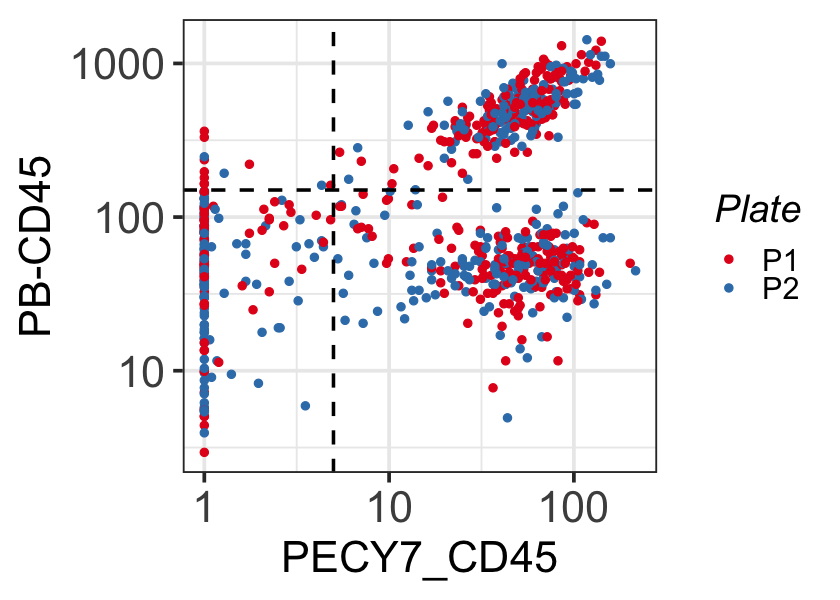

In [23]:
# Examine plate mixing between the two plates to make sure there is no obvious bias
fig.size(5, 7)
ggplot(FlowMatrix %>% filter(Experiment_Index == "PTEN") %>% na.omit) +
    geom_point(aes(x=PECY7_CD45, y=PB_CD45, color = Plate), alpha = 1, size = 2) +
    theme_gy() + 
    scale_color_brewer(palette = "Set1")  + 
    theme(legend.position = "right") + scale_y_log10() + scale_x_log10() + 
    geom_vline(xintercept = 5, linetype =2, size = 1 )+
    geom_hline(yintercept = 150, linetype =2, size = 1 ) + 
    ylab("PB-CD45") + xlab("PECY7_CD45") + 
labs(color = "Plate", shape = "Cell Type")

# Load RNA

RNA data was processed and count matrices generated with STARsolo. See manuscript for details on these steps. These files are then imported below and processed for further analysis

In [24]:
#Define the directory where these files are located. 
rna_dir <- '/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/RNAOutput'

## List subdirectories with *Solo.out/Gene/filtered*
rna_paths = list.dirs(path = rna_dir, full.names = TRUE, recursive = TRUE)[grepl('raw',
                                  list.dirs(path = rna_dir, full.names = TRUE, recursive = TRUE))]



In [26]:
#import all expression data
exprs <- do.call(cbind, lapply(rna_paths, function(run){
    name = str_split(run, '/RNAOutput/') %>% map(2) %>% str_replace('/Solo.out/GeneFull/raw', '')
    exprs = read10x_mtx(run, name)
})
)

In [27]:
# A quick look at this matrix. 
exprs[1:10,1:10]

  [[ suppressing 10 column names ‘AACATCTCTGTGAC_ACAACCAGGA’, ‘AACCAACCAGACTC_ACAACCAGGA’, ‘AACCGTATGCGGTG_ACAACCAGGA’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                             
A1BG      . . . . 2 . 2 . 2 .
A1BG-AS1  . . . . . . . . . .
A1CF      . . . . . . . . . .
A2M       . . . . . . . . . .
A2M-AS1   . . . . . . . . . .
A2ML1     . . . . . . . . . .
A2ML1-AS1 . 1 . . . . . . 1 .
A2ML1-AS2 . . . . . . . . . .
A3GALT2   . . . 1 . . . . . .
A4GALT    . . . . . . . . . .

In [28]:
#Generate and add meta data. Extract colnames and split between plate and cell. The nomenclature is cell_plate
meta <- data.frame(cell = colnames(exprs),
                  plate = exprs %>% colnames %>% str_split('_') %>% map(2) %>% unlist)
rownames(meta) = colnames(exprs)

In [29]:
#Read in the actual plate meta data. Ie experiment, conditions, sgRNA sequence. 
plateMeta <- read_delim('PlateMeta.csv') %>% as.data.frame

# A quick look at this
head(plateMeta)

#Fix naming
plateMeta <- plateMeta %>% mutate(MainCondition = str_split(Condition, '_') %>% map(1) %>% unlist)
plateMeta <- plateMeta %>% mutate(MainCondition = ifelse(grepl('Lysis', MainCondition), 'Lysis', MainCondition)) 

#Pivot wider and remove redundant names
plateMeta <- plateMeta %>% mutate(Condition = str_replace(Condition, '_ADT', ''))
plateMeta <- plateMeta %>% pivot_wider(names_from = Type, values_from = Barcode)

#Final meta data
head(plateMeta)

Rows: 24 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Condition, Barcode, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Condition   Barcode    Type
1 DQB1_P1     CAGTCGTGCG RNA 
2 DQB1_P1_ADT ACATAACGGA ADT 
3 DQB1_P2     GTCTAACCTC RNA 
4 DQB1_P2_ADT TTAATAGACC ADT 
5 DQB1_P3     GAACTCGGTT RNA 
6 DQB1_P3_ADT ACGATTGCTG ADT

Condition MainCondition RNA        ADT       
1 DQB1_P1   DQB1          CAGTCGTGCG ACATAACGGA
2 DQB1_P2   DQB1          GTCTAACCTC TTAATAGACC
3 DQB1_P3   DQB1          GAACTCGGTT ACGATTGCTG
4 DQB1_P4   DQB1          AGTTATCACA TTCTACAGAA
5 FBXO11_P1 FBXO11        GTCTCGTGAA GCGTGTGAGA
6 FBXO11_P2 FBXO11        CCATCCACGC TCTCCATTGA

In [30]:
# Add all plate meta data to cell data from the RNA matrtix. 
meta <- merge(meta, plateMeta, by.x = 'plate', by.y = 'RNA')
rownames(meta) = meta$cell
meta <- meta[colnames(exprs), ]

In [31]:
### Update meta data to include the plate barcode for ADT. This is the unique ADT ID. cell_ADT. 
meta <- meta %>% mutate(cell_ADT = paste0(str_split(cell, '_') %>% map(1), '_', ADT))

In [32]:
#Final meta data.
meta %>% head(2)

plate      cell                      Condition
AACATCTCTGTGAC_ACAACCAGGA ACAACCAGGA AACATCTCTGTGAC_ACAACCAGGA FBXO11_P3
AACCAACCAGACTC_ACAACCAGGA ACAACCAGGA AACCAACCAGACTC_ACAACCAGGA FBXO11_P3
                          MainCondition ADT        cell_ADT                 
AACATCTCTGTGAC_ACAACCAGGA FBXO11        ACATGCATAT AACATCTCTGTGAC_ACATGCATAT
AACCAACCAGACTC_ACAACCAGGA FBXO11        ACATGCATAT AACCAACCAGACTC_ACATGCATAT

# Repeat the analysis above for ADT data generated with kallistoKite

In [33]:
adt_dir <- '/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/ADT_Transfer'

## List subdirectories with *Solo.out/Gene/filtered*
adt_paths <- list.dirs(path = adt_dir, full.names = TRUE, recursive = TRUE)[endsWith(list.dirs(path = adt_dir, 
                                                                                              full.names = TRUE, recursive = TRUE), 
                                                                                    'counts_unfiltered')]
adt_paths %>% head(2)

counts_ADT <- do.call(cbind, lapply(adt_paths, function(run){
    name = str_split(run, '/ADT_Transfer/') %>% map(2) %>% str_replace('/counts_unfiltered', '')
    counts = read10x_kallisto(run, name)
 
})
)

[1] "/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/ADT_Transfer/ACATAACGGA/counts_unfiltered"
[2] "/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/ADT_Transfer/ACATGCATAT/counts_unfiltered"

In [34]:
#extract cell IDs
meta_ADT <- data.frame(cell_adt = colnames(counts_ADT),
                  plate = counts_ADT %>% colnames %>% str_split('_') %>% map(2) %>% unlist)
#Add plate data by ADT code
meta_ADT <- merge(meta_ADT, plateMeta, by.x = 'plate', by.y = 'ADT')
meta_ADT <- meta_ADT %>% mutate(cell = paste0(cell_adt %>% str_split('_') %>% map(1) %>% unlist, 
                                  '_', RNA))
rownames(meta_ADT) <- meta_ADT$cell_adt

# Update cell names to include RNA plate barcode
meta_ADT <- meta_ADT[colnames(counts_ADT), ]
rownames(meta_ADT) <- meta_ADT$cell
colnames(counts_ADT) <- rownames(meta_ADT)

In [35]:
# Filter non-human ADTs and cells not identified in the RNA data
counts_ADT_filt <- counts_ADT[rownames(counts_ADT)[!grepl('^Mouse|^Rat|^Hamster', rownames(counts_ADT))], 
                             intersect(rownames(meta_ADT), rownames(meta))]

meta_ADT_filt <- meta_ADT[intersect(rownames(meta_ADT), rownames(meta)), ]

# Load in DNA modality generated by analysis of amplicons with CRISPResso2

Allele tables are calculated with CRISPResso2. This is the input for our downstream analysis. Each cell has its own allele table. 

In [36]:
#Read in data. Skip all below if done already. 
alleles_DNA <- read_csv("alleles_DNA_R2.csv")
alleles_DNA_Full <- read_csv("alleles_DNA_Full.csv")

Rows: 36467 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Barcode_DNA, Well_ID, Aligned_Sequence, PlateLabel, MainCondition, ...
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 35275 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Barcode_DNA, Well_ID, Aligned_Sequence, PlateLabel, MainCondition, ...
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Two analysis tables were generated. One with info from both ends and one that only used R2 data.
This is because the DQB1 amplicon was too long for R1 and R2 analysis. 

In [351]:
#Location of DNA files for DQB1 data, adjust as necessary
DNAfiles = "/Users/ybaglaen/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/Alleles"

In [440]:
#Location of DNA files for FBXO11, PTEN data, adjust as necessary 
DNAfiles_full = "/Users/ybaglaen/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/AllelesFull"

In [67]:
#Import DNA meta data table
meta_DNA <- read_csv("DNAMeta.csv")
head(meta_DNA)

Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): PlateLabel, MainCondition, Barcode_DNA, Reference

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PlateLabel MainCondition Barcode_DNA
1 JDHEK_P1   JDHEK         CGCTCAGTTC 
2 JDHEK_P2   JDHEK         TATCTGACCT 
3 FBXO11_P1  FBXO11        ATATGAGACG 
4 FBXO11_P2  FBXO11        CTTATGGAAT 
5 FBXO11_P3  FBXO11        TAATCTCGTC 
6 FBXO11_P4  FBXO11        GCGCGATGTT 
  Reference                                                                                                                                                                                                                                 
1 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
2 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
3 CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG                                                              
4 CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG                                                              
5 CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG                                                              
6 CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG

In [34]:
#Read in and collapse all alleles in the DQB1 experiment. 
alleles_DNA <- AllelesFunction(DNAfiles) # The function is found in utils.R

ERROR: Error in eval(expr, envir, enclos): object 'DNAfiles' not found


In [476]:
#Read in and collapse all alleles in the PTEN, FBXO11 experiment. 
alleles_DNA_Full <- AllelesFunction(DNAfiles_full)

In [41]:
# Add meta data to the DQB1 experiment
alleles_DNA<- alleles_DNA %>% separate(Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% inner_join(read_csv("DNAMeta.csv"))

ERROR: [1m[33mError[39m in `separate()`:[22m
[1mCaused by error:[22m
[33m![39m object 'Plate_Well' not found


In [478]:
# Add meta data to the PTEN, FBXO11 experiments
alleles_DNA_Full<- alleles_DNA_Full %>% separate(Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% inner_join(read_csv("DNAMeta.csv"))

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [6590, 6591, 6592,
6593, 6594, 6595, 6596, 6597, 6598, 6599, 18903, 18904, 18905, 18906, 18907,
18908, 18909, 18910, 18911, 18912].”
Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): PlateLabel, MainCondition, Barcode_DNA, Reference

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Barcode_DNA)`


In [479]:
#Export Alleles Matrices to never do that again.#There are provided for easy replication.
write_csv(alleles_DNA, "alleles_DNA_R2.csv")
write_csv(alleles_DNA_Full, "alleles_DNA_Full.csv")

In [37]:
#subset for downstream analysis
PTEN_alleles_DNA <- filter(alleles_DNA, MainCondition == "JDHEK")
FBXO11_alleles_DNA <- filter(alleles_DNA_Full, MainCondition == "FBXO11")
DQB1_alleles_DNA <- filter(alleles_DNA, MainCondition == "DQB1") 

## DNA analysis of PTEN experiment

In [36]:
PTEN_alleles_DNA %>% head

Barcode_DNA Well_ID
1 CGCTCAGTTC  A1     
2 CGCTCAGTTC  A1     
3 CGCTCAGTTC  A1     
4 CGCTCAGTTC  A1     
5 CGCTCAGTTC  A1     
6 CGCTCAGTTC  A1     
  Aligned_Sequence                                                                                                                                                                                                                                  
1 ------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA        
2 -------------------------------------------------------------GCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA 
3 ------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCATGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA        
4 --------------------------------------TCAGGACCCACACG------------------ACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTG------AAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
5 ------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGCTTGTACTTTACTTTCATTGGGA        
6 ------------------------------------------------------GTGGTCTGCTAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA        
  n_deleted n_inserted n_mutated #Reads %Reads     PlateLabel MainCondition
1 0         0          0         247    66.3978495 JDHEK_P1   JDHEK        
2 0         0          0          22     5.9139785 JDHEK_P1   JDHEK        
3 0         0          0          11     2.9569892 JDHEK_P1   JDHEK        
4 0         1          1          10     2.6881720 JDHEK_P1   JDHEK        
5 0         0          0           7     1.8817204 JDHEK_P1   JDHEK        
6 0         0          0           3     0.8064516 JDHEK_P1   JDHEK        
  Reference                                                                                                                                                                                                                                 
1 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
2 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
3 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
4 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
5 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
6 GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAG

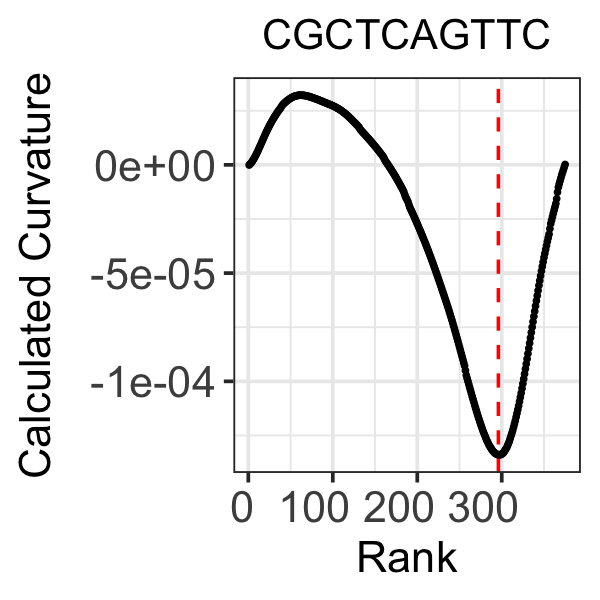

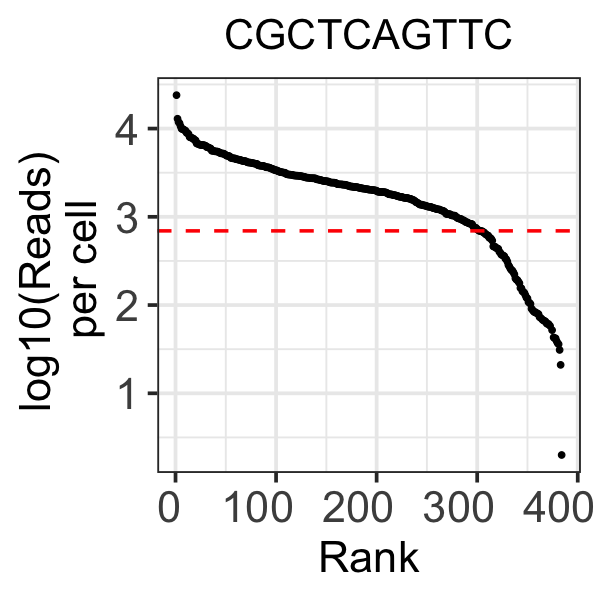

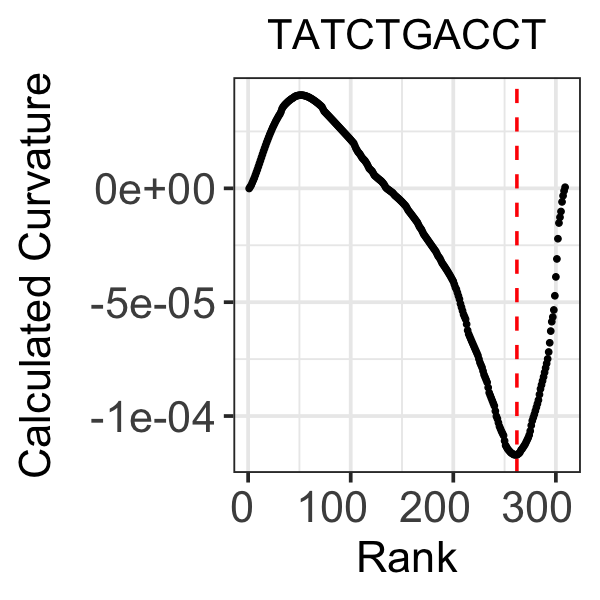

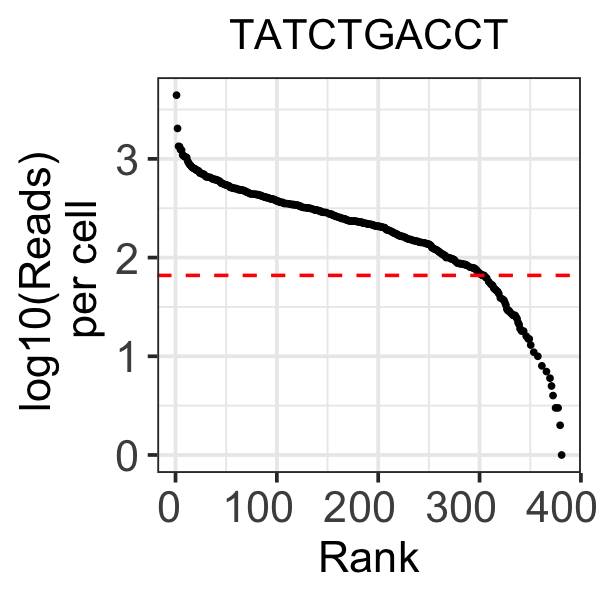

In [37]:
fig.size(5,5)
PTEN_alleles_DNA_filtered <- Filtering_Cells_Read(PTEN_alleles_DNA) ## filter out "poor" quality cells based inspired by the Empty Droplet's algorithm. Found in utils.R

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


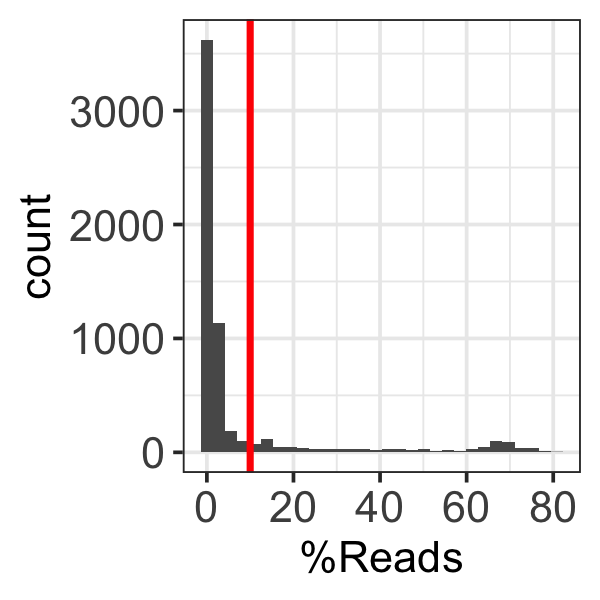

In [38]:
#Define a cutoff to remove background alleles. This is set to 5% and can be adjusted
PTEN_alleles_DNA_filtered %>% ggplot(aes(`%Reads`)) + geom_histogram() + theme_gy() + geom_vline(xintercept = 10, color = "red", size = 2)

In [39]:
# Filter low level alleles based on first derivative with specified cutoff
PTEN_alleles_DNA_filtered <- PTEN_alleles_DNA_filtered %>% Filtering_Alleles(cutoff = 10) 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


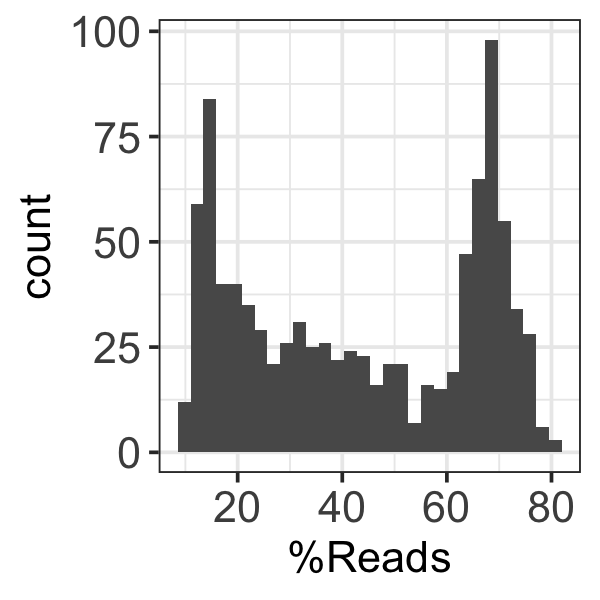

In [40]:
# plot distribution of alleles
PTEN_alleles_DNA_filtered %>% ggplot(aes(`%Reads`)) + geom_histogram() + theme_gy() 

In [41]:
#To properly visualize these large insertions we need to realign with Biostrings. 
# Define an all encompasing reference sequence with indels present. 
PTENindelseq <- "GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA"
PTEN_alleles_DNA_filtered_align <- mutate(PTEN_alleles_DNA_filtered, "Reference" = PTENindelseq)

In [42]:
#Replace all special characters
PTEN_alleles_DNA_filtered_align <- mutate(PTEN_alleles_DNA_filtered_align, "Aligned_Sequence" = 
                                 str_replace_all(Aligned_Sequence, pattern = "-", replace = ""))

#Perform biostrings alignment
PTEN_alleles_DNA_filtered_align <- mutate(PTEN_alleles_DNA_filtered_align, "Aligned_Sequence" = as.character(alignedPattern
                                                               (pairwiseAlignment(Aligned_Sequence, Reference))))
#Trim length for visualization and plotting
PTEN_alleles_DNA_filtered_align<- 
    mutate(PTEN_alleles_DNA_filtered_align, 
           "Aligned_Sequence" = str_trunc(Aligned_Sequence, 180, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 180, "left", ellipsis = ""))%>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 100, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 100, "right", ellipsis = ""))

In [43]:
## Remove alleles found in less than 5 cells. 
PTEN_filt_allele <- PTEN_alleles_DNA_filtered_align  %>% add_count(name = "AlleleCount", Aligned_Sequence) %>% filter(AlleleCount >5)
##Calculate genotypes - function in utils.R
PTEN_genotypes <- Genotyping_Cells(PTEN_filt_allele)

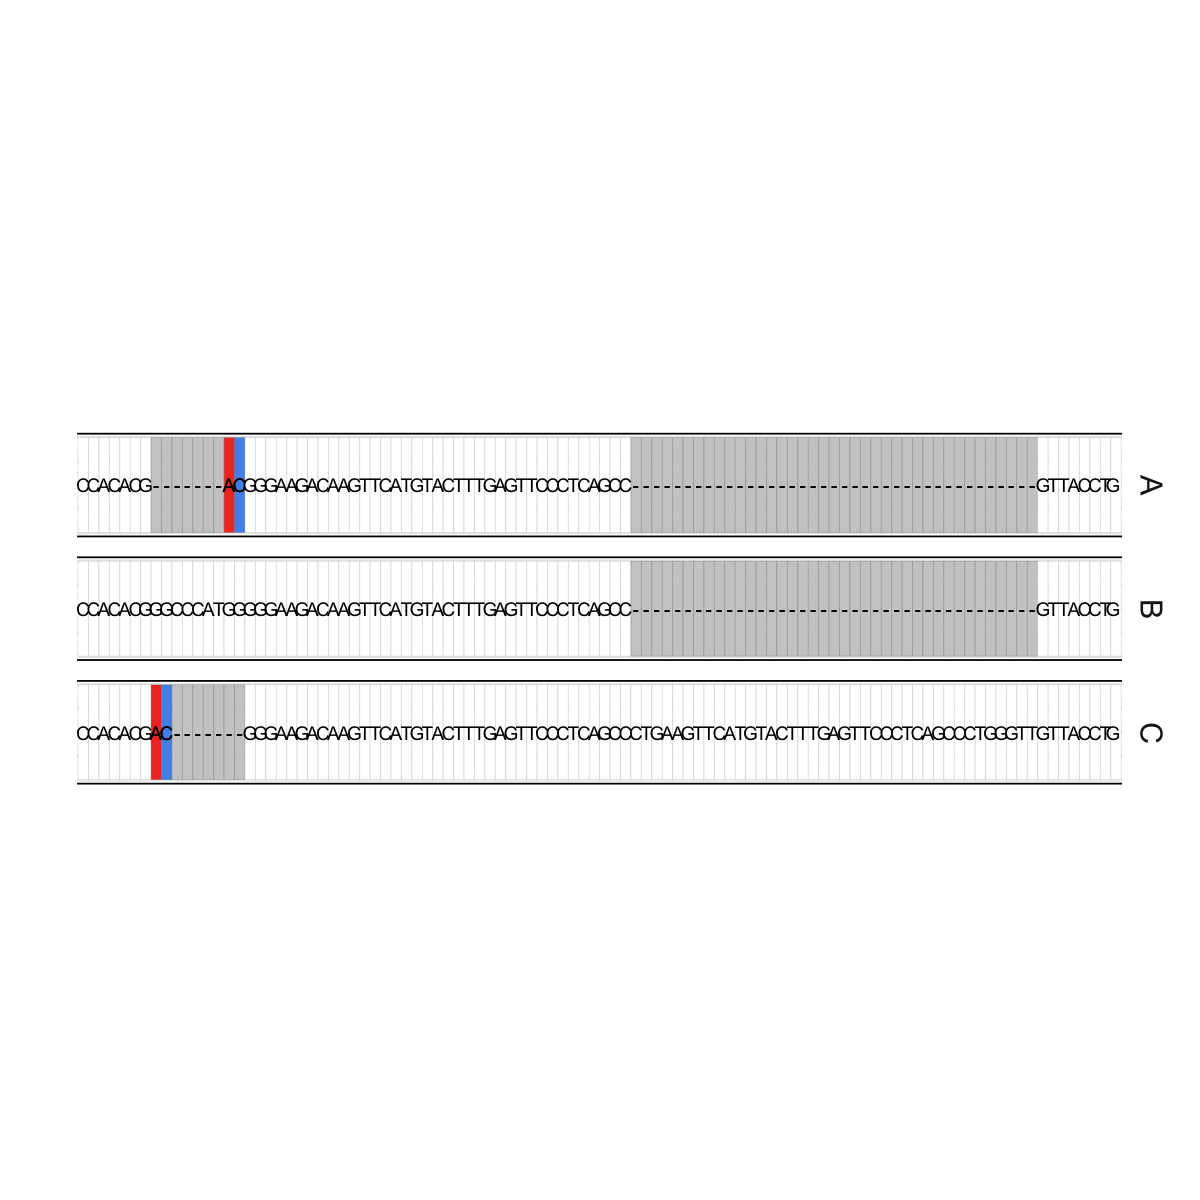

In [44]:
Plotting_Alleles(PTEN_filt_allele) # plotting function in utils.R

## DNA Analysis of DQB1 editing experiment

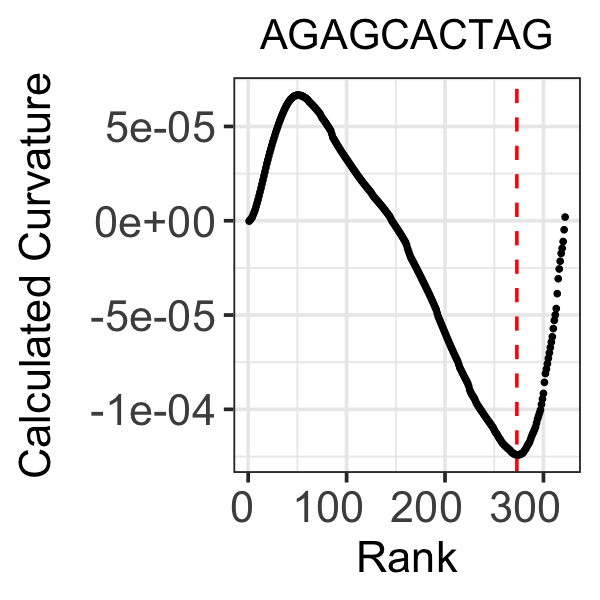

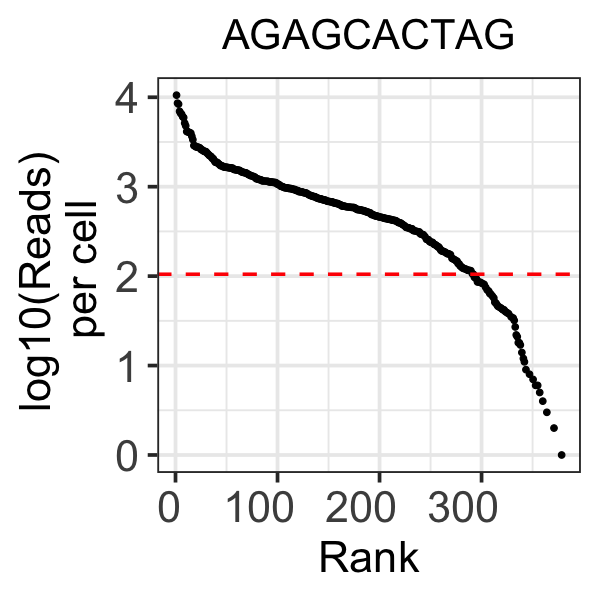

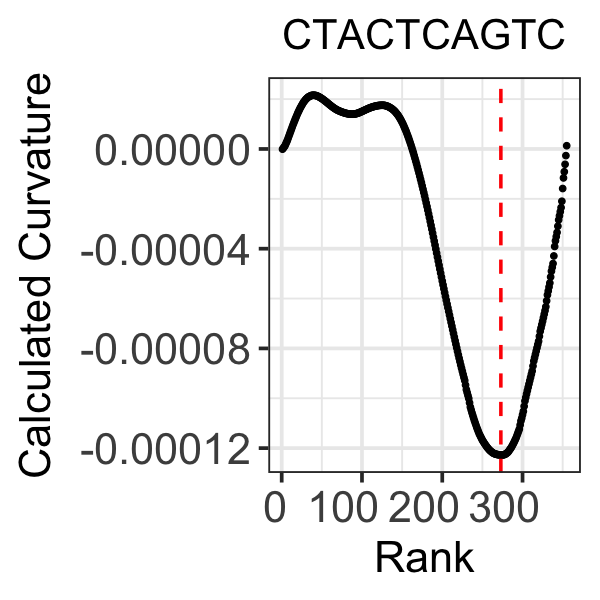

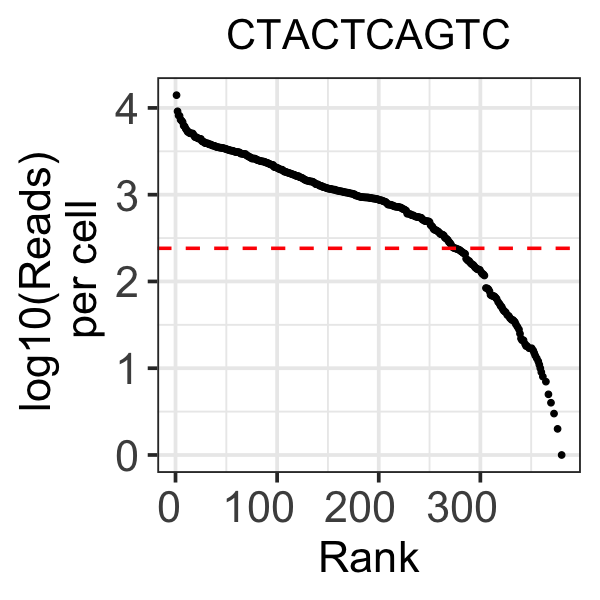

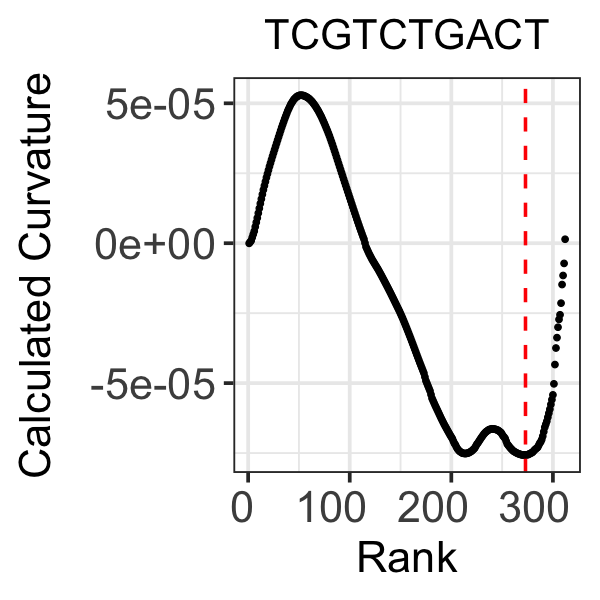

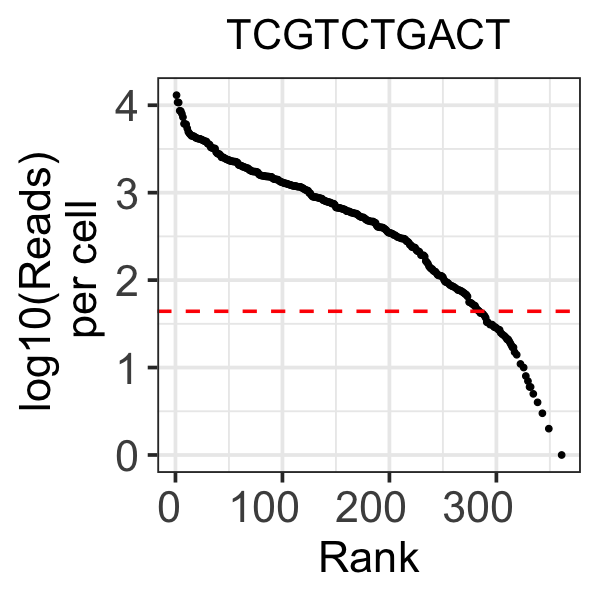

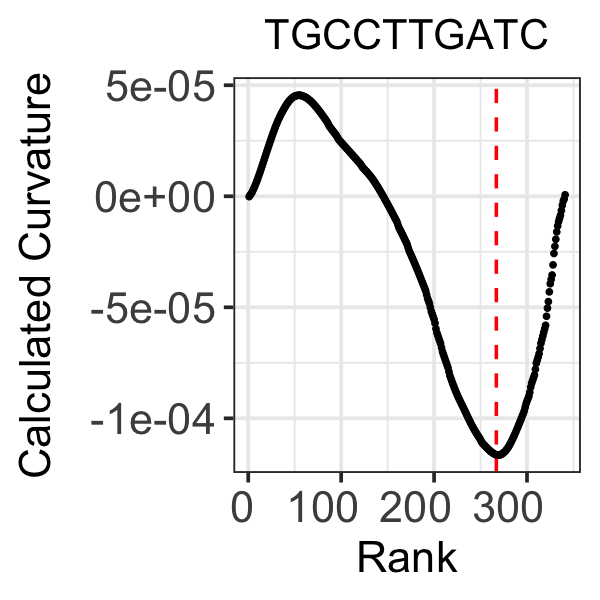

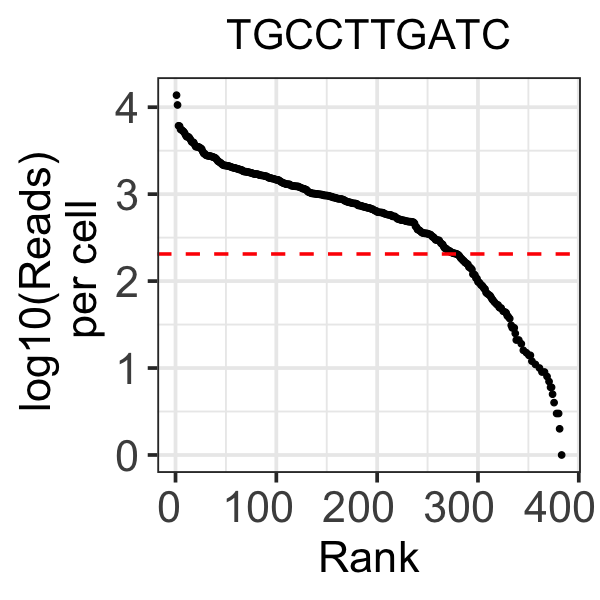

In [82]:
fig.size(5,5)
DQB1_filtered <- Filtering_Cells_Read(DQB1_alleles_DNA) # Filter DNA alleles by reads

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_bar()`).”


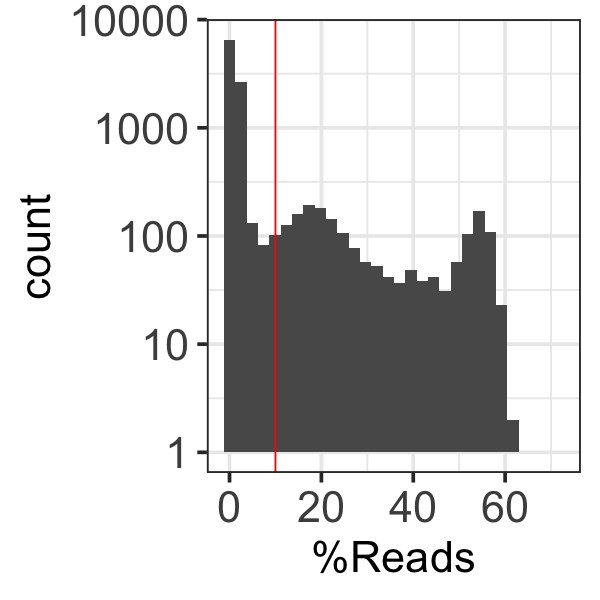

In [83]:
#Define a cutoff
DQB1_filtered %>% ggplot(aes(`%Reads`)) + geom_histogram() + theme_gy() + geom_vline(xintercept = 10, color = "red") + scale_y_log10()

In [84]:
DQB1_filtered <- Filtering_Alleles(DQB1_filtered, cutoff = 10) #Filter alleles 

In [85]:
#Fix lengths of amplicons.
DQB1_filtered<- mutate(DQB1_filtered, 
           "Aligned_Sequence" = str_trunc(Aligned_Sequence, 180, "left", ellipsis = "")) %>% 
            mutate("Reference"= str_trunc(Reference, 180, "left", ellipsis = ""))

In [33]:
# Add per allele comparison to reference. This is done to define the deletion / mutation areas for heatmaps

In [86]:
DQB1_filtered$Allele_Mismatch <- as.vector(attr(adist(DQB1_filtered$Aligned_Sequence, DQB1_filtered$Reference[1], counts = TRUE), "trafos"))

In [87]:
#Add deletion statistic based on the mean deletion size across all alleles. We are grouping by cell and then calculating the mean.
#Deletion size is a statistic from CRISPResso
DeletionMatrix<- DQB1_filtered %>% mutate("log_deleted" = log2(n_deleted+1))%>% # take log of the value for analysis
    group_by(plate_well) %>% mutate("DQB1deletion_Mean" = mean(log_deleted)) %>% #calculate the mean across all alleles in a given cell
    inner_join(read_csv("PlateMeta2Full.csv"), by = "Barcode_DNA")%>%  # Join with Meta data
    inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>%  #Join with barcode data
    mutate(cell = paste0(RNA_cell, "_", Barcode_RNA)) #mutate a uniform cell_ID

Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 384 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`


In [88]:
# Change to 0 and 1s for later processing in a heatmap. #Any mismatches calcualted above is returned as 1.
DeletionMatrix$Allele_Mismatch <-  DeletionMatrix$Allele_Mismatch %>% 
str_replace_all(pattern = ("M"), "0") %>% str_replace_all(pattern = ("S|I|D"), "1") 


In [89]:
#Split this alignment of 0 and 1s into a matrix. 
DQB1_Deletion_Matrix <- apply(matrix(DeletionMatrix$Allele_Mismatch), 1, 
        function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(DeletionMatrix$Allele_Mismatch[1]))
class(DQB1_Deletion_Matrix) <- "numeric"

Warning message in class(DQB1_Deletion_Matrix) <- "numeric":
“NAs introduced by coercion”


In [91]:
#Add back cell ids
DQB1_Deletion_Matrix <- cbind("cell" = DeletionMatrix$cell %>% as.factor() %>% as.numeric, DQB1_Deletion_Matrix)

In [96]:
DQB1_Deletion_Matrix[1:5, c(1,80:100)]

cell                   ⋯                    
[1,]  2   0 0 0 0 0 0 0 0 0 ⋯ 0 0 0 0 0 0 0 0 0 0
[2,] 30   0 0 0 0 0 0 0 0 0 ⋯ 0 0 0 0 0 0 0 0 0 0
[3,] 34   0 0 0 0 0 0 0 0 0 ⋯ 0 0 0 0 0 0 0 0 0 0
[4,] 37   1 1 1 1 1 1 1 1 1 ⋯ 1 1 1 1 1 0 0 0 0 0
[5,] 37   0 0 0 0 0 0 0 0 0 ⋯ 0 0 0 0 0 0 0 0 0 0

In [97]:
#derive a frequency of edited alleles per base pair position. As you can see above, cell # 37 has two alleles. 
#The values are added per column(nucleotide) and then divided by two for an average across the cell.
DQB1_Deletion_Matrix <- sapply(unique(DQB1_Deletion_Matrix[,'cell']), function(i) { 
            if (sum(DQB1_Deletion_Matrix[,"cell"] == i) > 1) {
                colSums(DQB1_Deletion_Matrix[DQB1_Deletion_Matrix[,"cell"]==i,-1]) / sum(DQB1_Deletion_Matrix[,"cell"] == i)
            } else {
                DQB1_Deletion_Matrix[DQB1_Deletion_Matrix[,"cell"]==i,-1]
            } })

colnames(DQB1_Deletion_Matrix) <- unique(DeletionMatrix$cell)
DQB1_Deletion_Matrix <- t(DQB1_Deletion_Matrix)
         

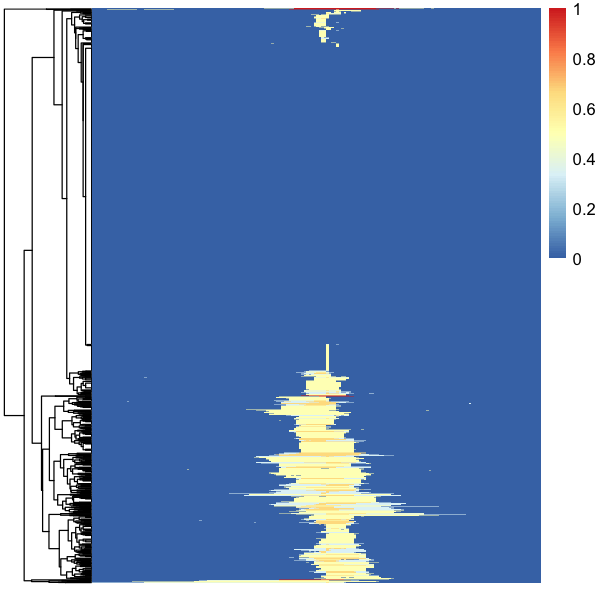

In [99]:
# A really quick heatmap to visualize this. Proper analysis is further completed in another notebook. 
pheatmap(na.omit(DQB1_Deletion_Matrix), 
             cluster_rows = T, 
             cluster_cols = FALSE,show_rownames = F )

In [537]:
write_csv(DQB1_Deletion_Matrix %>% as_tibble(rownames = "cell"), "DeletionMatrix_Updated.csv") # save for later. This is also provided for easy replication.

### Identifying HDR cells for analysis - incorporation of data

In [101]:
HDRDQB1<- DQB1_filtered$Aligned_Sequence %>% grep(pattern = "GCTGATTGGTTCTTTTCCGAGCGACCATCCAAT") # Search for corrected allele. 
HDRCells <- DQB1_filtered[HDRDQB1,] %>% mutate("DNA_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% with(DNA_Well) # pull out Plate and well ID

In [102]:
#Identify any TRUE reference cells. No mutations of any kind. Pull out these well_IDs as well. 
ReferenceCells<- DQB1_filtered %>% mutate(DNA_Well = paste0(Barcode_DNA, "_", Well_ID)) %>% group_by(DNA_Well) %>% 
    summarize(editing = sum(n_deleted)+sum(n_inserted) + sum(n_mutated)) %>% filter(editing == 0) %>% 
with(DNA_Well)

In [103]:
#Save this data - provided for replication purposes. 
write.csv(ReferenceCells, "DQB1Reference.csv")
write.csv(HDRCells, "DQB1HDR.csv")

The next set of analyses are performed in a seperate workwork. This includes clustering and plotting the data

## DNA Analysis of FBXO11 base-editing experiment.Run 1

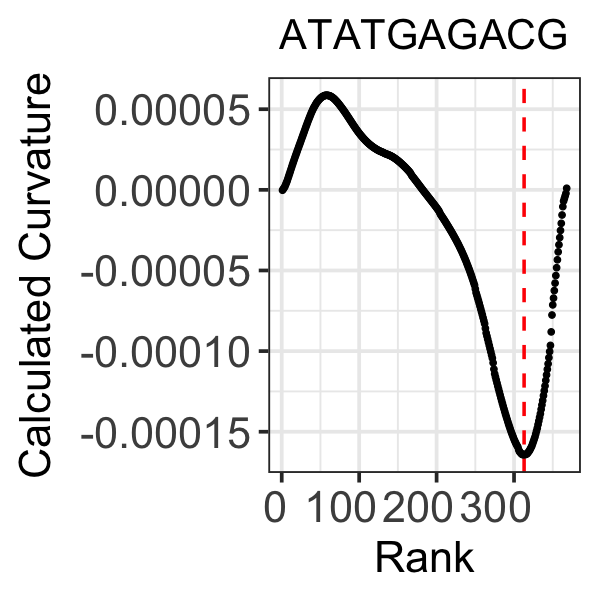

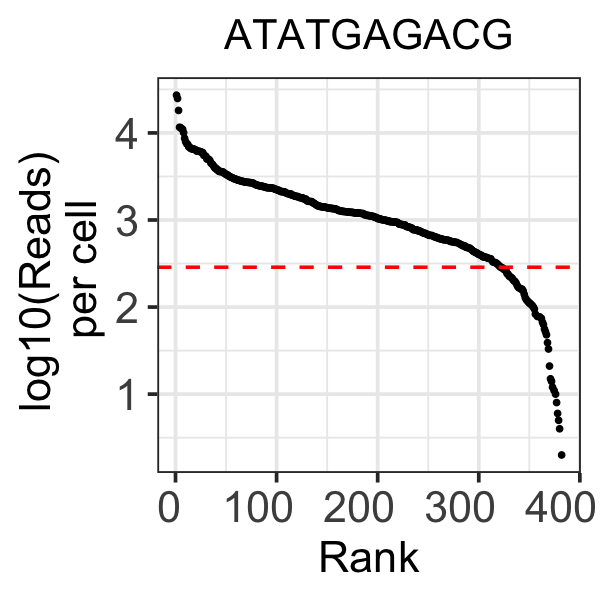

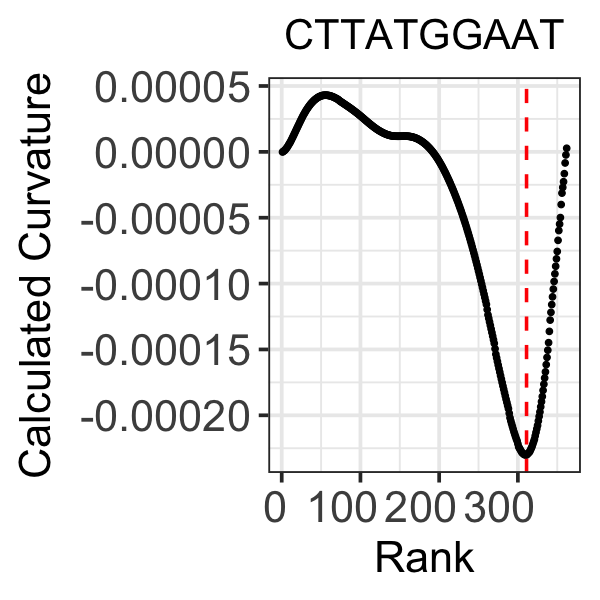

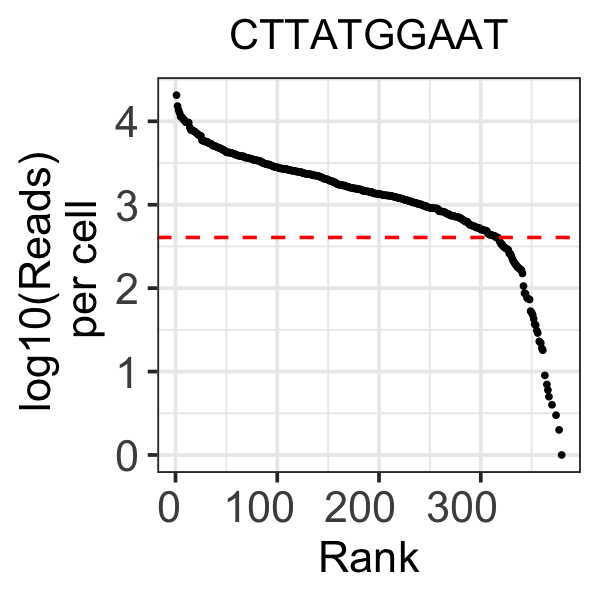

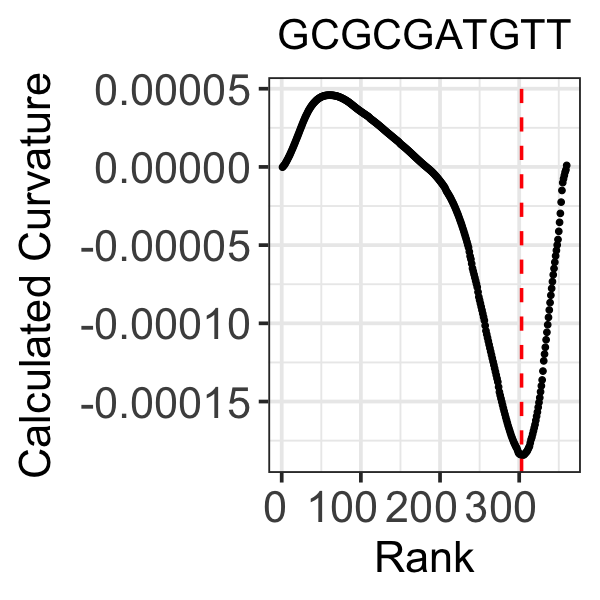

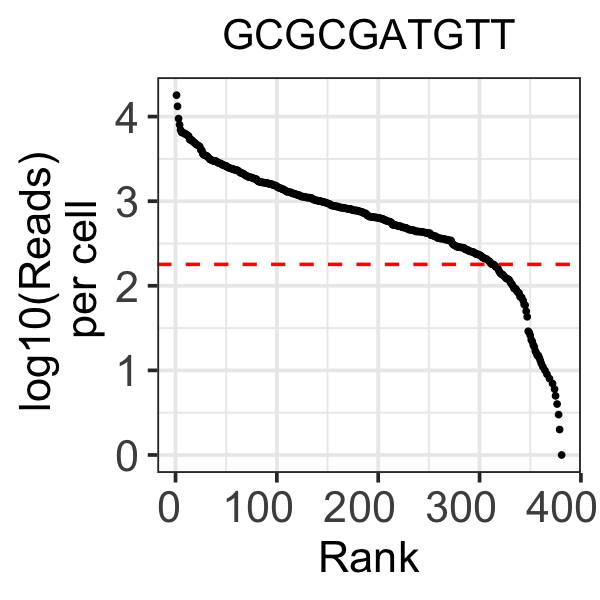

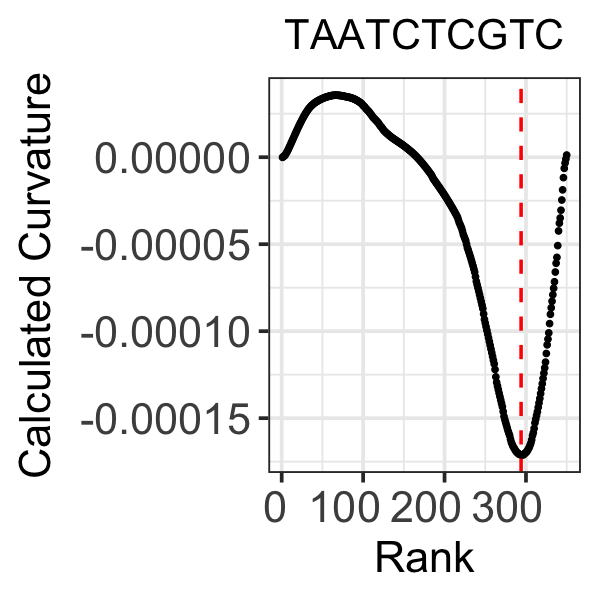

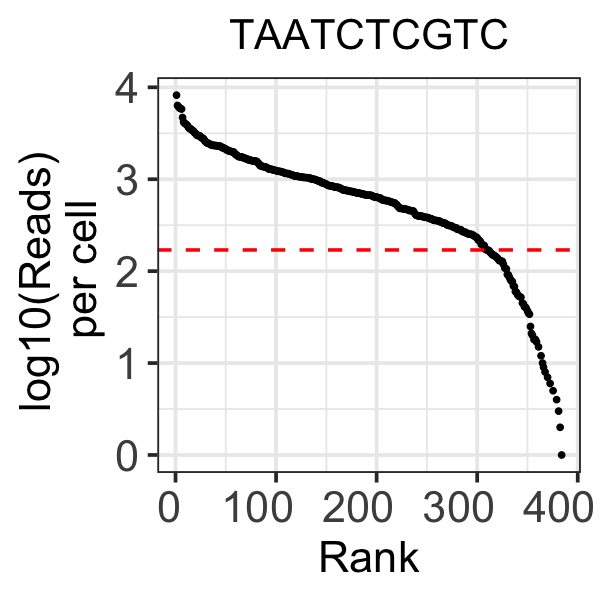

In [104]:
FBXO11_filtered <- Filtering_Cells_Read(FBXO11_alleles_DNA) # Filter cells

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


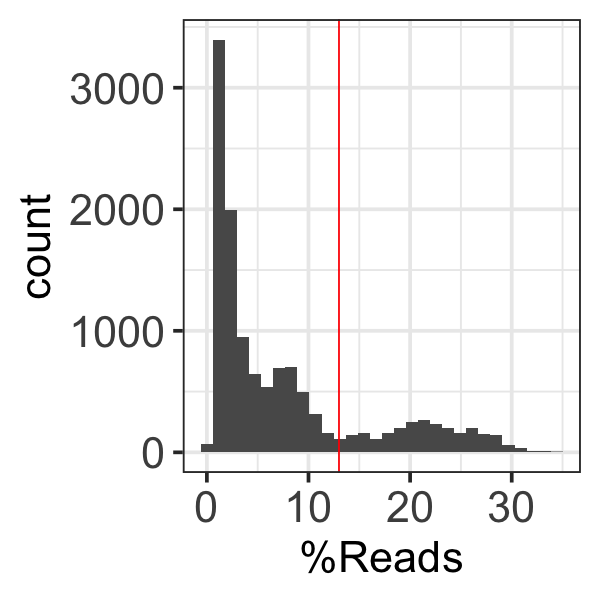

In [105]:
#Define a cutoff. 
FBXO11_filtered %>% ggplot(aes(`%Reads`)) + geom_histogram() + theme_gy() + geom_vline(xintercept = 13, color = "red")

In [106]:
FBXO11_filtered <- FBXO11_filtered %>% Filtering_Alleles(cutoff=13) # Filter alleles

In [107]:
#Trim all aligned alleles for plotting
FBXO11_filtered <- mutate(FBXO11_filtered, Aligned_Sequence = (str_sub(Aligned_Sequence, -63) %>% str_trunc(51, "right", ellipsis = "")))
FBXO11_filtered <- mutate(FBXO11_filtered, Reference = (str_sub(Reference, -63) %>% str_trunc(51, "right", ellipsis = "")))

In [108]:
## Remove alleles found in less than 5 cells. 
FBXO11_filtered <- FBXO11_filtered  %>% add_count(name = "AlleleCount", Aligned_Sequence) %>% filter(AlleleCount >5)

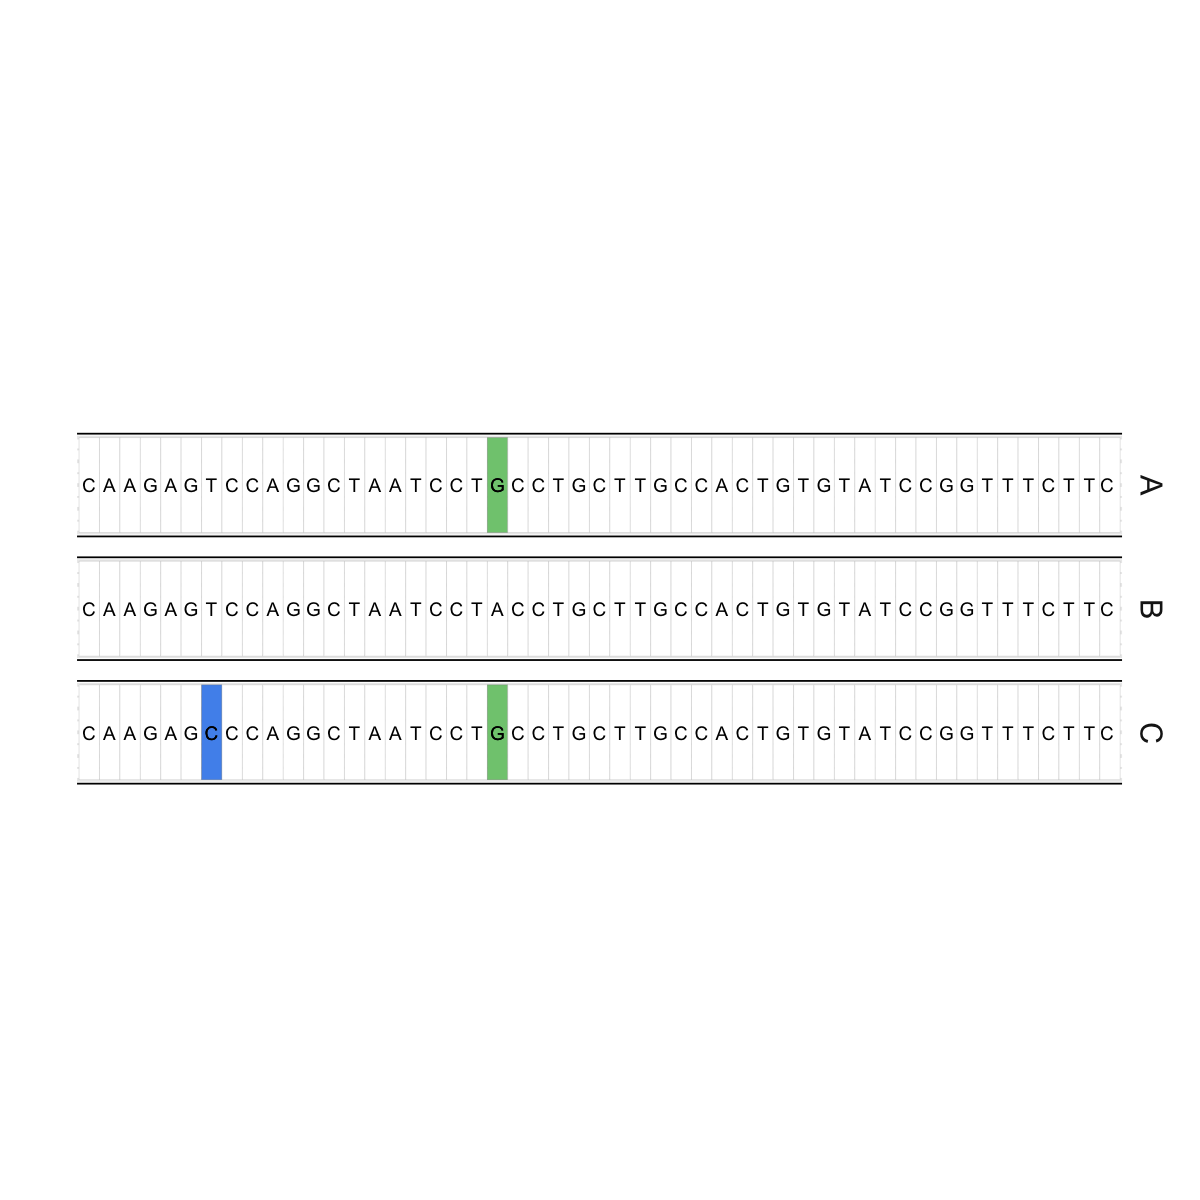

In [109]:
FBXO11_filtered %>% Plotting_Alleles # Plot for visualization

In [110]:
FBXO11_gen <- Genotyping_Cells(FBXO11_filtered) # Define genotypes per cell based on allele collapse.

# Filtering and Quality Control of RNA/ADT

## RNA quality control

In [38]:
nUMI = colSums(exprs) # calculate umi
nGenes = colSums(exprs > 0) # calculate nGEnes
pctMito = colSums(exprs[rownames(exprs)[rownames(exprs) %>% startsWith('MT-')], ])/nUMI # calcuate percent mito reads
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito) # make into a dataframe

In [39]:
meta = cbind(meta, qc_df[rownames(meta), ]) # add to meta data

In [40]:
meta %>% write_csv("meta.csv") # save for later - deposited.

In [41]:
meta %>% head

plate      cell                      Condition
AACATCTCTGTGAC_ACAACCAGGA ACAACCAGGA AACATCTCTGTGAC_ACAACCAGGA FBXO11_P3
AACCAACCAGACTC_ACAACCAGGA ACAACCAGGA AACCAACCAGACTC_ACAACCAGGA FBXO11_P3
AACCGTATGCGGTG_ACAACCAGGA ACAACCAGGA AACCGTATGCGGTG_ACAACCAGGA FBXO11_P3
AACCGTGCCACATA_ACAACCAGGA ACAACCAGGA AACCGTGCCACATA_ACAACCAGGA FBXO11_P3
AACGAGCTGGCAAG_ACAACCAGGA ACAACCAGGA AACGAGCTGGCAAG_ACAACCAGGA FBXO11_P3
AACTACGTCTGTGC_ACAACCAGGA ACAACCAGGA AACTACGTCTGTGC_ACAACCAGGA FBXO11_P3
                          MainCondition ADT        cell_ADT                 
AACATCTCTGTGAC_ACAACCAGGA FBXO11        ACATGCATAT AACATCTCTGTGAC_ACATGCATAT
AACCAACCAGACTC_ACAACCAGGA FBXO11        ACATGCATAT AACCAACCAGACTC_ACATGCATAT
AACCGTATGCGGTG_ACAACCAGGA FBXO11        ACATGCATAT AACCGTATGCGGTG_ACATGCATAT
AACCGTGCCACATA_ACAACCAGGA FBXO11        ACATGCATAT AACCGTGCCACATA_ACATGCATAT
AACGAGCTGGCAAG_ACAACCAGGA FBXO11        ACATGCATAT AACGAGCTGGCAAG_ACATGCATAT
AACTACGTCTGTGC_ACAACCAGGA FBXO11        ACATGCATAT AACTACGTCTGTGC_ACATGCATAT
                          nUMI  nGenes pctMito   
AACATCTCTGTGAC_ACAACCAGGA 32763 4390   0.02624912
AACCAACCAGACTC_ACAACCAGGA 31525 4976   0.02509120
AACCGTATGCGGTG_ACAACCAGGA 14701 2614   0.03244677
AACCGTGCCACATA_ACAACCAGGA 29347 4704   0.01952499
AACGAGCTGGCAAG_ACAACCAGGA 39134 5342   0.01471866
AACTACGTCTGTGC_ACAACCAGGA 20413 3210   0.03737814

In [44]:
##Add indexing flow data to meta. First fix labels on FlowMatrix, then add cell barcode, then merge with meta
meta_Flow <- FlowMatrix %>% mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>%
 mutate("Condition" = paste0(Experiment_Index,"_", Plate)) %>% 
    inner_join(read_csv("PlateMeta.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode,"_",Barcode)) %>% dplyr::select(-Condition) %>%
    inner_join(meta, by = "cell")

Rows: 24 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Condition, Barcode, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Condition)`



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


The following object is masked from ‘package:viridis’:

    viridis_pal


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


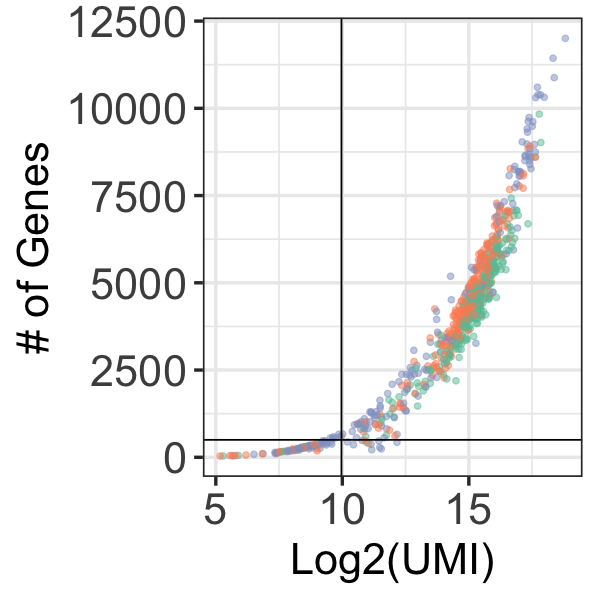

In [45]:
#Plot QC cutoff
fig.size(5,5)
library(scales)
options(scipen = 999)

ggplot(meta_Flow %>% na.omit %>% filter(Experiment_Index == "JDHEK")) +
    #geom_density_2d(aes(x=(nUMI), y=nGenes, color = PTEN_CellType_Index), alpha = 0.5)+ 
    geom_point(aes(x=log2(nUMI), y=nGenes, color = PTEN_CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of Genes") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2")  + 
    theme(legend.position = "none") + 
    scale_x_continuous(labels = scales::comma) + 
    labs(color = "Celltype")+ 
    scale_color_manual(values = c("HEK293T"='#8DA0CB',
                                  "Daudi" = '#66C2A5',
                                  "Jurkat"='#FC8D62')) + 
    geom_vline(xintercept = log2(1000)) + 
    geom_hline(yintercept = 500)
    

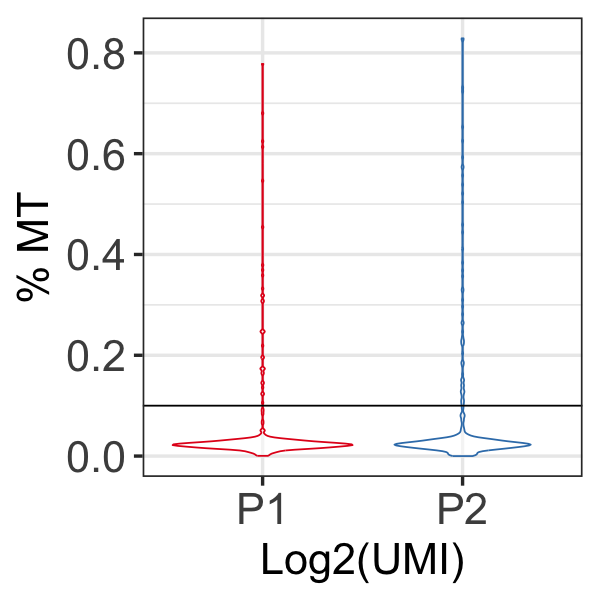

In [46]:
#Plot QC cutoffs
fig.size(5,5)

ggplot(meta_Flow %>% na.omit %>% filter(Experiment_Index == "JDHEK")) +
    #geom_density_2d(aes(x=(nUMI), y=nGenes, color = PTEN_CellType_Index), alpha = 0.5)+ 
    geom_violin(aes(x=Plate, y=`pctMito`, color = Plate), alpha = 0.5) +
    theme_gy(21) + ylab("% MT") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set1")  + 
    theme(legend.position = "none") + 
    geom_hline(yintercept = 0.1)
    

In [76]:
#Calculate gene QC metrics
nCells = rowSums(exprs > 0) #number of genes expressed per cell
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells))) # rank this by gene to filter out lowly expressed genes for analysis

#Perform QC. 
nUMI_thresh =  2000 
nGene_thresh = 500
pctMito_thresh = 0.1
ncell_thresh = floor(dim(exprs)[2]*0.1) #Genes Expressed in 10% of Cells at a minimum. 

#Filter expression matrix
filt_exprs = exprs[rownames(gene_qc %>% filter(nCells > ncell_thresh)), 
                   rownames(qc_df %>% filter(nUMI > nUMI_thresh, 
                                               nGenes > nGene_thresh, 
                                               pctMito < pctMito_thresh))]
#Filter corresponding metadata
filt_meta = meta[colnames(filt_exprs),]

## Save filtered gene Matrix for easier restarting - also deposited. 

In [98]:
writeMM(obj = exprs, "exprs.mtx")
write.csv(colnames(exprs), "colnames_exprs.csv")
write.csv(rownames(exprs), "rownames_exprs.csv")

NULL

In [99]:
writeMM(obj = filt_exprs, "FilteredGeneMatrix.mtx")
write.csv(colnames(filt_exprs), "filt_colnames_exprs.csv")
write.csv(rownames(filt_exprs), "filt_rownames_exprs.csv")
#filter on gene expression > 0 & perecent mito < 0.1 

NULL

## Quality control of ADT data 

In [48]:
# Same as above - define nUMI and nADTS and to meta file
nUMI_ADT = colSums(counts_ADT_filt)
nGenes_ADT = colSums(counts_ADT_filt > 0)
qc_df_ADT = data.frame(nUMI = nUMI_ADT, nGenes = nGenes_ADT)

meta_ADT_filt = cbind(meta_ADT_filt, qc_df_ADT[rownames(meta_ADT_filt), ])

In [49]:
meta_ADT_filt %>% write_csv("meta_adt.csv") # save for later - deposited

In [51]:
##Add indexing flow data to meta. First fix labels on FlowMatrix, then add cell barcode, then merge with meta
meta_ADT_Flow <- FlowMatrix %>% mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>%
 mutate("Condition" = paste0(Experiment_Index,"_", Plate)) %>% 
    inner_join(read_csv("PlateMeta.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode,"_",Barcode)) %>% dplyr::select(-Condition) %>%
    inner_join(meta_ADT_filt, by = "cell")

Rows: 24 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Condition, Barcode, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Condition)`


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


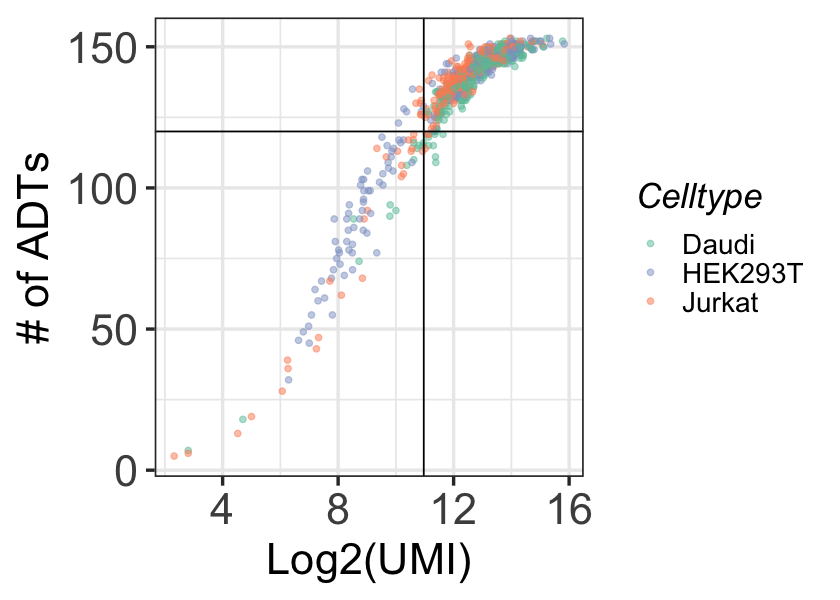

In [52]:
#plot to visualize
fig.size(5, 7)
ggplot(meta_ADT_Flow %>% filter(MainCondition == "JDHEK") %>% na.omit) +
    #geom_density_2d(aes(x=log2(nUMI), y=nGenes, color = PTEN_CellType_Index), alpha = 0.5)+ 
    geom_point(aes(x=log2(nUMI), y=nGenes, color = PTEN_CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of ADTs") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2") + 
    theme(legend.position = "right") + 
 labs(color = "Celltype")+ 
    scale_color_manual(values = c("HEK293T"='#8DA0CB',
                                  "Daudi" = '#66C2A5',
                                  "Jurkat"='#FC8D62')) +
  geom_vline(xintercept = log2(2000))+
    geom_hline(yintercept = 120)
    
    

In [53]:
# Filter to QC'd cells only. > 120 ADTs recovered and more than 2000uMI
meta_ADT_filt = meta_ADT_filt %>% filter(nUMI > 2000, nGenes > 120)
counts_ADT_filt = counts_ADT_filt[, rownames(meta_ADT_filt)]

In [54]:
#Intersect with mRNA data to remove low quality cells
meta_ADT_filt <- filter(meta_ADT_filt, cell %in% filt_meta$cell)
counts_ADT_filt = counts_ADT_filt[, intersect(meta_ADT_filt$cell, filt_meta$cell)]

In [55]:
#Remove some random optimization plates from this experiment. 
meta_ADT_filt <- filter(meta_ADT_filt, !(Condition %in% c("LysisPlate1", "LysispPlate2")))
meta_ADT <- filter(meta_ADT, !(Condition %in% c("LysisPlate1", "LysispPlate2")))

## Save MM for easier export next time

In [109]:
writeMM(counts_ADT_filt, "FilteredADTmatrix.mtx")
writeMM(counts_ADT, "ADT.mtx")
write.csv(colnames(counts_ADT), "colnames_ADT.csv")
write.csv(rownames(counts_ADT), "rownames_ADT.csv")
write.csv(colnames(counts_ADT_filt), "filt_colnames_ADT.csv")
write.csv(rownames(counts_ADT_filt), "filt_rownames_ADT.csv")

NULL

# Pre-process expression data and split by experiment

In [76]:
### Pre-process based on metadata conditions

In [80]:
#Scale individual experiments # function in utils.R
scale_exprs_DQB1 = process_rna(filt_exprs, meta, c('MainCondition'), c('DQB1'))
scale_exprs_FBXO11 = process_rna(filt_exprs, meta, c('MainCondition'), c('FBXO11'))
scale_exprs_JDHEK = process_rna(filt_exprs, meta, c('MainCondition'), c('JDHEK'))

In [57]:
# Process all genes (or a subset) without variable gene selection, useful for plotting
plot_exprs_rna = normalize_rna(filt_exprs, filt_meta, scale = TRUE)

# Dimenstionality Reduction of RNA and ADT data from each experiment

## DQB1

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations



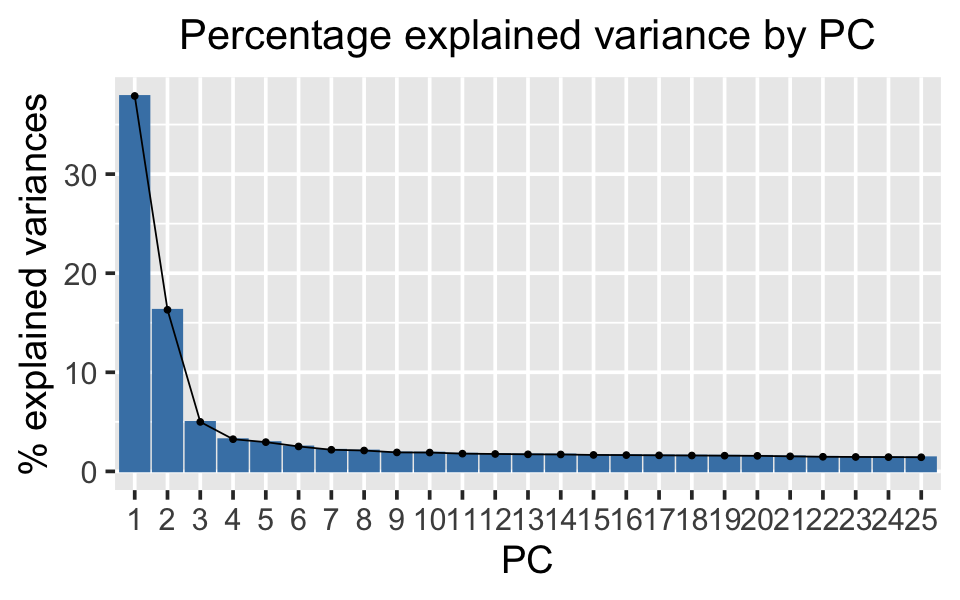

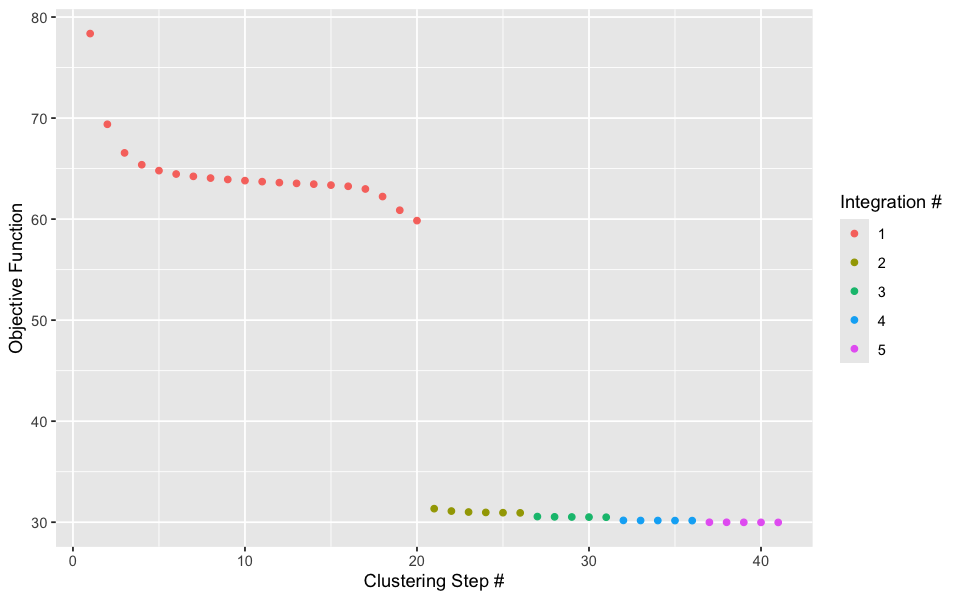

In [156]:
meta_umap_DQB1 = pca_umap(scale_exprs_DQB1, meta, c('MainCondition'), c('DQB1'), harmony_var = 'Condition')

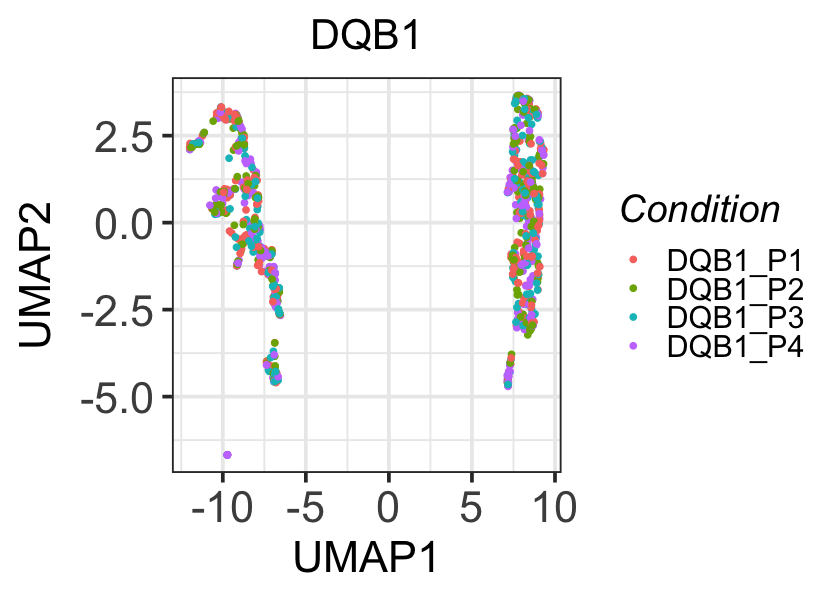

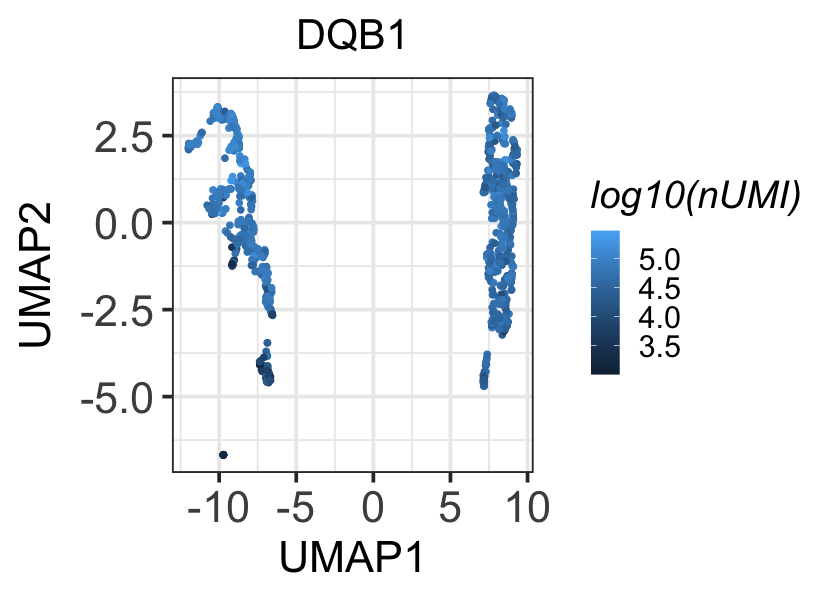

In [157]:
fig.size(5, 7)
ggplot(meta_umap_DQB1 %>% sample_n(nrow(meta_umap_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('DQB1')
fig.size(5, 7)
ggplot(meta_umap_DQB1 %>% sample_n(nrow(meta_umap_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nUMI)))+
    theme_gy()+
    ggtitle('DQB1')

## DQB1 ADT

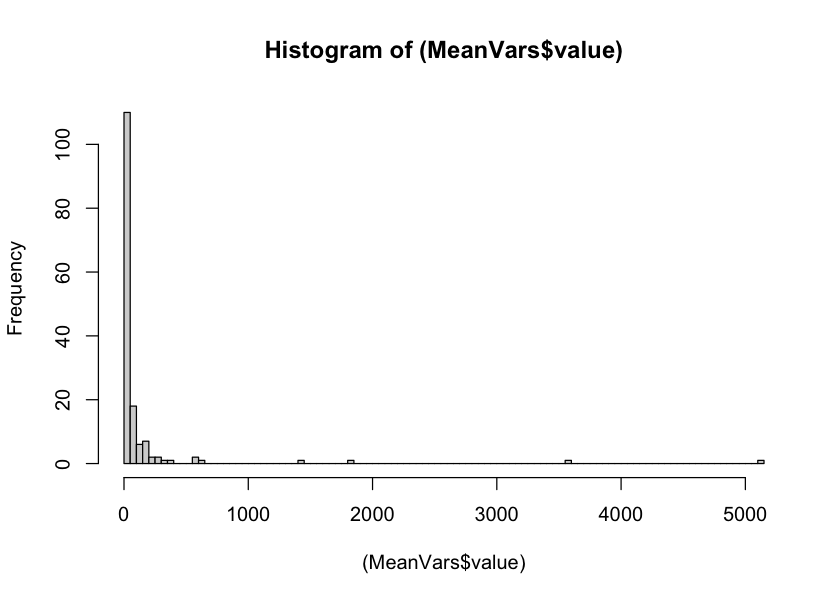

In [158]:
## Remove outlier ADTs - staining that is not reliable. Calcuate Variance over Mean (too high indicates that the expression is low and variance is too high)
counts_DQB1 <- counts_ADT_filt[,meta_ADT_filt %>% filter(MainCondition == "DQB1") %>% with(cell)]

MeanVars <- (rowVars(as.matrix(counts_DQB1))/ rowMeans(counts_DQB1)) %>% as_tibble(rownames = "gene") %>% arrange(-value)
hist((MeanVars$value), breaks = length(MeanVars$value)) #estimate outliers based on distributions
#Clearly four outlies

In [159]:
#set K
outliers <- rosnerTest(MeanVars$value, k = 4) %>% with(all.stats) %>% with(Obs.Num) #identify outliers with rosnerTest
genes <- MeanVars$gene[-outliers] # remove outliers

In [160]:
counts_DQB1 <- counts_DQB1[genes,] #refilter matrix

In [161]:
scale_adt_DQB1 = process_adt(counts_DQB1, meta_ADT_filt, c('MainCondition'), c('DQB1'))

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



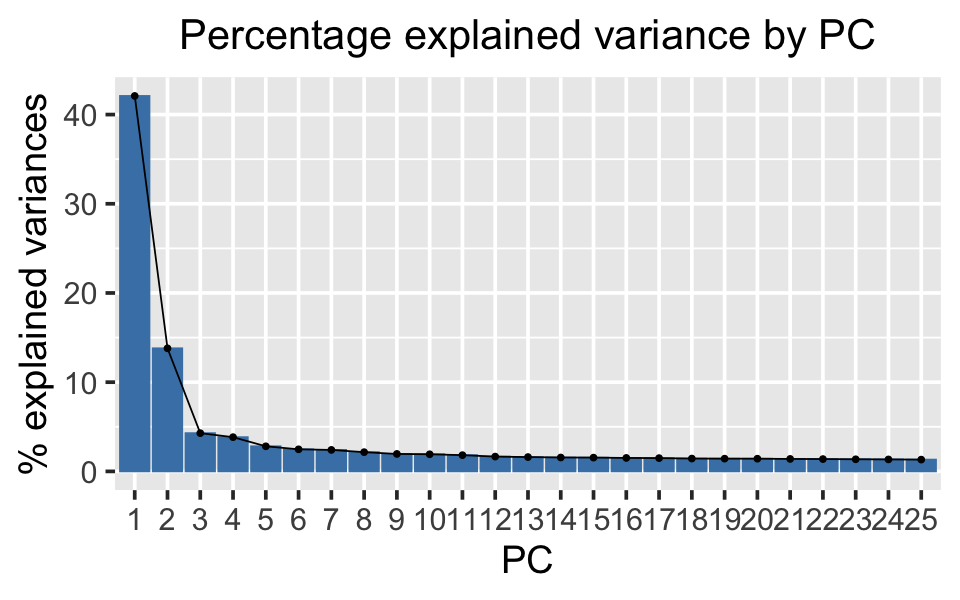

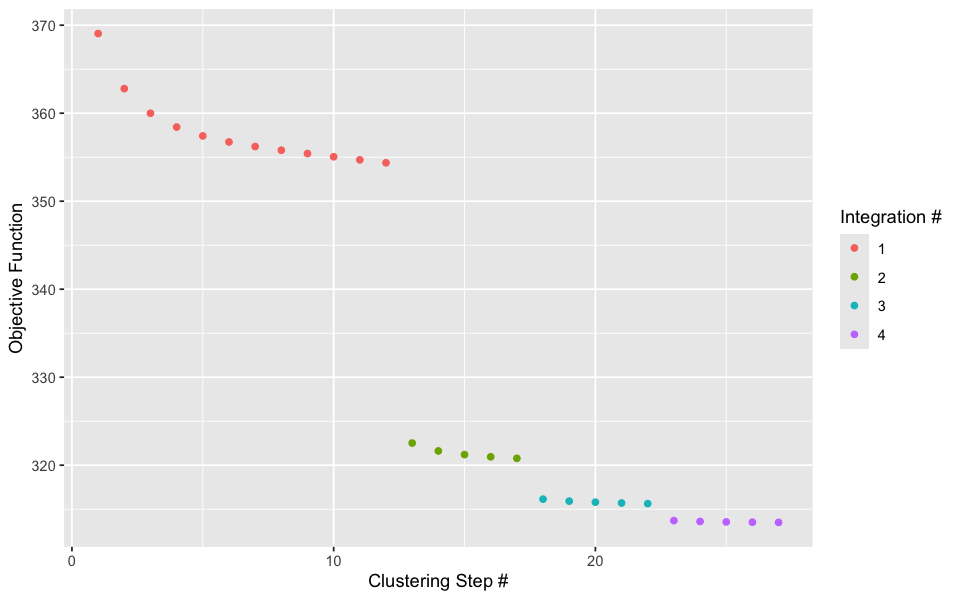

In [162]:
meta_umap_adt_DQB1 = pca_umap(scale_adt_DQB1, meta_ADT_filt, c('MainCondition'), c('DQB1'), 
                            harmony_var = 'Condition')

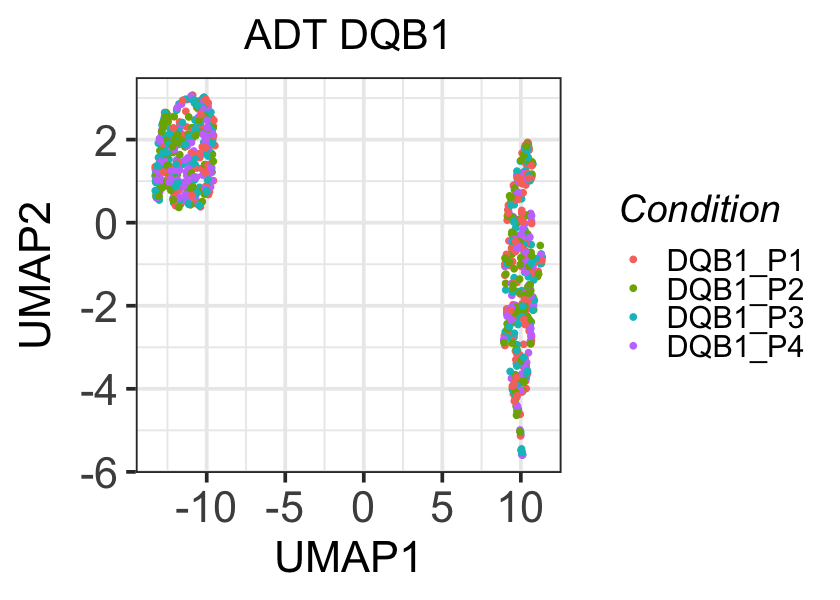

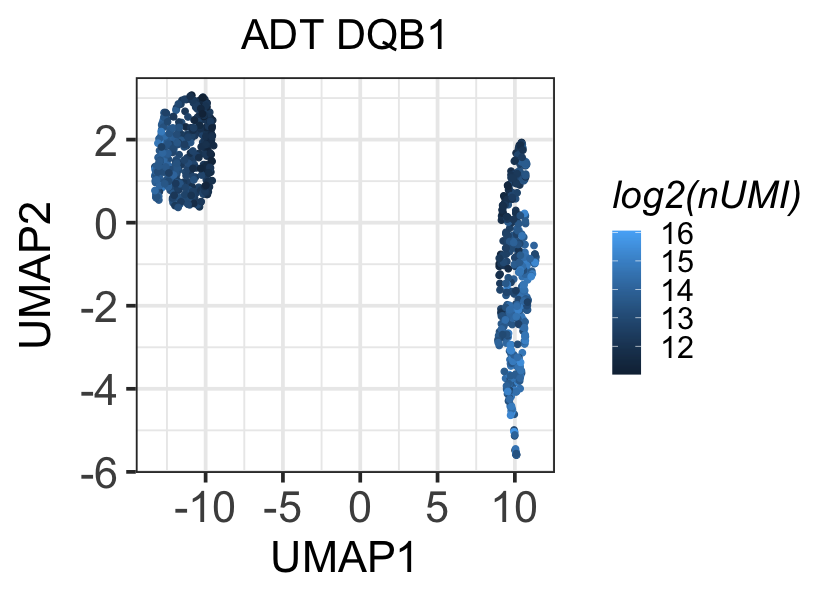

In [163]:
fig.size(5, 7)
ggplot(meta_umap_adt_DQB1 %>% sample_n(nrow(meta_umap_adt_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('ADT DQB1')

fig.size(5, 7)
ggplot(meta_umap_adt_DQB1 %>% sample_n(nrow(meta_umap_adt_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log2(nUMI)))+
    theme_gy()+
    ggtitle('ADT DQB1')

## FBXO11 data is analyzed in the joint analysis in a separate notebook.

## PTEN RNA

In [69]:
source("/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/DNA_filtering_Functions.R")

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



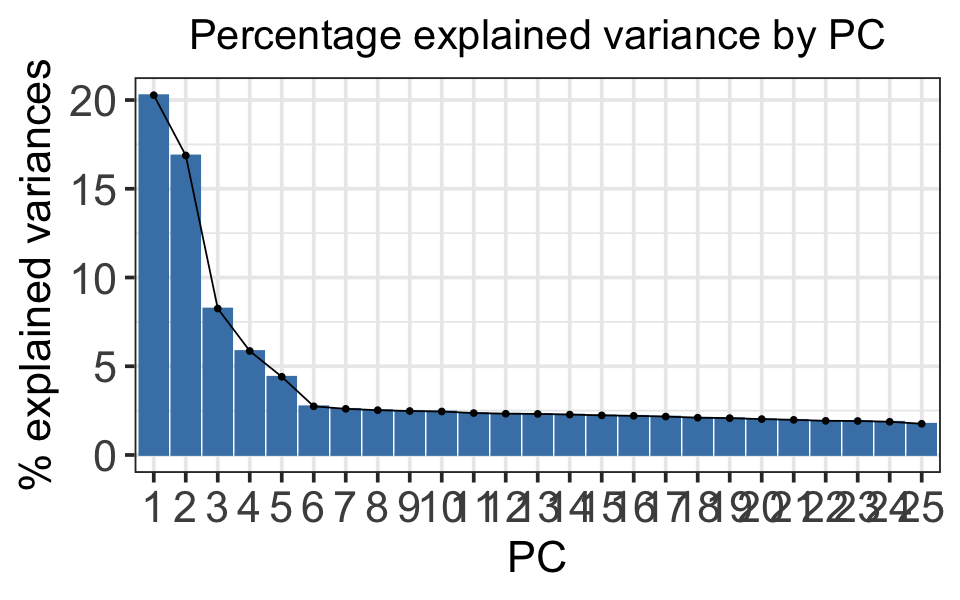

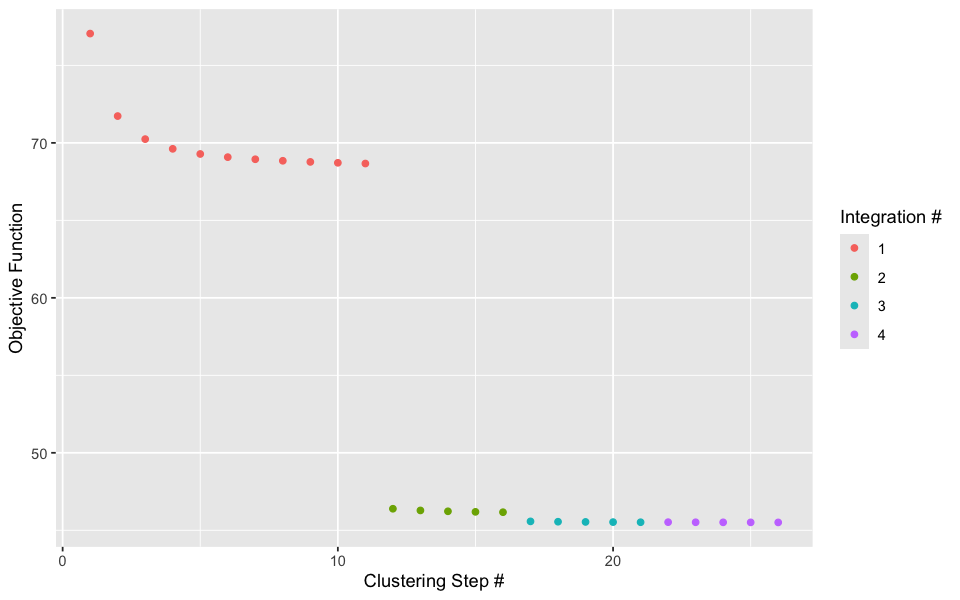

In [81]:
meta_umap_JDHEK = pca_umap(scale_exprs_JDHEK, meta, c('MainCondition'), c('JDHEK'), harmony_var = 'Condition')

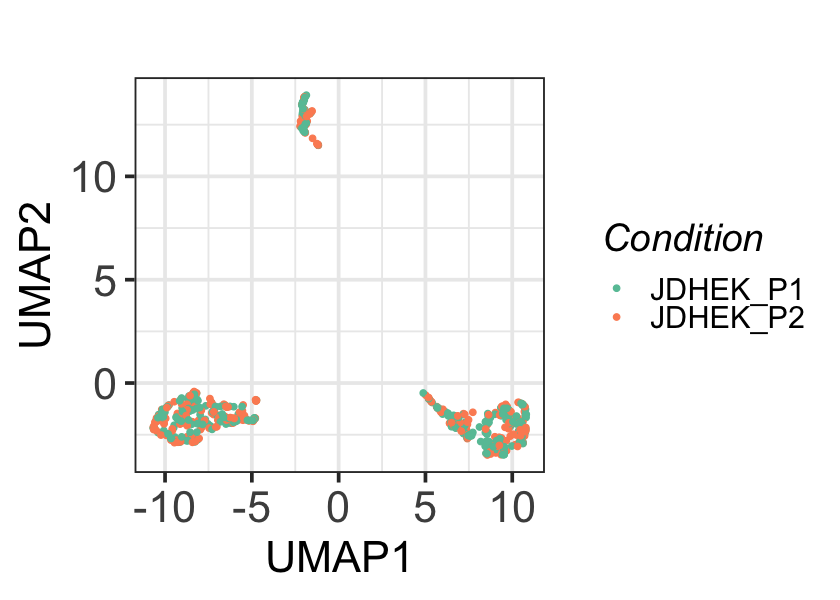

In [82]:
fig.size(5, 7)
ggplot(meta_umap_JDHEK %>% sample_n(nrow(meta_umap_JDHEK)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('') + scale_color_brewer(palette = "Set2")

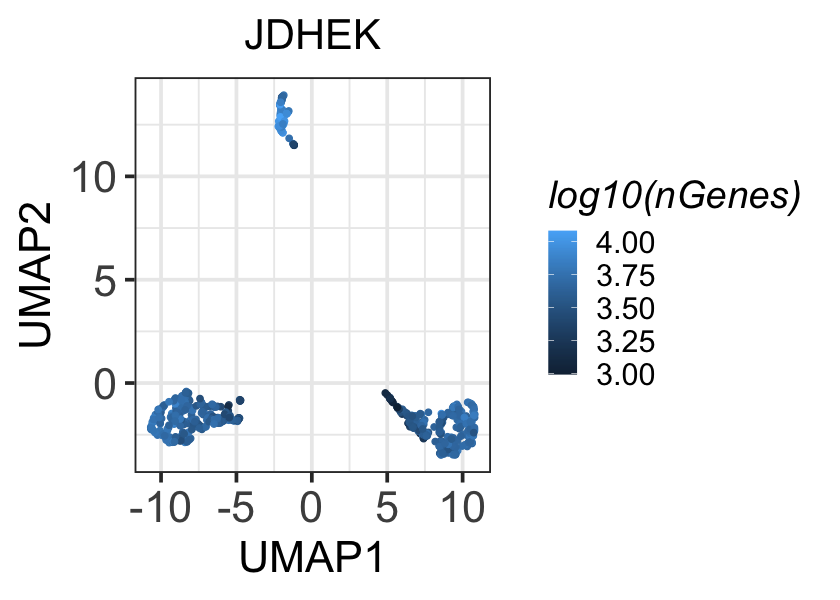

In [84]:
fig.size(5, 7)
ggplot(meta_umap_JDHEK %>% sample_n(nrow(meta_umap_JDHEK)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nGenes)))+
    theme_gy()+
    ggtitle('JDHEK')

## PTEN ADT

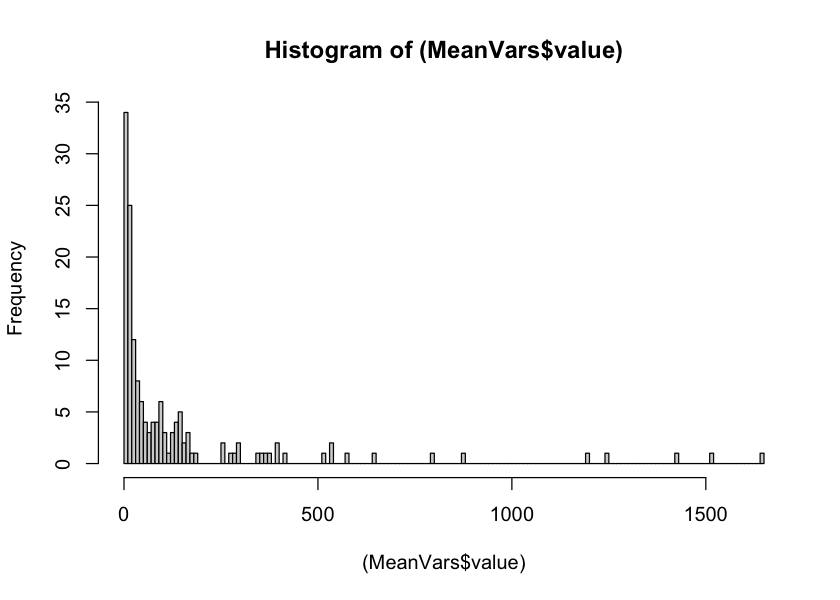

In [85]:
#Calcuate Variance over Mean (too high indicates that the expression is low and variance is too high)
library(EnvStats) #Load outlier library
counts_PTEN <- counts_ADT_filt[,meta_ADT_filt %>% filter(MainCondition == "JDHEK") %>% with(cell)]

MeanVars <- (rowVars(as.matrix(counts_PTEN))/ rowMeans(counts_PTEN)) %>% as_tibble(rownames = "gene") %>% arrange(-value)
hist((MeanVars$value), breaks = length(MeanVars$value)) #estimate outliers based on distributions
#Clearly two outlies

In [86]:
#set K
outliers <- rosnerTest(MeanVars$value, k = 5) %>% with(all.stats) %>% with(Obs.Num) #identify outliers with rosnerTest
genes <- MeanVars$gene[-outliers] # remove outliers

In [87]:
counts_PTEN <- counts_PTEN[genes,] # remove outliers

In [88]:
scale_adt_JDHEK = process_adt(counts_PTEN, meta_ADT_filt, c('MainCondition'), c('JDHEK'))

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



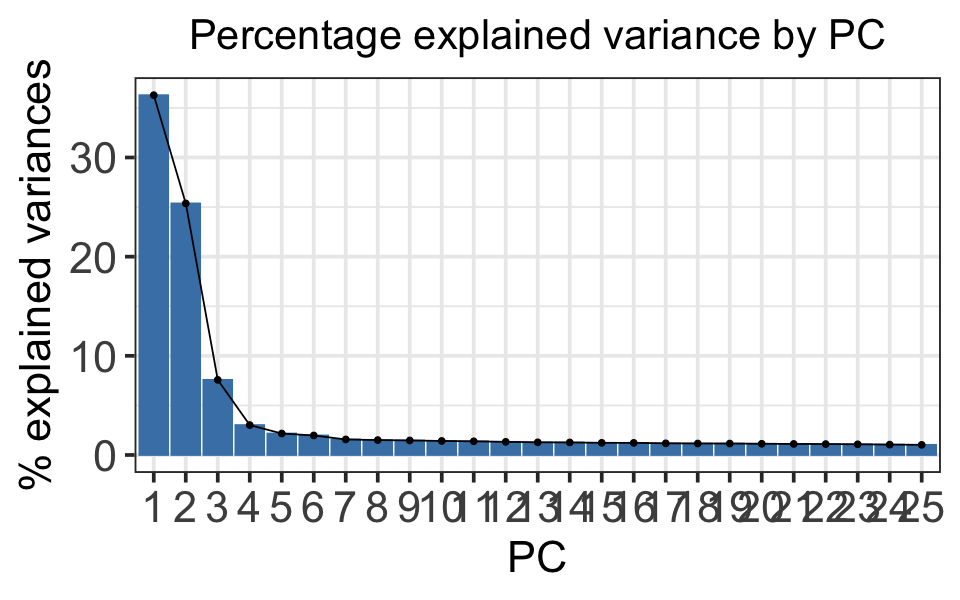

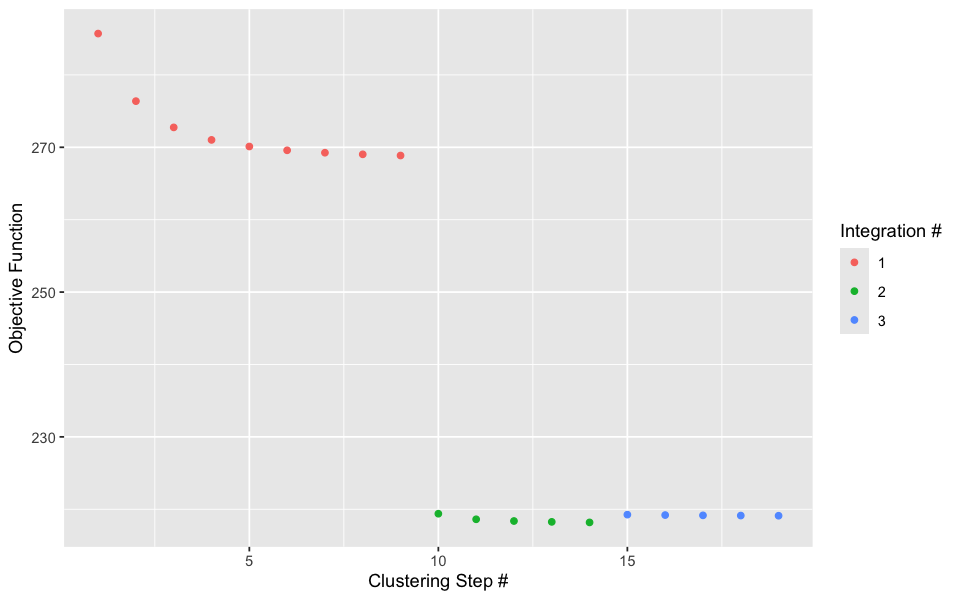

In [89]:
meta_umap_adt_JDHEK = pca_umap(scale_adt_JDHEK, meta_ADT_filt, c('MainCondition'), c('JDHEK'), 
                            harmony_var = 'Condition')

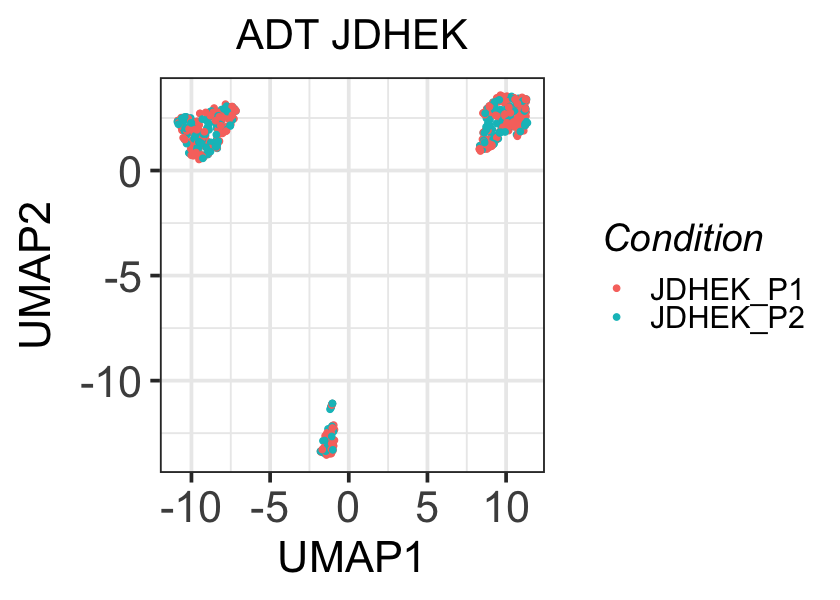

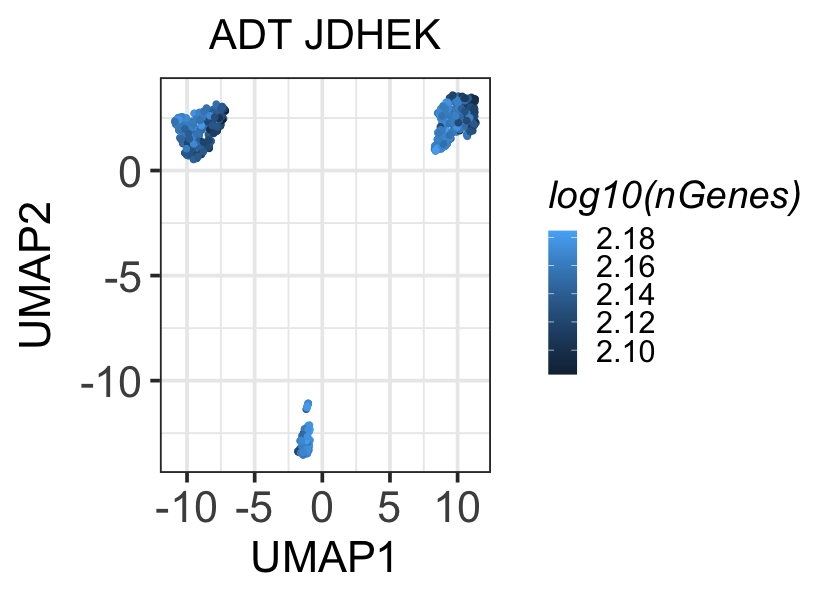

In [90]:
fig.size(5, 7)
ggplot(meta_umap_adt_JDHEK %>% sample_n(nrow(meta_umap_adt_JDHEK)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('ADT JDHEK')

fig.size(5, 7)
ggplot(meta_umap_adt_JDHEK %>% sample_n(nrow(meta_umap_adt_JDHEK)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nGenes)))+
    theme_gy()+
    ggtitle('ADT JDHEK')

# Clustering + broad differential gene expression analysis. 

## DQB1

In [139]:
meta_umap_DQB1.clust = do_cluster(meta_umap_DQB1, resolution_list = seq(0.05, 0.5, 0.05))
table(meta_umap_DQB1.clust$`res.0.1`)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28582

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9748
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28582

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9504
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28582

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9270
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 909
Number of edges: 28582

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9048
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version


  0   1   2 
485 400  24 

In [140]:
meta_umap_DQB1.clust$cluster = meta_umap_DQB1.clust$`res.0.1` # set cluster identity

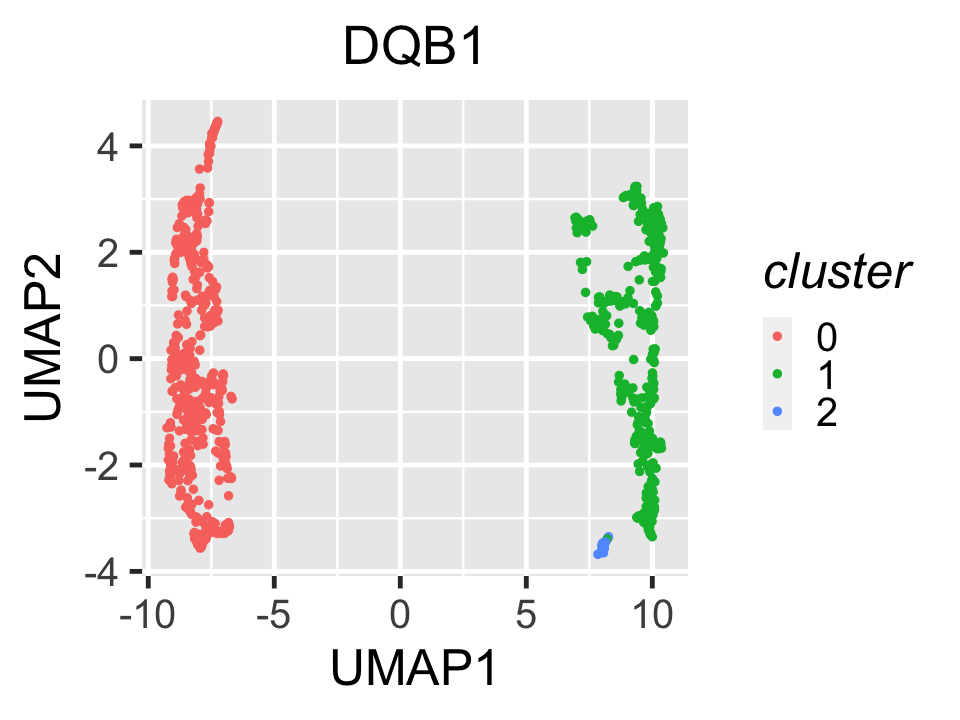

In [141]:
fig.size(6, 8)
ggplot(meta_umap_DQB1.clust[sample(rownames(meta_umap_DQB1.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1')

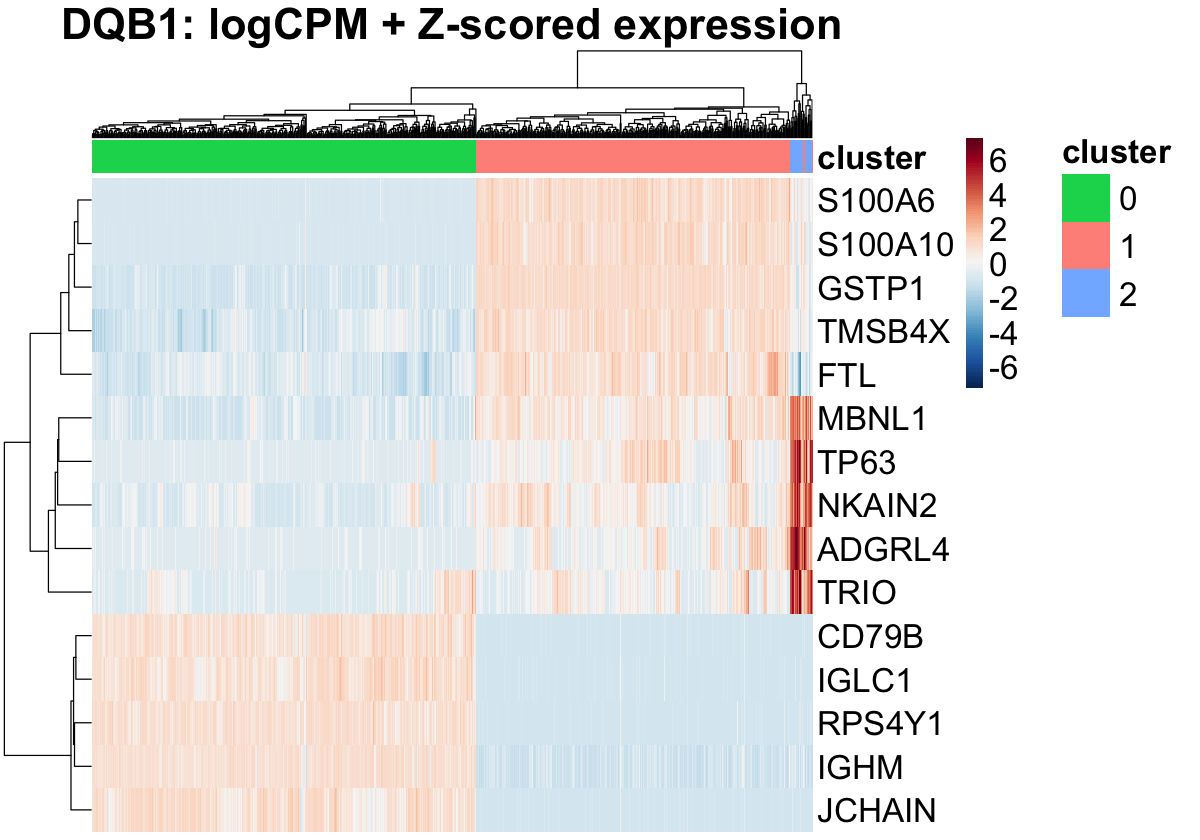

In [142]:
#plot heatmap of top differentially expressed genes. 
dge_DQB1 = wilcoxauc(scale_exprs_DQB1, meta_umap_DQB1.clust$cluster)

var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs_DQB1[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_DQB1.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_DQB1.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs_DQB1[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs_DQB1[var_genes_DQB1, ])))


fig.size(7, 10)
pheatmap(scale_exprs_DQB1[c(var_genes_DQB1,"HLA-DQB1"), ],
         main = 'DQB1: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

### ADT

In [715]:
meta_umap_adt_DQB1.clust = do_cluster(meta_umap_adt_DQB1, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 843
Number of edges: 33105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9496
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 843
Number of edges: 33105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 843
Number of edges: 33105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8561
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 843
Number of edges: 33105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8201
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [716]:
meta_umap_adt_DQB1.clust$cluster = meta_umap_adt_DQB1.clust$`res.0.1`

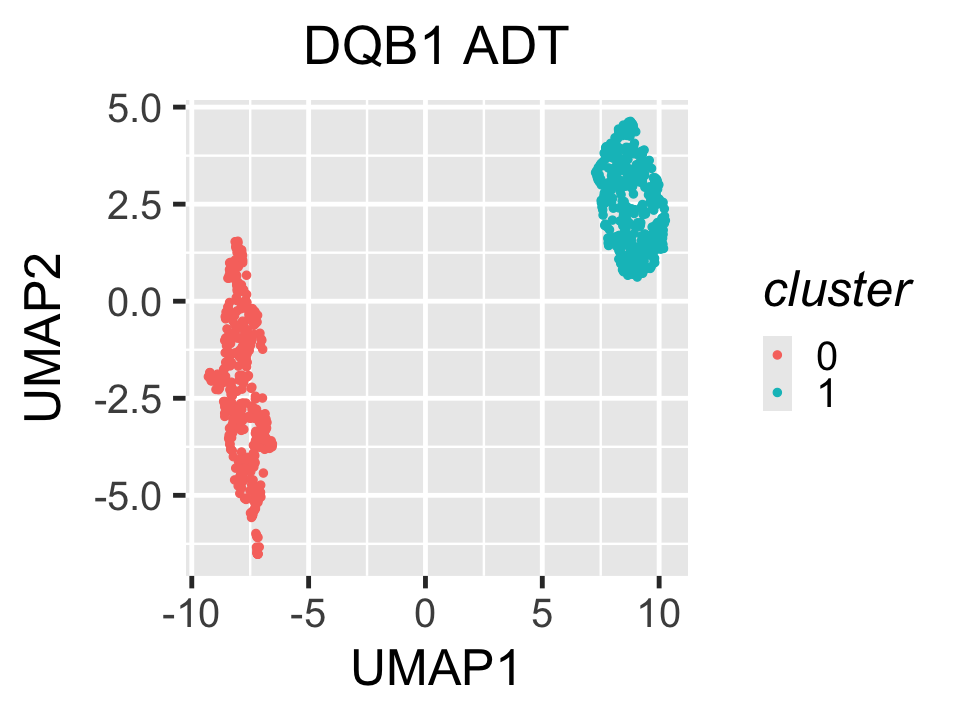

In [717]:
fig.size(6, 8)
ggplot(meta_umap_adt_DQB1.clust[sample(rownames(meta_umap_adt_DQB1.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1 ADT')

In [148]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_DQB1.clust), rownames(meta_umap_DQB1.clust))
concordance_RNAprot_DQB1 = table(meta_umap_adt_DQB1.clust[intersect_cells, 'cluster'],
                                 meta_umap_DQB1.clust[intersect_cells, 'cluster']) %>% as.data.frame

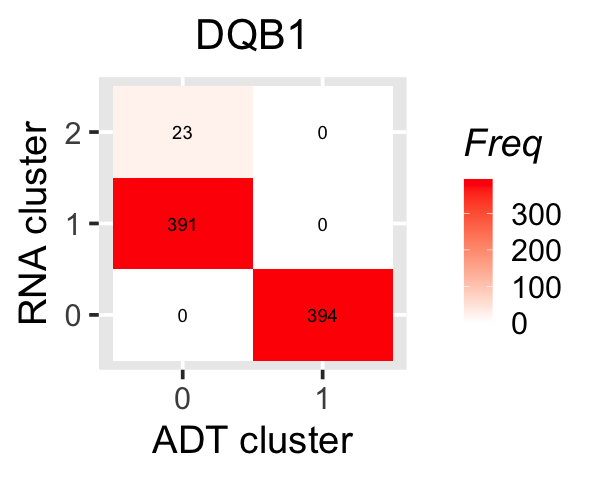

In [150]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_DQB1.clust), rownames(meta_umap_DQB1.clust))
concordance_RNAprot_DQB1 = table(meta_umap_adt_DQB1.clust[intersect_cells, 'cluster'],
                                 meta_umap_DQB1.clust[intersect_cells, 'cluster']) %>% as.data.frame

fig.size(4, 5)
ggplot(concordance_RNAprot_DQB1)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_g()+
    xlab('ADT cluster')+
    ylab('RNA cluster')+
    ggtitle('DQB1')

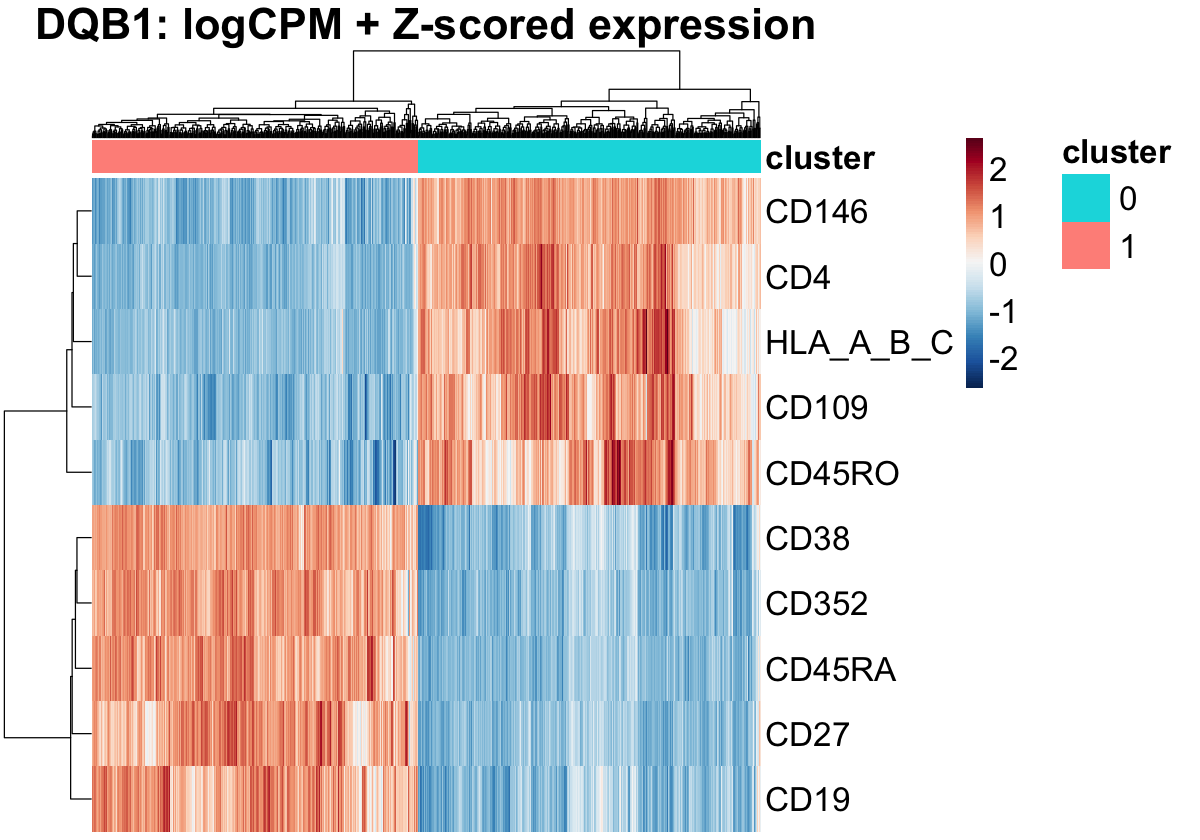

In [151]:
#Heatmap of variable genes
dge_DQB1 = wilcoxauc(scale_adt_DQB1, meta_umap_adt_DQB1.clust$cluster)
var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt_DQB1[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt_DQB1.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt_DQB1.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt_DQB1[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt_DQB1[var_genes_DQB1, ])))
fig.size(7, 10)
pheatmap(scale_adt_DQB1[c(var_genes_DQB1), ],
         main = 'DQB1: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

## FBXO11 is performed in a separate join analysis workbook

## PTEN

In [100]:
source("/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/DNA_filtering_Functions.R")

In [102]:
meta_umap_JDHEK.clust = do_cluster(meta_umap_JDHEK, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 593
Number of edges: 17930

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9579
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 593
Number of edges: 17930

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9196
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 593
Number of edges: 17930

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8816
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 593
Number of edges: 17930

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8549
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version

In [103]:
table(meta_umap_JDHEK.clust$'res.0.2')


  0   1   2 
267 257  69 

In [104]:
meta_umap_JDHEK.clust$cluster = meta_umap_JDHEK.clust$`res.0.2`

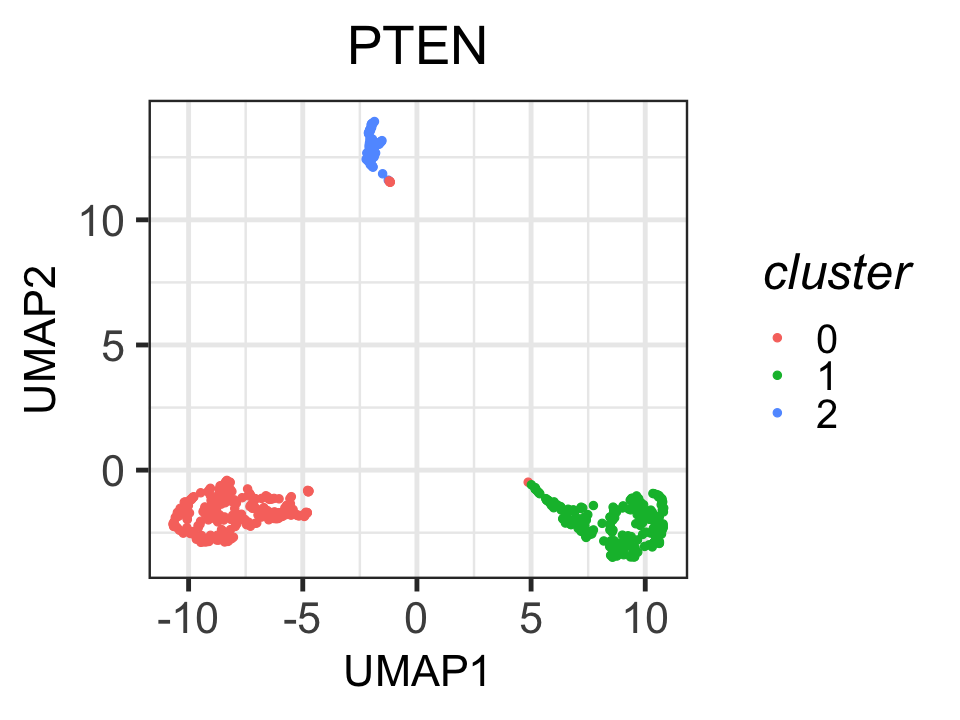

In [108]:
fig.size(6, 8)
ggplot(meta_umap_JDHEK.clust[sample(rownames(meta_umap_JDHEK.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_gy(30)+
    ggtitle('PTEN')

In [109]:
dge_JDHEK = wilcoxauc(scale_exprs_JDHEK, meta_umap_JDHEK.clust$cluster)

In [110]:
top_markers(dge_JDHEK, 50) %>% head(10)

rank 0     1       2     
1   1   TRBC1 IGHM    CKB   
2   2   CD3D  CD74    TSPO  
3   3   ADA   IGKC    NHP2  
4   4   GYPC  CD37    RASAL2
5   5   SOX4  IGLC1   BEX3  
6   6   AIF1  SNHG31  NME3  
7   7   LCK   TCL1A   PHGDH 
8   8   IL32  HLA-DRA TIMP1 
9   9   CD3E  CD79B   ANXA5 
10 10   IDH2  LTB     PGRMC1

### ADT

In [111]:
meta_umap_adt_JDHEK.clust = do_cluster(meta_umap_adt_JDHEK, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 537
Number of edges: 21770

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9607
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 537
Number of edges: 21770

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9230
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 537
Number of edges: 21770

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8853
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 537
Number of edges: 21770

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8476
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [112]:
table(meta_umap_adt_JDHEK.clust$'res.0.1')


  0   1   2 
234 226  77 

In [113]:
meta_umap_adt_JDHEK.clust$cluster = meta_umap_adt_JDHEK.clust$`res.0.1`

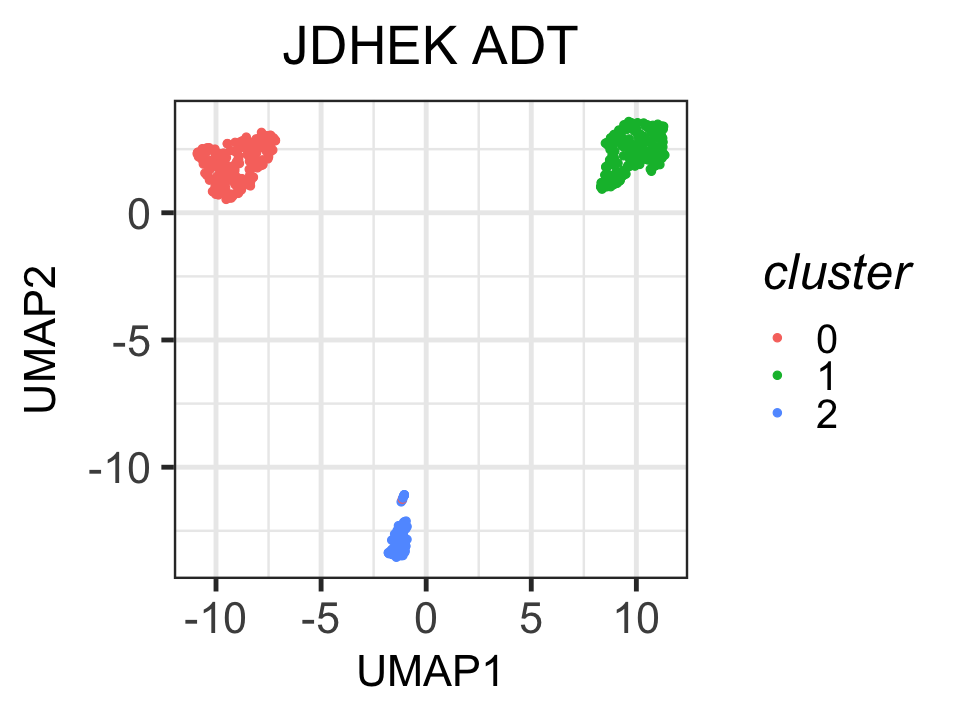

In [114]:
fig.size(6, 8)
ggplot(meta_umap_adt_JDHEK.clust[sample(rownames(meta_umap_adt_JDHEK.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_gy(30)+
    ggtitle('JDHEK ADT')

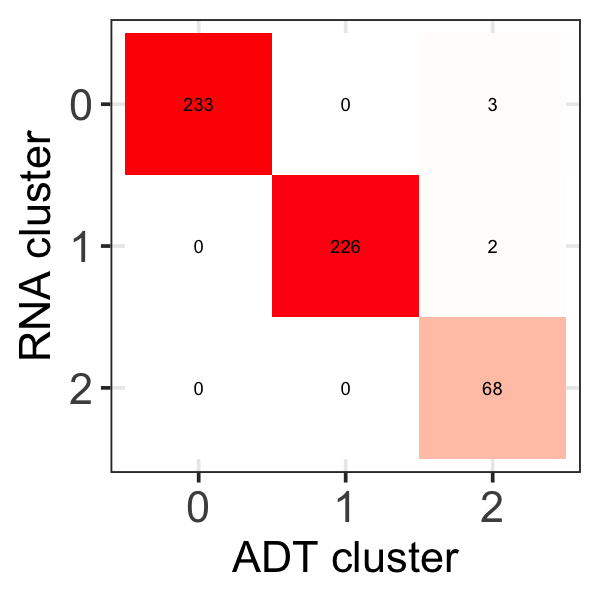

In [116]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_JDHEK.clust), rownames(meta_umap_JDHEK.clust))
concordance_RNAprot_JDHEK = table(meta_umap_adt_JDHEK.clust[intersect_cells, 'cluster'],
                                 meta_umap_JDHEK.clust[intersect_cells, 'cluster']) %>% as.data.frame

# Order clusters in plot
concordance_RNAprot_JDHEK$Var2 = factor(concordance_RNAprot_JDHEK$Var2, 
                                       levels = c(2, 1, 0))
concordance_RNAprot_JDHEK$Var1 = factor(concordance_RNAprot_JDHEK$Var1, 
                                       levels = c(0, 1, 2))

fig.size(5, 5)
ggplot(concordance_RNAprot_JDHEK)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_gy()+
    xlab('ADT cluster')+
    ylab('RNA cluster') + theme(legend.position = "none")

# Combine Modalities

In [221]:
##full normalized and scaled expression
filt_norm_scale_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log") %>% 
    singlecellmethods::scaleData()

In [222]:
#normalized expression
norm_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log")

## PTEN - Merge Modalities. A meta file will be supplied with the most pertinent information

In [117]:
##Merge all three data sets
PTENplots <- PTEN_genotypes %>% rename(Well = "Well_ID") %>% 
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
    mutate("cell" = paste0(RNA_cell, "_", Barcode_RNA)) %>% 
    inner_join(select(meta_umap_adt_JDHEK.clust, cell, cluster, UMAP1, UMAP2)) %>% 
    inner_join(select(meta_umap_JDHEK.clust, cell, cluster, UMAP1, UMAP2), by = "cell") %>% 
    mutate("Genotype" = paste0("G",genotype))

##Add FlowData to this. 
PTENplots2 <- FlowMatrix %>%
    mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>% 
    mutate(Condition = paste0(Experiment_Index, "_", Plate))  %>%
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode, "_", Barcode_RNA)) %>% 
    inner_join(PTENplots) %>% na.omit

#Save meta data files
PTENplots2 %>% write_csv("PTENplots2.csv")
PTENplots2<- read_csv("PTENplots2.csv")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rename': object 'PTEN_genotypes' not found


In [118]:
PTENplots2<- read_csv("PTENplots2.csv")

Rows: 510 Columns: 35
── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (19): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11...
dbl (16): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## PTEN plot alleles

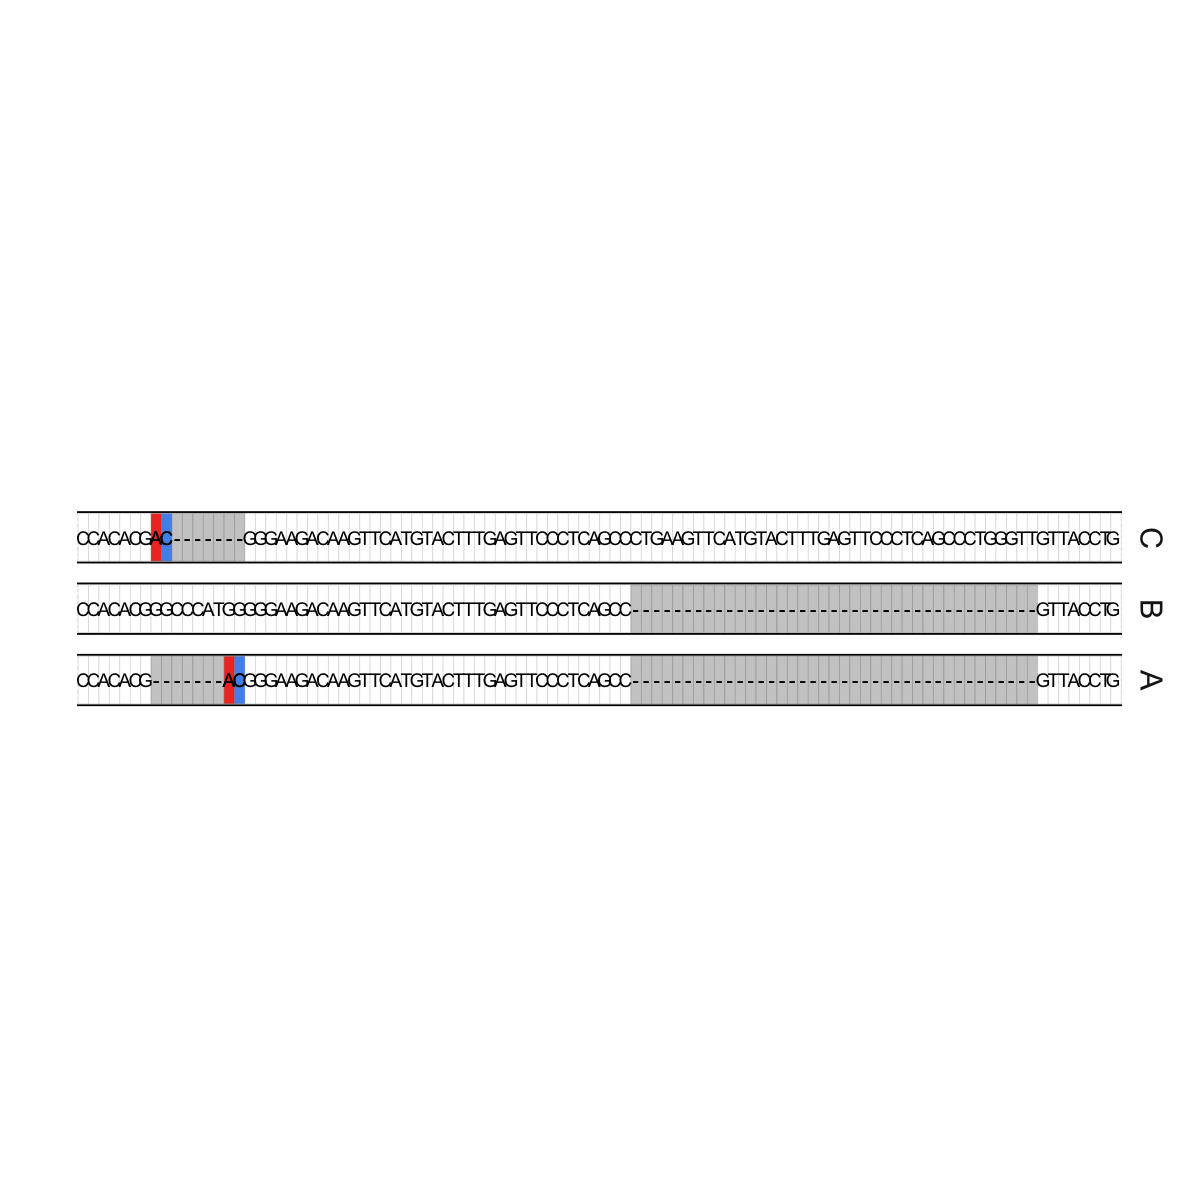

In [224]:
Plotting_Alleles(PTEN_filt_allele) # Plot all alleles. 

In [225]:
PTENplots2<- PTENplots2 %>% mutate(plate_well = paste0(Barcode_DNA, Well_ID)) %>% inner_join(select(PTEN_genotypes, AllelicGenotype, plate_well))

Joining with `by = join_by(plate_well)`


Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` (with slightly different semantics) to convert to a
  tibble, or `as.data.frame()` to convert to a data frame.”


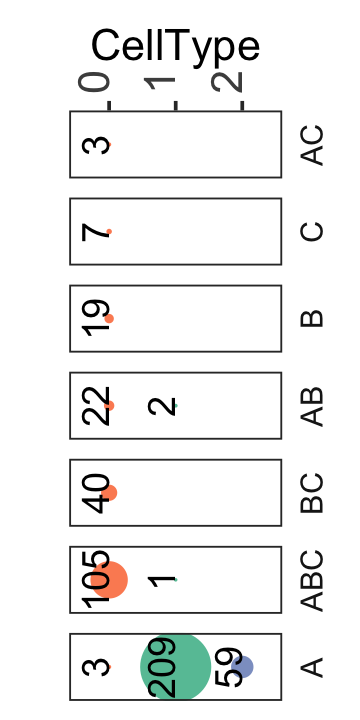

In [226]:
## Plot of PTEN genotypes distributions across RNA clusters
## Define df for plotting 
test2 <- PTENplots2 %>% add_count(AllelicGenotype,name = "genotype_count") %>% 
    filter(genotype_count  > 2)

#Defineplotting Order
order <- test2$AllelicGenotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,3)
g <- 

table(test2$AllelicGenotype,test2$cluster.x) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =8, angle = 90, vjust = 0 )+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = order)~ .) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        ) +scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62')) + 
    theme(strip.text.y.right = element_text(angle = 90))
    
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "PTEN_Genotypes.png", device = "png", dpi = 300, width = 3, height = 6)
    })

## PTEN comparison to bulk

In [227]:
#Bulk plot - single cell comparison
PTENplots2 %>% select(Barcode_DNA, Well_ID, cluster.x) %>% filter(cluster.x == 0) %>% inner_join(PTEN_filt_allele) %>% select( Aligned_Sequence, `%Reads`, plate_well) %>%
    
    group_by(plate_well) %>% mutate(Percent = `%Reads`/sum(`%Reads`)*100) %>% ungroup() %>% group_by(Aligned_Sequence) %>% 
    summarize(Percent = mean(Percent)) %>% as.data.frame() %>% cbind("Allele" = c("A","B","C")) %>% arrange(-Percent)

Joining with `by = join_by(Barcode_DNA, Well_ID)`


Aligned_Sequence                                                                                    
1 CCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTG
2 CCACACGAC-------GGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG
3 CCACACG-------ACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTG
  Percent  Allele
1 57.70188 C     
2 37.38199 B     
3 24.92887 A

Joining with `by = join_by(Barcode_DNA, Well_ID)`


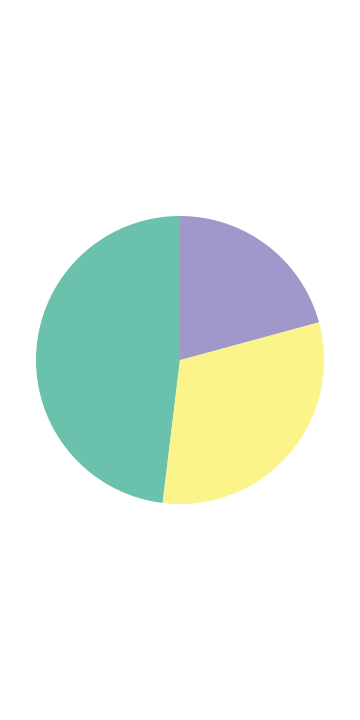

In [228]:
#Bulk plot - single cell comparison
PTENplots2 %>% select(Barcode_DNA, Well_ID, cluster.x) %>% filter(cluster.x == 0) %>% inner_join(PTEN_filt_allele) %>% select( Aligned_Sequence, `%Reads`, plate_well) %>%
    
    group_by(plate_well) %>% mutate(Percent = `%Reads`/sum(`%Reads`)*100) %>% ungroup() %>% group_by(Aligned_Sequence) %>% 
    summarize(Percent = mean(Percent)) %>% as.data.frame()%>% arrange(-Percent) %>% cbind("Allele" = c("A","B","C")) %>%

ggplot(aes(x="", y=Percent, fill=Allele)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) + 
theme_void() + theme(legend.position = "none") + scale_fill_manual(values = c("A" = "#7ACBBA", "B" = "#FBF49C", "C" = "#B0AAD4"))

## PTEN -concordance

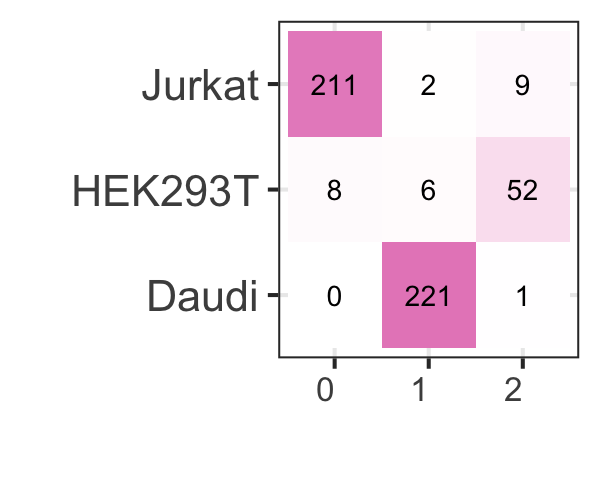

In [121]:
# Compare cluster concordance in ADT vs Flow
concordance_RNAprot_JDHEK = table(PTENplots2$cluster.x,
                                 PTENplots2$PTEN_CellType_Index2) %>% as.data.frame


fig.size(4,5)
ggplot(concordance_RNAprot_JDHEK)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq), size = 6) +
    scale_fill_gradient(low = "white", high = "#E78AC3")+
    theme_gy(25) + theme(axis.text.x = element_text(angle = 0, vjust = 1, hjust=1, size = 20)) + 
    xlab("") + ylab("") + theme(legend.position = "none") 

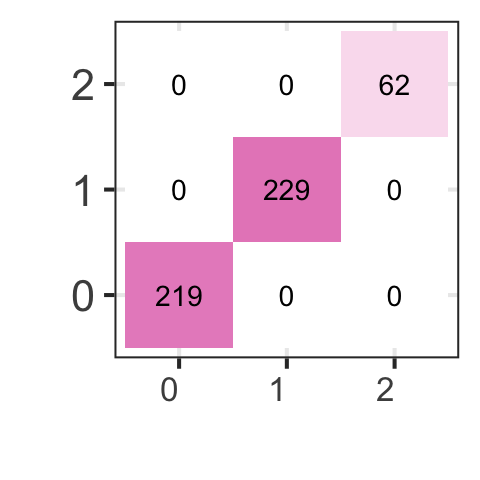

In [122]:
# Compare cluster concordance in ADT vs Flow
concordance_RNAprot_JDHEK = table(PTENplots2$cluster.x,
                                 PTENplots2$cluster.y) %>% as.data.frame

# Order clusters in plot
#concordance_RNAprot_JDHEK$Var2 = factor(concordance_RNAprot_JDHEK$Var2, 
                                       #levels = c("0", "1", "2"))
#concordance_RNAprot_JDHEK$Var1 = factor(concordance_RNAprot_JDHEK$Var1, 
                                       #levels = c(0, 1, 2))

fig.size(4,4)
ggplot(concordance_RNAprot_JDHEK)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq), size = 6) +
    scale_fill_gradient(low = "white", high = "#E78AC3")+
    theme_gy(25) + theme(axis.text.x = element_text(angle = 0, vjust = 1, hjust=1, size = 20)) + 
    xlab("") + ylab("") + theme(legend.position = "none") 

Joining with `by = join_by(cell)`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


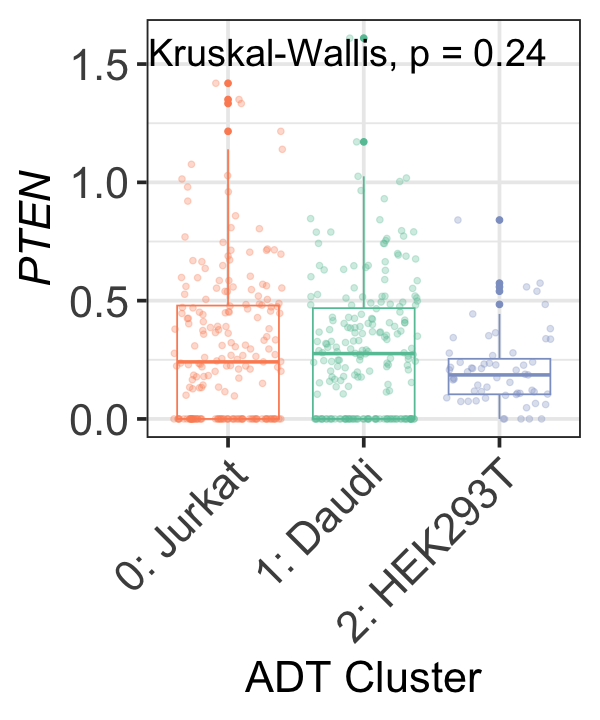

In [236]:
#Normalized expression of PTEN vs ADT cluster
fig.size(6,5)
norm_exprs["PTEN",] %>% as_data_frame(rownames = "cell") %>% 
inner_join(PTENplots2) %>%

ggplot(aes(x = as.factor(cluster.x), y= value, color = as.factor(cluster.x))) + 
geom_boxplot() + geom_jitter(alpha = 0.3) + 
stat_compare_means(size=8, vjust = 1) + theme_gy() + 
labs(color = "ADT cluster") + 
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
      axis.title.y = element_text(face = "italic"), 
      legend.position = "none") +
ylab("PTEN") + xlab("ADT Cluster") + 
scale_x_discrete(labels=c("0" = "0: Jurkat", 
                          "1" = "1: Daudi",
                          "2" = "2: HEK293T")) + 
scale_color_brewer(palette = "Set2")+
scale_color_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))

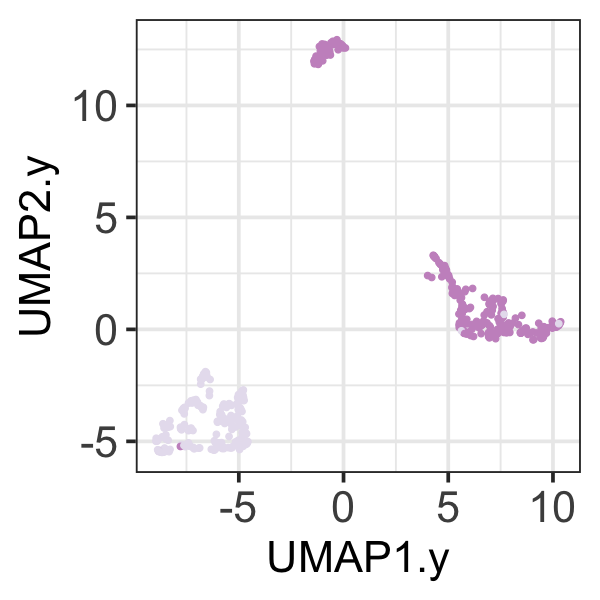

In [237]:
fig.size(5,5)
PTENplots2 %>% 
mutate(Genotype = ifelse(AllelicGenotype =="A", "Reference", "Indels")) %>%
na.omit %>%
ggplot(aes(UMAP1.y, UMAP2.y, color = Genotype)) + 
geom_point() + theme_gy() + 
scale_color_brewer(palette = "PuRd") + 
theme(legend.position = "right", 
     legend.title = element_text(face = "plain" )) + 
labs(color = "Genotype") + theme(legend.position = "none")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


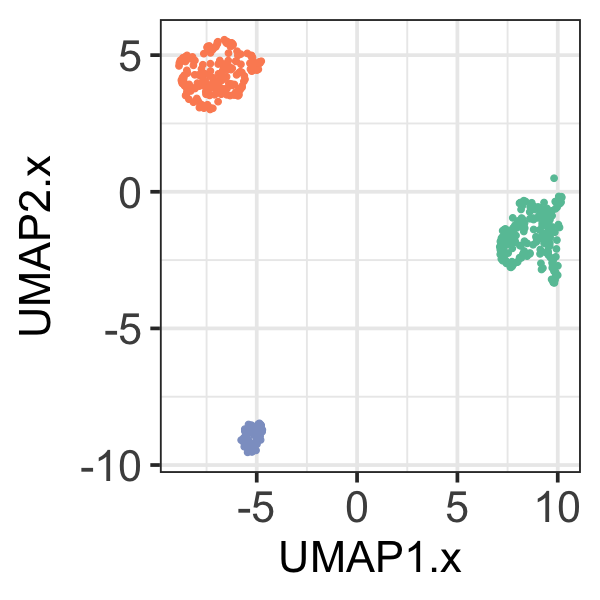

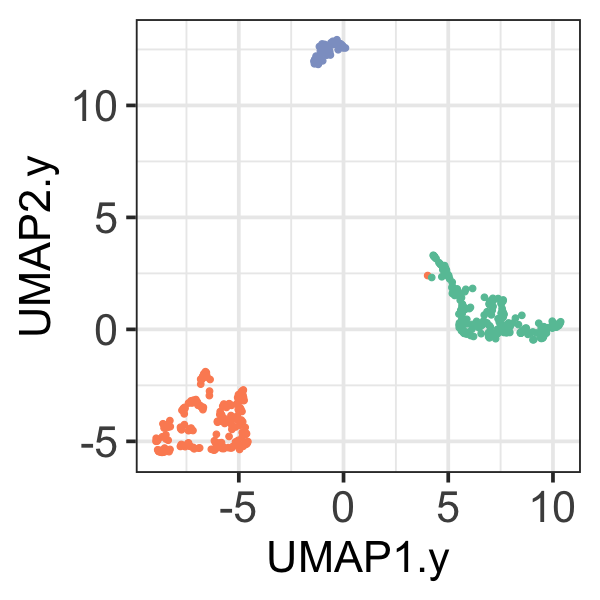

In [241]:
#Replotted with color
fig.size(5,5)
PTENplots2 %>% ggplot(aes(UMAP1.x, UMAP2.x, color = factor(cluster.x))) + 
geom_point() + theme_gy() + 
scale_color_brewer(palette = "Set2") + 
theme(legend.position = "none")+scale_color_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))

fig.size(5,5)
PTENplots2 %>% ggplot(aes(UMAP1.y, UMAP2.y, color = factor(cluster.y))) + 
geom_point() + theme_gy() + 
scale_color_brewer(palette = "Set2") + 
theme(legend.position = "none")+scale_color_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))


Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


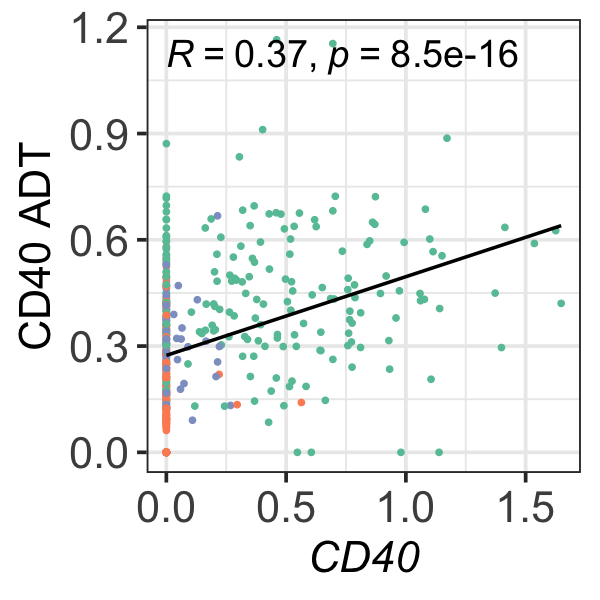

In [246]:
#Correlation plots between flow and adt and RNA
options(scipen = 0)
fig.size(5,5)
norm_exprs["CD40",] %>% as_tibble(rownames = "cell") %>% dplyr::rename("PTPRC" = value) %>% 
inner_join(PTENplots2) %>% inner_join(
t(counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")) %>% as.matrix %>% as_tibble(rownames = "cell")) %>%


ggplot(aes(PTPRC, CD40)) + geom_point(aes(color = as.factor(cluster.x))) + #scale_x_log10()+
stat_cor(size =8,vjust = 1) + 
theme_gy() + 
scale_color_brewer(palette = "Set2") + 
geom_smooth(method = lm, se = F, linetype =1, color = "black") + 
xlab("CD40") + 
ylab("CD40 ADT") + labs(color = "ADT Cluster") + 
    theme(axis.title.x = element_text(face = "italic")) +
theme(legend.position = "none")+
scale_color_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


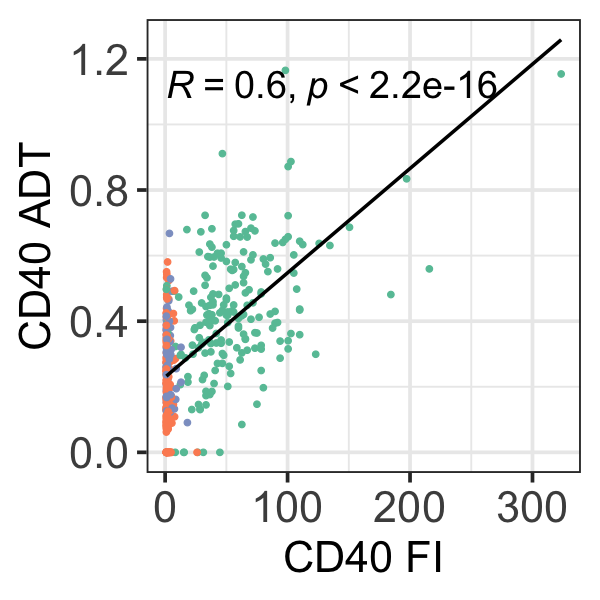

In [247]:
#Correlation plots between flow and adt and RNA
options(scipen = 0)
fig.size(5,5)
norm_exprs["CD40",] %>% as_tibble(rownames = "cell") %>% dplyr::rename("PTPRC" = value) %>% 
inner_join(PTENplots2) %>% inner_join(
t(counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")) %>% as.matrix %>% as_tibble(rownames = "cell")) %>%


ggplot(aes((PE_CD40), CD40)) + geom_point(aes(color = as.factor(cluster.x))) +
stat_cor(size =8,vjust = 1) + 
theme_gy() + 
scale_color_brewer(palette = "Set2") + 
geom_smooth(method = lm, se = F, linetype =1, color = "black") + 
xlab("CD40 FI") + 
ylab("CD40 ADT") + labs(color = "ADT Cluster") + 
    theme(axis.title.x = element_text()) +
theme(legend.position = "none")+
scale_color_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))

## PTEN Plate distributions

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


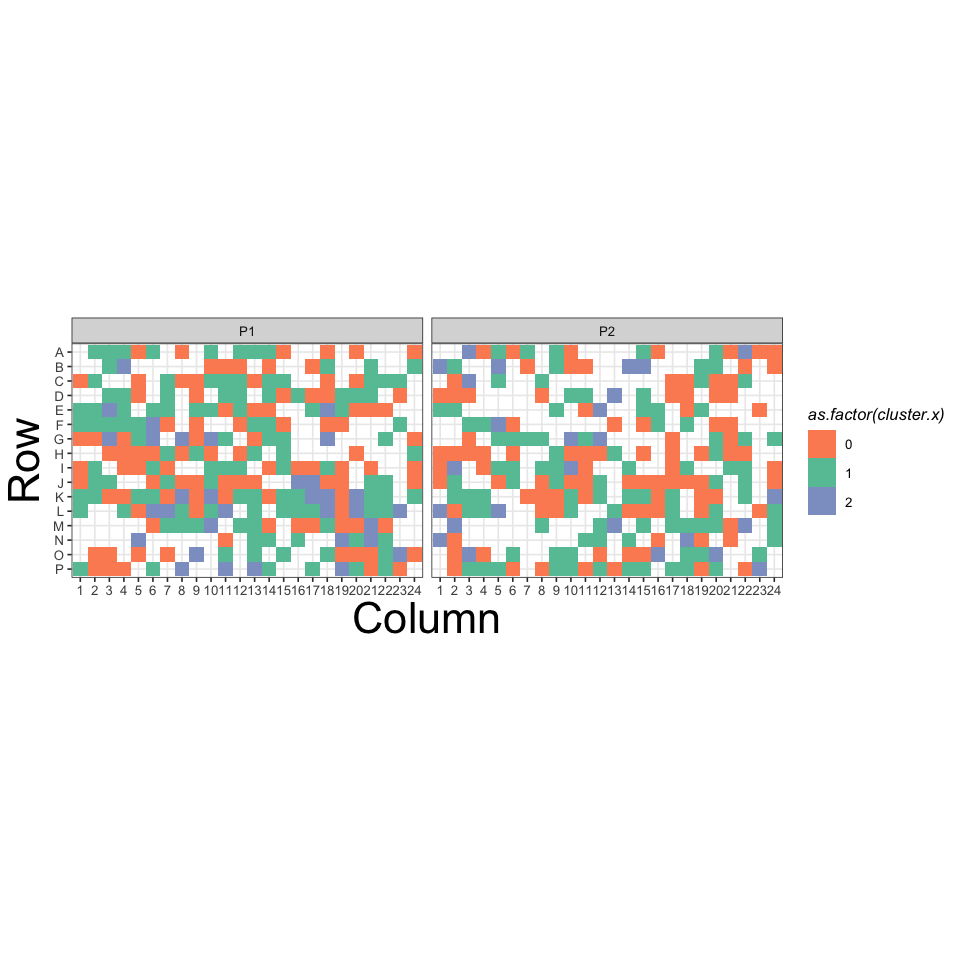

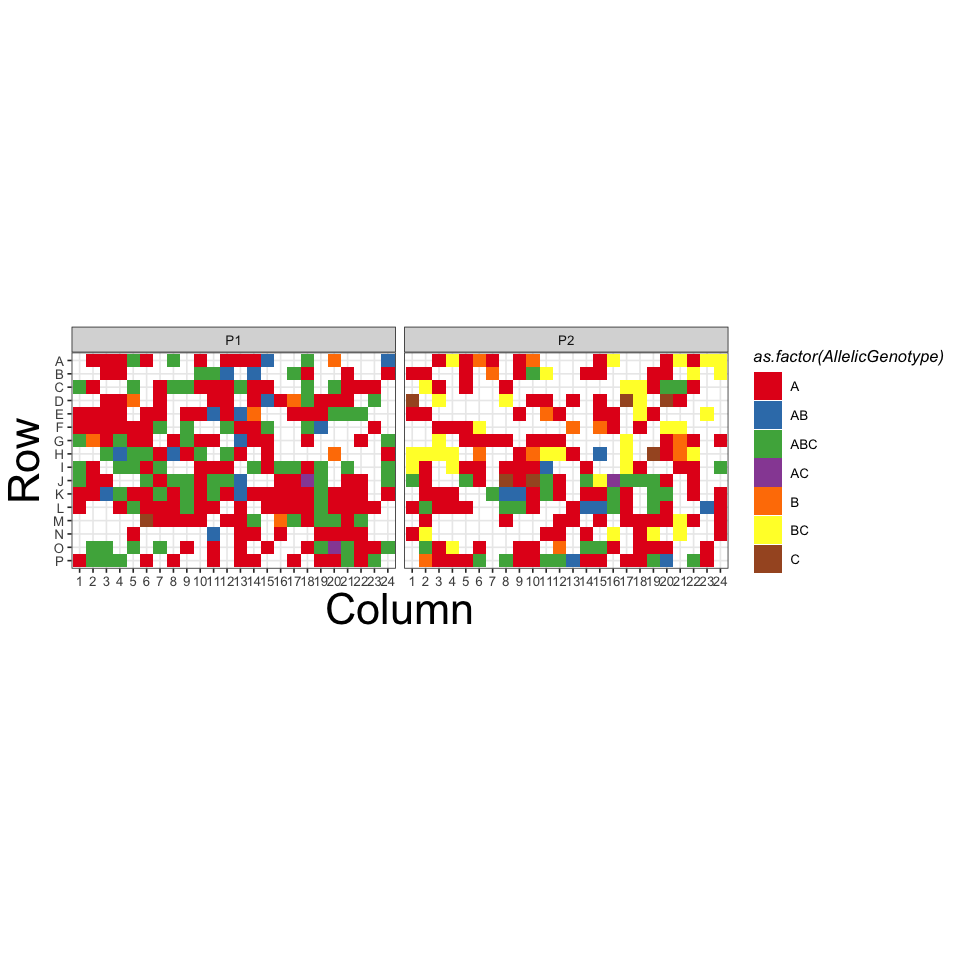

In [256]:
#Plot plate distributions

fig.size(8,8)
g <- PTENplots2 %>% separate(Well_ID, 
                        into = c("Row", "Column"), 
                        sep = "(?<=[A-Za-z])(?=[0-9])") %>% 
    mutate("Column" = factor(Column, levels = c(1:24))) %>%
    mutate("Row"= factor(Row, levels = c(LETTERS[26:1]))) %>% 
    na.omit %>% 
    
ggplot(aes(x = Column, y = Row)) + geom_tile(aes(fill = as.factor(cluster.x))) + facet_wrap(~Plate) + 
    scale_fill_brewer(palette = "Set2") + theme_gy(10) + 
    theme(axis.text.x = element_text(size = 8), 
          axis.text.y = element_text(size = 8),
          aspect.ratio = 16/24)+
scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))
plot(g)
ggsave(g, filename = "ClusterDist.png", device = "png", dpi = 300, width = 9, height = 7)


fig.size(8,8)
g <- PTENplots2 %>% separate(Well_ID, 
                        into = c("Row", "Column"), 
                        sep = "(?<=[A-Za-z])(?=[0-9])") %>% 
    mutate("Column" = factor(Column, levels = c(1:24))) %>%
    mutate("Row"= factor(Row, levels = c(LETTERS[26:1]))) %>% 
    na.omit %>% add_count(genotype) %>% filter(n >2) %>%
    
ggplot(aes(x = Column, y = Row)) + geom_tile(aes(fill = as.factor(AllelicGenotype))) + facet_wrap(~Plate) + 
    scale_fill_brewer(palette = "Set1") + theme_gy(10) + 
    theme(aspect.ratio = 16/24,axis.text.x = element_text(size = 8), 
          axis.text.y = element_text(size = 8))
plot(g)
ggsave(g, filename = "GenotypeDist.png", device = "png", dpi = 300, width = 9, height = 7)


Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


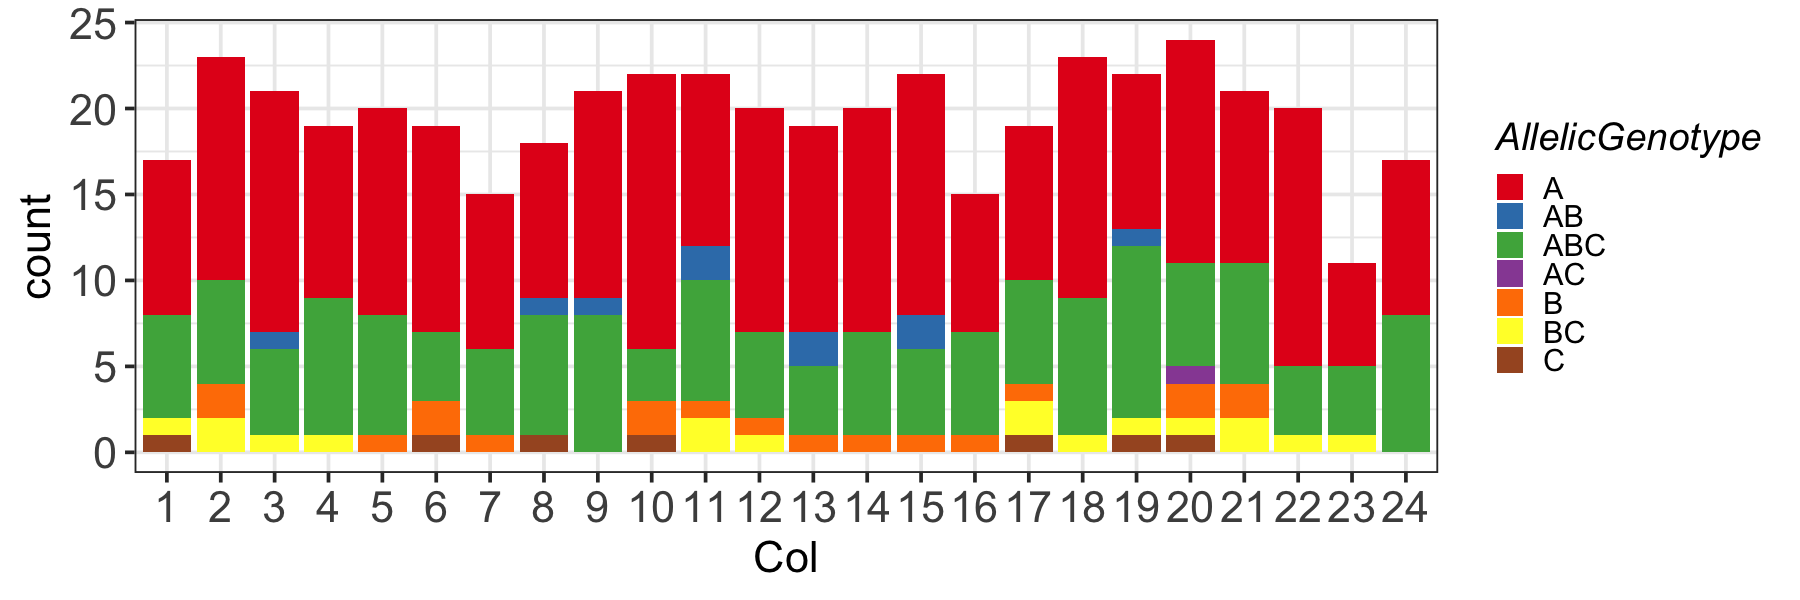

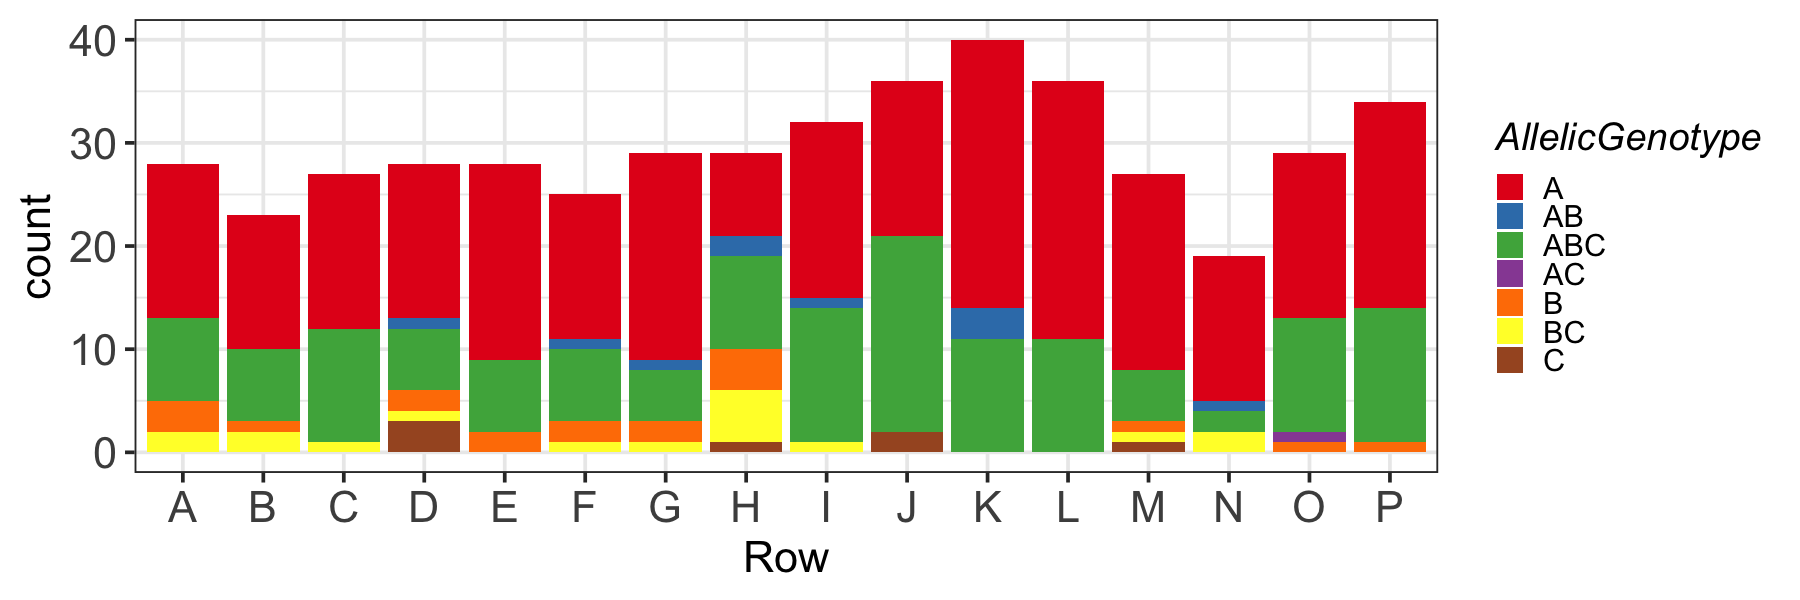

In [697]:
df <- PTENplots2 %>% select(Well_ID, AllelicGenotype) %>% mutate(Col = str_extract(Well_ID, "[0-9]+"),
         Row = str_extract(Well_ID, "[A-Za-z]+"))
#df %>% select(-Well_ID, -AllelicGenotype)  %>% table %>% as.data.frame() %>% ggplot(aes(Row, Col)) + geom_tile(aes(fill = Freq))
fig.size(5,15)
df$Col <- factor(df$Col, levels = 1:24)
df  %>% ggplot(aes(x = Col, fill=AllelicGenotype)) + geom_histogram(stat = "count") + theme_gy()+ scale_fill_brewer(palette = "Set1")

fig.size(5,15)
df$Col <- factor(df$Col, levels = 1:24)
df  %>% ggplot(aes(x = Row, fill=AllelicGenotype)) + geom_histogram(stat = "count") + theme_gy()+ scale_fill_brewer(palette = "Set1")

## PTEN heatmap plots

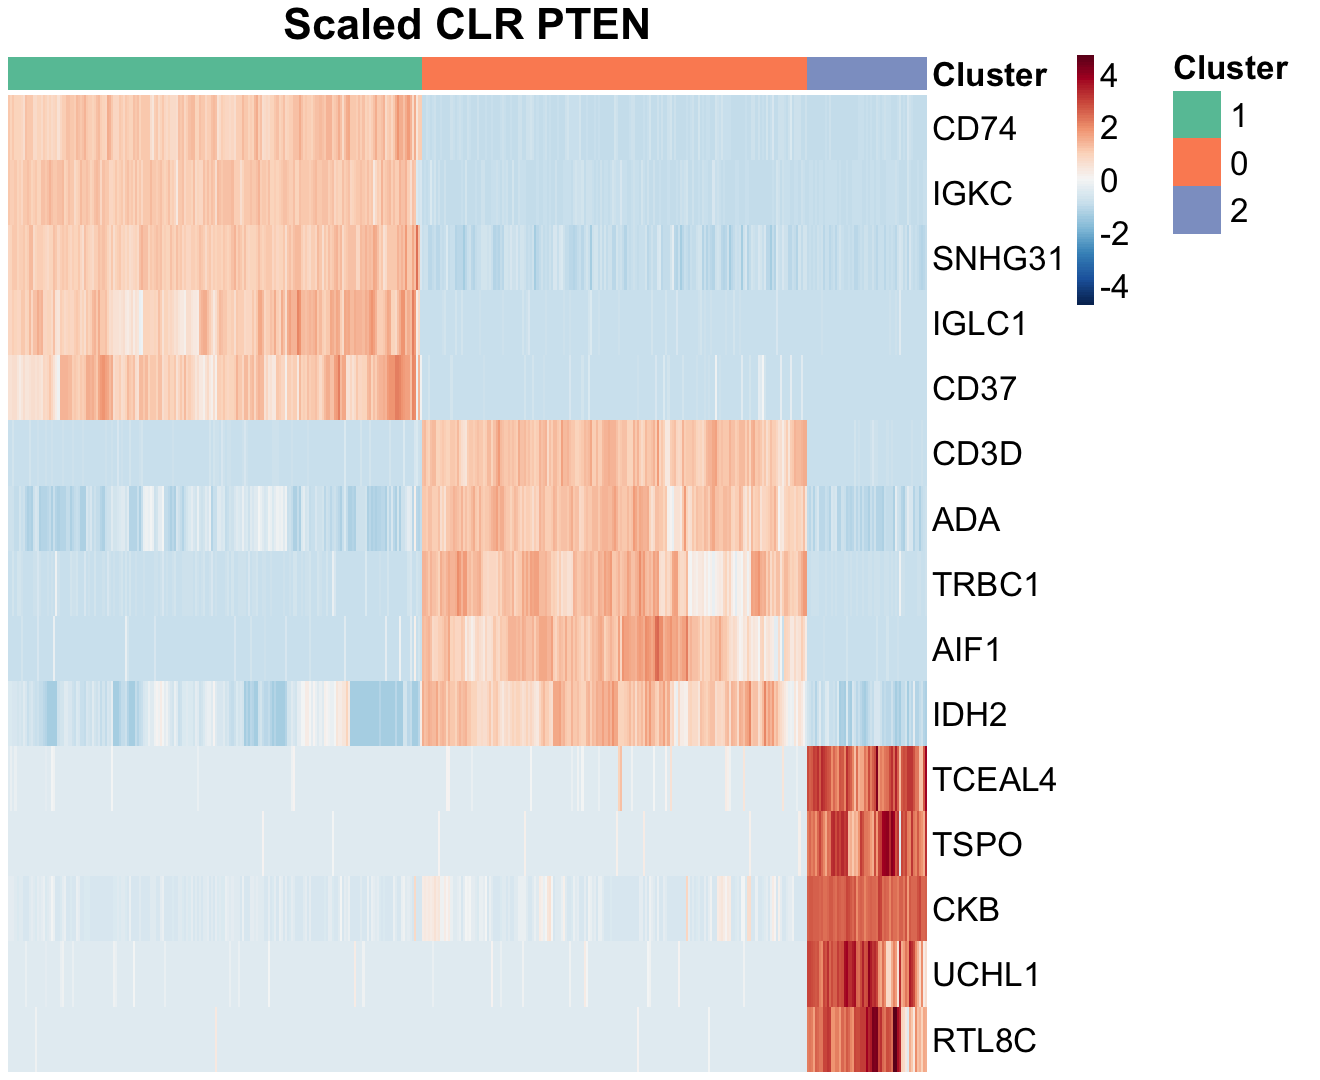

In [508]:
meta <- PTENplots2
cells <- intersect(PTENplots2$cell, colnames(scale_adt))
meta <- filter(meta, cell %in% cells)
df <- scale_exprs_JDHEK_all[,cells]
meta$cluster.x <- as.character(meta$cluster.x)

    
    dge = wilcoxauc(df, meta$cluster.x)
    write_csv(dge, "dge_RNA_PTEN.csv")

    var_genes = top_markers(dge, 5) %>% head(5) %>% select(-rank) %>% unlist %>% unique
    cmax = abs(df[var_genes, ]) %>% unlist %>% max
    
    mat_col <- data.frame(Cluster = meta$cluster.x)
    rownames(mat_col) <- meta$cell
    
    mat_colors <- list("Cluster" = c(
       `1` = "#66C2A5", 
        `0` = "#FC8D62", 
        `2` = "#8DA0CB"))
    
    mat_cluster_cols <- hclust(dist(t(df[var_genes, ])))
    mat_cluster_cols <- sort_hclust(mat_cluster_cols)
    mat_cluster_rows <- sort_hclust(hclust(dist(df[var_genes, 
        ])))
   

fig.size(9, 11)
    pheatmap(df[var_genes, ],
             main = "Scaled CLR PTEN", 
             breaks = seq(-cmax, cmax, length.out = 100), 
             color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev, 
             show_colnames = FALSE, 
             annotation_col = mat_col, 
             annotation_colors = mat_colors,
            fontsize = 20, 
             cluster_cols = mat_cluster_cols, 
             cluster_rows = mat_cluster_rows, 
             treeheight_row = 0, 
            treeheight_col = 0
            )

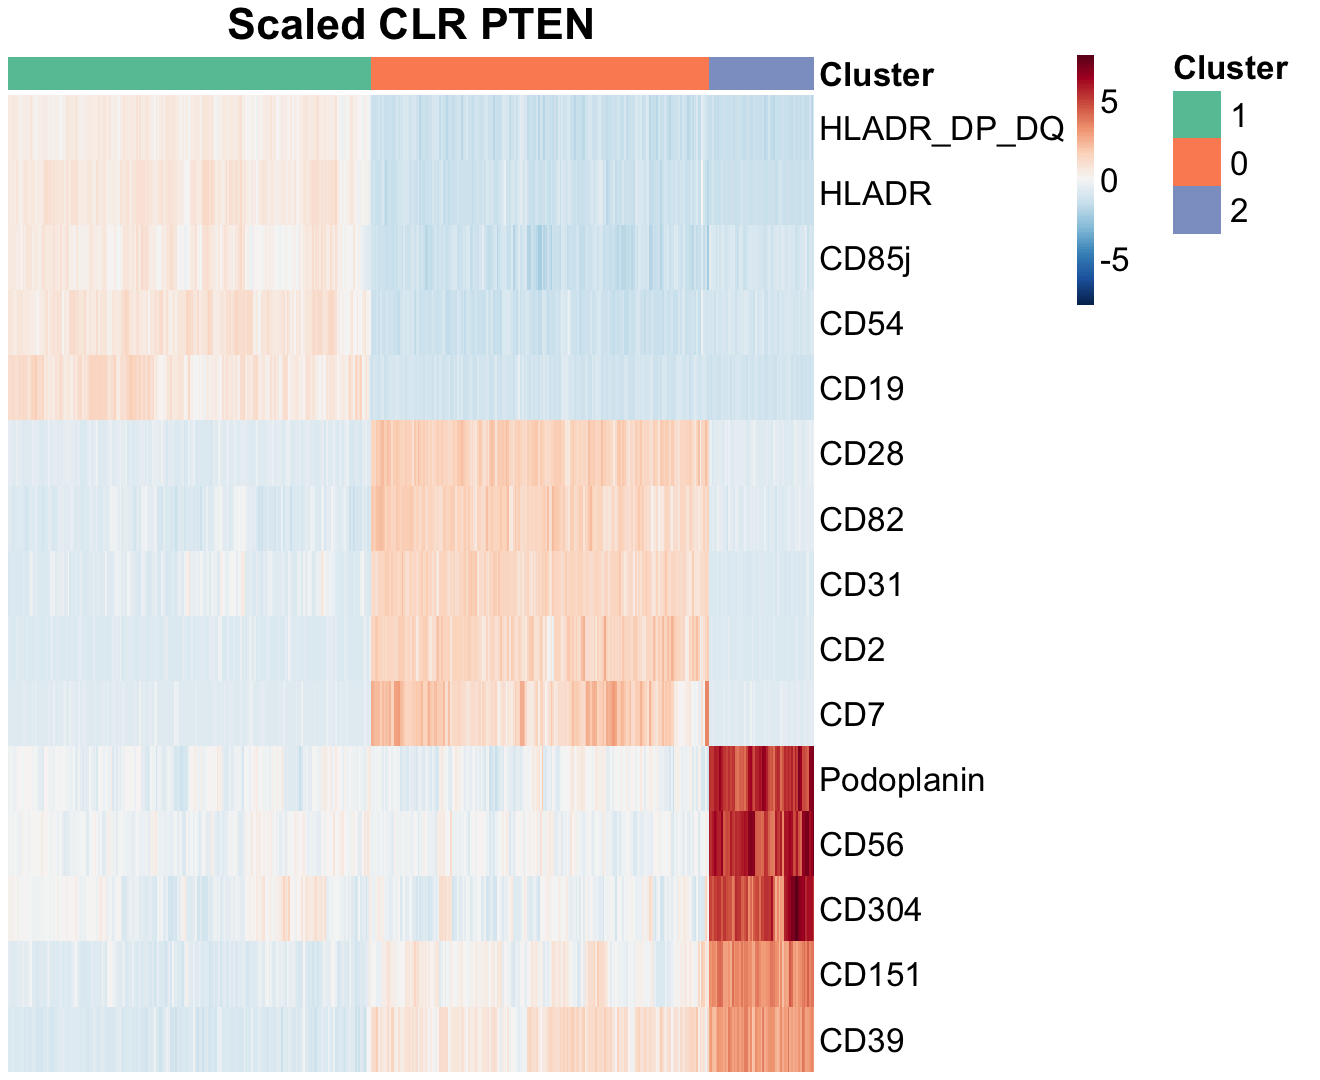

In [509]:
meta <- PTENplots2
cells <- intersect(PTENplots2$cell, colnames(scale_adt))
meta <- filter(meta, cell %in% cells)
df <- scale_adt[,cells]
meta$cluster.x <- as.character(meta$cluster.x)

    
    dge = wilcoxauc(df, meta$cluster.x)
write_csv(dge, "dge_ADT_PTEN.csv")
    var_genes = top_markers(dge, 5) %>% head(5) %>% select(-rank) %>% unlist %>% unique
    cmax = abs(df[var_genes, ]) %>% unlist %>% max
    
    mat_col <- data.frame(Cluster = meta$cluster.x)
    rownames(mat_col) <- meta$cell
    
    mat_colors <- list("Cluster" = c(
       `1` = "#66C2A5", 
        `0` = "#FC8D62", 
        `2` = "#8DA0CB"))
    
    mat_cluster_cols <- hclust(dist(t(df[var_genes, ])))
    mat_cluster_cols <- sort_hclust(mat_cluster_cols)
    mat_cluster_rows <- sort_hclust(hclust(dist(df[var_genes, 
        ])))
   

fig.size(9, 11)
    pheatmap(df[var_genes, ],
             main = "Scaled CLR PTEN", 
             breaks = seq(-cmax, cmax, length.out = 100), 
             color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev, 
             show_colnames = FALSE, 
             annotation_col = mat_col, 
             annotation_colors = mat_colors,
            fontsize = 20, 
             cluster_cols = mat_cluster_cols, 
             cluster_rows = mat_cluster_rows, 
             treeheight_row = 0, 
            treeheight_col = 0
            )

## FBXO11 - Merging modalities. A meta file is provided with the most important details in GEO

In [53]:
##Merge all three data sets
FBXO11plots <- FBXO11_alleles_DNA_filt_gen %>% rename(Well = "Well_ID") %>% 
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
    mutate("cell" = paste0(RNA_cell, "_", Barcode_RNA)) %>% 
    inner_join(dplyr::select(meta_umap_adt_FBXO11.clust, cell, cluster, UMAP1, UMAP2)) %>% 
    inner_join(dplyr::select(meta_umap_FBXO11.clust, cell, cluster, UMAP1, UMAP2), by = "cell") 
##Add FlowData to this. 
FBXO11plots <- FlowMatrix %>%
    mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>% 
    mutate(Condition = paste0(Experiment_Index, "_", Plate))  %>%
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode, "_", Barcode_RNA)) %>% 
    inner_join(FBXO11plots) %>% na.omit %>% 
    mutate("genotype3" = ifelse(Edited_Index == "Edited", 
                                ifelse(genotype == "2", "A/A", 
                                ifelse(genotype == "4", "A/G", 
                                ifelse(genotype == "1", "G/G", "Other"))), 
                                "Control")) %>% 
    mutate("genotype3" = fct_relevel(genotype3, 
            "Control", "A/A", "A/G", 
            "G/G"))


#Save meta data files
FBXO11plots %>% write_csv("FBXO11plots.csv")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'rename': object 'FBXO11_alleles_DNA_filt_gen' not found


## FBXO11 Condition Gating

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


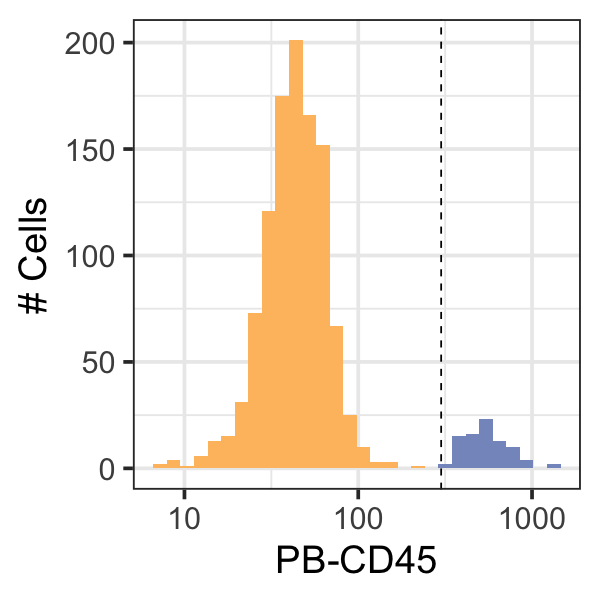

In [1556]:
#CRISPR gating - index sort
fig.size(5, 5)

FBXO11_alleles_DNA_filt_gen_Viz %>%
ggplot() +  
geom_histogram(aes(x = PB_CD45, fill = Edited_Index)) + 
scale_x_log10()+
theme_gy()+
scale_fill_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E",
          "A/G" = "#C994C7",
          "A/A" = "#DD1C77", 
          "G/G" = "grey"))+   
theme(legend.position = "none") +
geom_vline(xintercept = 300, linetype =2) + 
xlab("PB-CD45") + 
ylab("# Cells")




In [ ]:
# The rest of the analysis is performed in a separate workbook

## FBXO11 - Competition of ADT and FLOW on CD45 staining. 

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'
Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


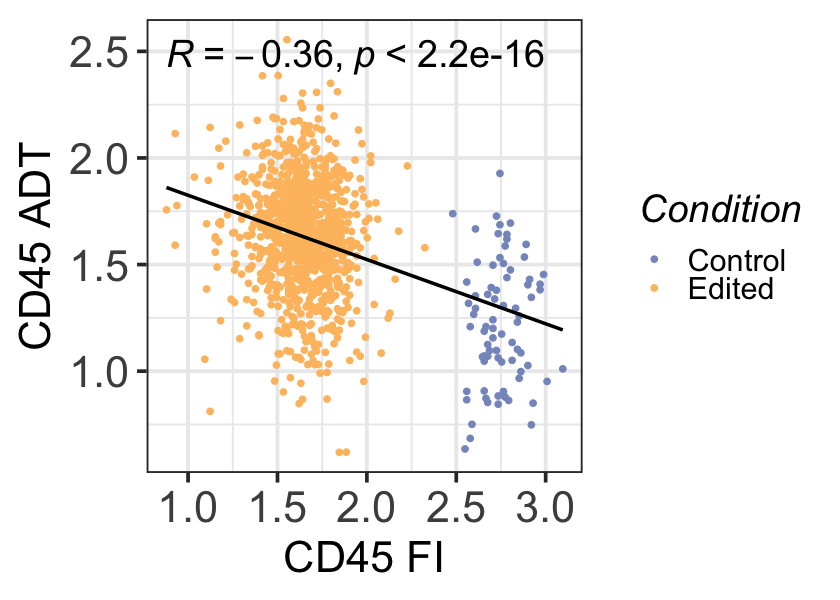

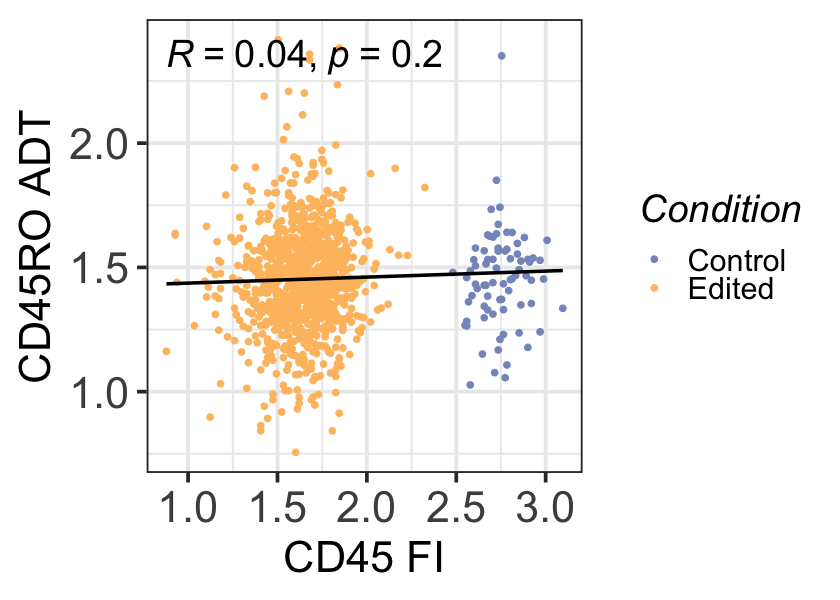

In [351]:
options(scipen = 0)
fig.size(5,7)
norm_exprs["PTPRC",] %>% as_tibble(rownames = "cell") %>% dplyr::rename("PTPRC" = value) %>% 
inner_join(FBXO11plots) %>% inner_join(
t(counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")) %>% as.matrix %>% as_tibble(rownames = "cell")) %>%


ggplot(aes(log10(PB_CD45), CD45)) + geom_point(aes(color = as.factor(Edited_Index))) +
stat_cor(size =8,vjust = 1) + 
theme_gy() + 
scale_color_brewer(palette = "Set2") + 
geom_smooth(method = lm, se = F, linetype =1, color = "black") + 
xlab("CD45 FI") + 
ylab("CD45 ADT") + labs(color = "Condition") + 
    theme(axis.title.x = element_text()) +
theme(legend.position = "right") +
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E"))

#Competition of ADT and FLOW on CD45R0 staining. 
options(scipen = 0)
fig.size(5,7)
norm_exprs["PTPRC",] %>% as_tibble(rownames = "cell") %>% dplyr::rename("PTPRC" = value) %>% 
inner_join(FBXO11plots) %>% inner_join(
t(counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")) %>% as.matrix %>% as_tibble(rownames = "cell")) %>%


ggplot(aes(log10(PB_CD45), CD45RO)) + geom_point(aes(color = as.factor(Edited_Index))) +
stat_cor(size =8,vjust = 1) + 
theme_gy() + 
scale_color_brewer(palette = "Set2") + 
geom_smooth(method = lm, se = F, linetype =1, color = "black") + 
xlab("CD45 FI") + 
ylab("CD45RO ADT") + labs(color = "Condition") + 
    theme(axis.title.x = element_text()) +
theme(legend.position = "right") +
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E"))

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


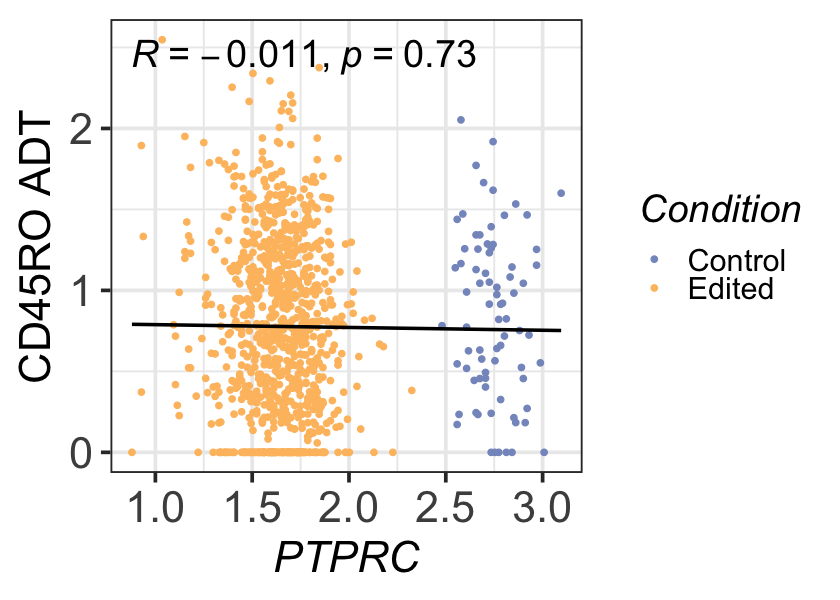

In [352]:
#Competition of ADT and FLOW on CD45R0 staining. 
options(scipen = 0)
fig.size(5,7)
norm_exprs["PTPRC",] %>% as_tibble(rownames = "cell") %>% dplyr::rename("PTPRC" = value) %>% 
inner_join(FBXO11plots) %>% inner_join(
t(counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")) %>% as.matrix %>% as_tibble(rownames = "cell")) %>%


ggplot(aes(log10(PB_CD45), PTPRC)) + geom_point(aes(color = as.factor(Edited_Index))) +
stat_cor(size =8,vjust = 1) + 
theme_gy() + 
scale_color_brewer(palette = "Set2") + 
geom_smooth(method = lm, se = F, linetype =1, color = "black") + 
xlab("PTPRC") + 
ylab("CD45RO ADT") + labs(color = "Condition") + 
    theme(axis.title.x = element_text(face = "italic")) +
theme(legend.position = "right") +
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E"))

## DQB1 - Merging Modalities - A meta file is provided in GEO

In [ ]:
##Merge all three data sets - Not done anymore, updated below with old values. 
## read in matrix from other work sheet defining cluster

DQB1Plots <- read_csv("DQB1matrix.csv") %>% select(cell, DQB1deletion_Mean, KClust, Edited_Index2) %>% 
    inner_join(select(meta_umap_adt_DQB1.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes)) %>% # Add meta adt data
    inner_join(select(meta_umap_DQB1.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes), by = "cell")  #add meta RNA data

##Add FlowData to this. 
DQB1Plots <- FlowMatrix %>%
    mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>% 
    mutate(Condition = paste0(Experiment_Index, "_", Plate))  %>%
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode, "_", Barcode_RNA)) %>% 
    inner_join(DQB1Plots) %>% na.omit
DQB1Plots%>% head
#Save meta data files
DQB1Plots %>% write_csv("DQB1Plots.csv")
DQB1Plots<- read_csv("DQB1Plots.csv")

In [732]:
DQB1plots_updated <- DeletionMatrix %>% select(cell, DQB1deletion_Mean) %>% unique %>%
    inner_join(select(read_csv("DQB1Plots.csv"),-DQB1deletion_Mean))%>% 
    select(-KClust) %>% inner_join(read_csv("Updated_Kclust.csv"))

Adding missing grouping variables: `plate_well`
Rows: 646 Columns: 37
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (16): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11...
dbl (21): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cell)`
Rows: 736 Columns: 2
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): cell
dbl (1): KClust

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cell)`


In [735]:
#Define cells by ADT cluster
Daudi_DQB1 <- DQB1plots_updated %>% filter(cluster.x == 1 ) %>% with(cell)
HH_DQB1 <- DQB1plots_updated %>% filter(cluster.x == 0 ) %>% with(cell)

## Kclust plots

In [748]:
#Adding RNA expression
DQB1plots_updated <- 
norm_exprs["HLA-DQB1", ] %>% as_tibble(rownames = "cell") %>% inner_join(DQB1plots_updated) %>% rename(value = "DQB1")

Joining with `by = join_by(cell)`


In [756]:
DQB1plots_updated$KClust <- as.factor(DQB1plots_updated$KClust)

In [261]:
fig.size(4, 10)

DQB1plots_updated  %>% { 
ggplot(.) +  
geom_boxplot(outlier.size = 0,
             aes(Edited_Index2, `DQB1`, color = Edited_Index2)) + 
geom_boxplot(outlier.size = 0, 
             data = filter(., Edited_Index2 != "Control"),
             aes(KClust, `DQB1`, color = KClust)) +
geom_jitter(aes(Edited_Index2, `DQB1`, color = Edited_Index2), 
           alpha = 0.2) + 
geom_jitter(data = . %>% filter(Edited_Index2 != "Control"),
             aes(KClust, `DQB1`, color = KClust), 
           alpha = 0.2) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "CRISPR", 
                           "2",
                           "1", 
                           "3"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
          "Control" = "#E41A1C",
          "CRISPR" = "#377EB8",
          "2" = "#DD1C77", 
          "1" = "#C994C7",
          "3" = "grey40"))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank())
    }

ERROR while rich displaying an object: Error in `geom_boxplot()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'DQB1' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler

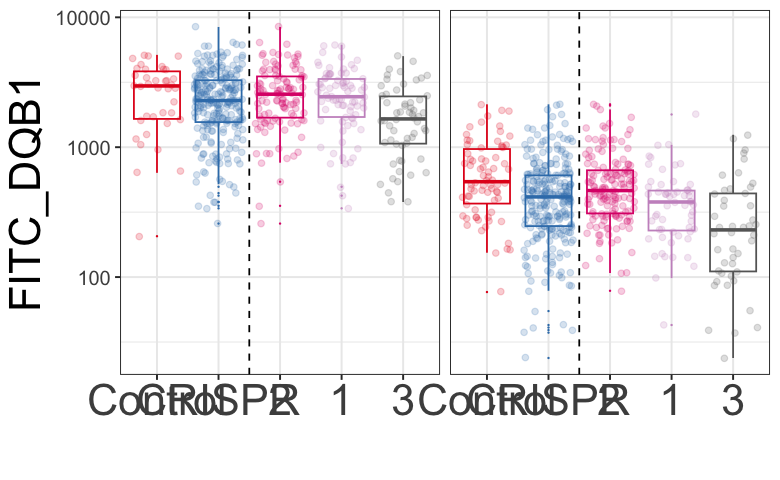

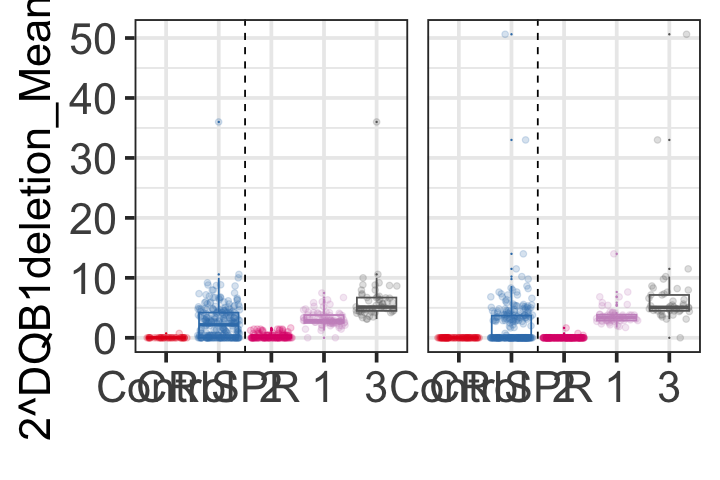

In [765]:
fig.size(4, 6.5)

DQB1plots_updated  %>% { 
ggplot(.) +  
geom_boxplot(outlier.size = 0,
             aes(Edited_Index2, `FITC_DQB1`, color = Edited_Index2)) + 
geom_boxplot(outlier.size = 0, 
             data = filter(., Edited_Index2 != "Control"),
             aes(KClust, `FITC_DQB1`, color = KClust)) +
geom_jitter(aes(Edited_Index2, `FITC_DQB1`, color = Edited_Index2), 
           alpha = 0.2) + 
geom_jitter(data = . %>% filter(Edited_Index2 != "Control"),
             aes(KClust, `FITC_DQB1`, color = KClust), 
           alpha = 0.2) + 
theme_gy(12)+
scale_x_discrete(limits = c("Control", 
                           "CRISPR", 
                           "2",
                           "1", 
                           "3"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
        "Control" = "#E41A1C",
          "CRISPR" = "#377EB8",
          "2" = "#DD1C77", 
          "1" = "#C994C7",
          "3" = "grey40"))+ 
xlab("") + 
    scale_y_log10()+
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank(), axis.text.y = element_text(size = 12))
    }


fig.size(4, 6)
DQB1plots_updated  %>% { 
ggplot(.) +  
geom_boxplot(outlier.size = 0,
             aes(Edited_Index2, 2^DQB1deletion_Mean-1, color = Edited_Index2)) + 
geom_boxplot(outlier.size = 0, 
             data = filter(., Edited_Index2 != "Control"),
             aes(KClust, 2^DQB1deletion_Mean-1, color = KClust)) +
geom_jitter(aes(Edited_Index2, 2^DQB1deletion_Mean-1, color = Edited_Index2), 
           alpha = 0.2) + 
geom_jitter(data = . %>% filter(Edited_Index2 != "Control"),
             aes(KClust, 2^DQB1deletion_Mean-1, color = KClust), 
           alpha = 0.2) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "CRISPR", 
                           "2",
                           "1", 
                           "3"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
          "Control" = "#E41A1C",
          "CRISPR" = "#377EB8",
          "2" = "#DD1C77", 
          "1" = "#C994C7",
          "3" = "grey40"))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank())
    }

## Pulling out HDR cells and looking at them

In [790]:
HDRplots <- 
DQB1plots_updated %>% mutate(DNA_well = paste0(Barcode_DNA, "_", Well_ID)) %>% 
filter(KClust == 2 & DQB1deletion_Mean == 0) %>% 
mutate("HDR" = ifelse(DNA_well %in% HDRCells, "HDR", "Reference"))

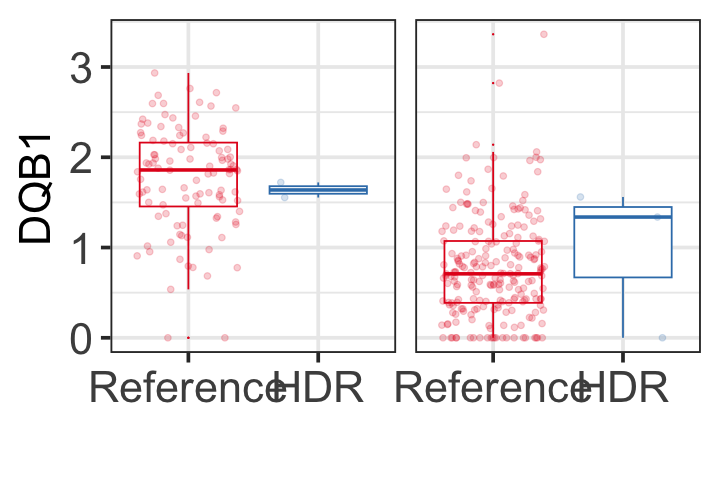

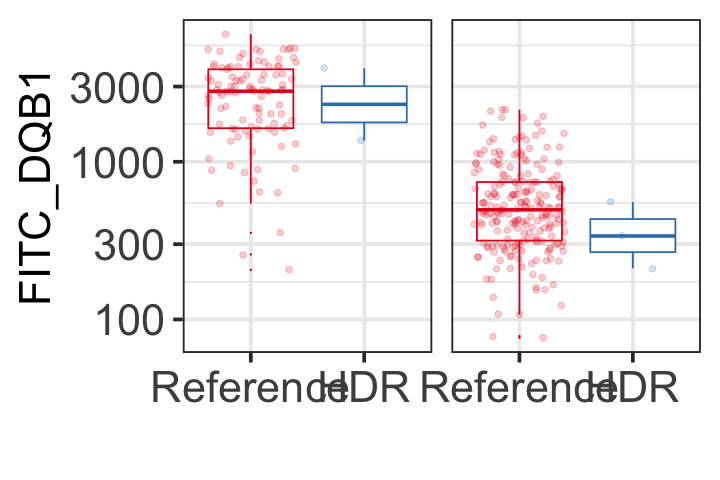

In [795]:
fig.size(4, 6)

HDRplots  %>% { 
ggplot(.) +  
geom_boxplot(outlier.size = 0,
             aes(HDR, `DQB1`, color = HDR)) + 
geom_jitter(aes(HDR, `DQB1`, color = HDR), 
           alpha = 0.2) + 
            
theme_gy()+
scale_x_discrete(limits = c("Reference", 
                           "HDR")) + 
scale_color_manual(values = c(
          "Reference" = "#E41A1C",
          "HDR" = "#377EB8"
          ))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank())
    }

fig.size(4, 6)

HDRplots  %>% { 
ggplot(.) +  
geom_boxplot(outlier.size = 0,
             aes(HDR, `FITC_DQB1`, color = HDR)) + 
geom_jitter(aes(HDR, `FITC_DQB1`, color = HDR), 
           alpha = 0.2) + 
            
theme_gy()+
scale_x_discrete(limits = c("Reference", 
                           "HDR")) + 
scale_color_manual(values = c(
          "Reference" = "#E41A1C",
          "HDR" = "#377EB8"
          ))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank()) + 
    scale_y_log10()
    }

## Linear modeling

In [588]:
library(lme4)

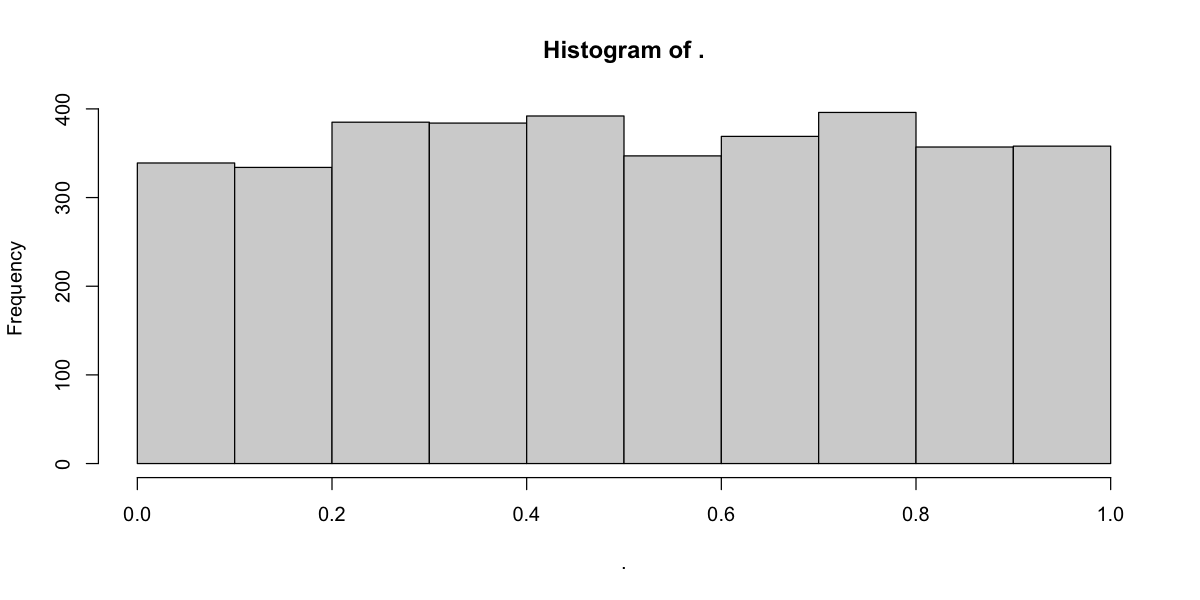

In [739]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1plots_updated %>% filter(cell %in% cells))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells] # expressed in 30% of cells
genes <- names(which(rowSums(Exprs)/length(cells)> 2)) # at least a mean count of 2. Filter out strange genes. 

suppressWarnings({
DQB1_lm_Daudi <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + DQB1deletion_Mean
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi<- DQB1_lm_Daudi %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi %>% with(pval) %>% hist
DQB1_lm_Daudi <- DQB1_lm_Daudi %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

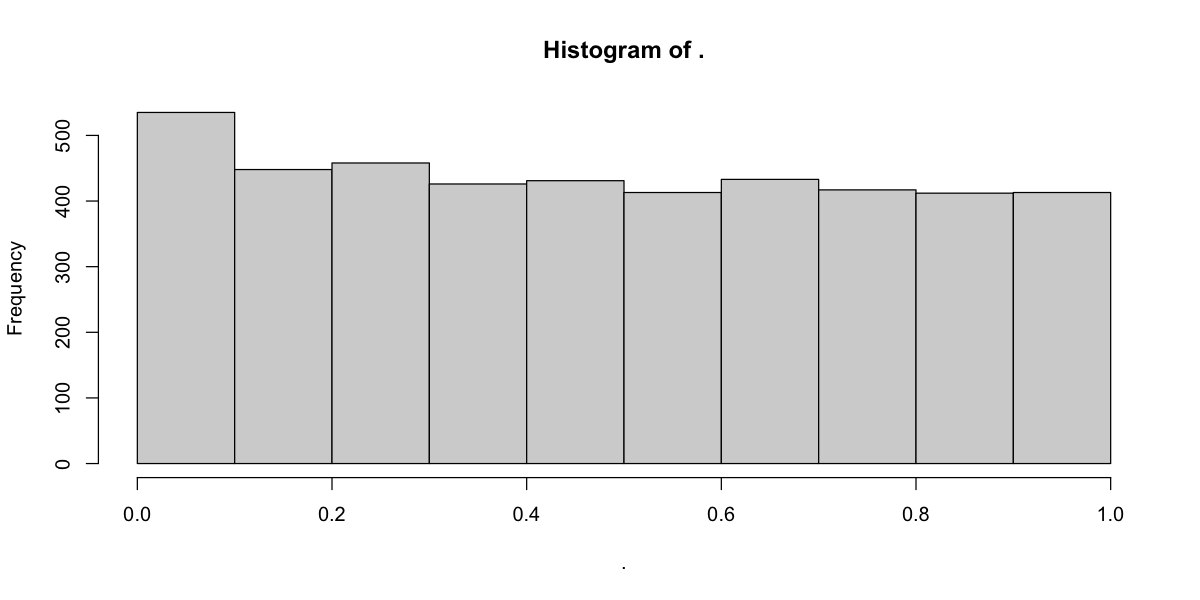

In [604]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

DQB1_exprs <- filt_exprs[gene_qc %>% filter(nCells > length(HH_DQB1)*0.3) %>% rownames, HH_DQB1]
genes <- names(which(rowSums(DQB1_exprs)/length(cells)> 2))

suppressMessages({
    suppressWarnings({
DQB1_lm_HH <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = (DQB1plots_updated %>% filter(cell %in% cells)),  
          formula = (DQB1_exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = (DQB1plots_updated %>% filter(cell %in% cells)),  
          formula = (DQB1_exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + DQB1deletion_Mean
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
        })
    })
DQB1_lm_HH<- DQB1_lm_HH %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH %>% with(pval) %>% hist
DQB1_lm_HH <- DQB1_lm_HH %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [607]:
DQB1_lm_Daudi %>% head(20)
DQB1_lm_HH %>% head(20)

Genes     pval                 beta        padj             
1  HLA-DQB1  0.000000000002112199 -0.44239564 0.000000007732762
2  TMEM259   0.000783244681056283 -0.18235639 0.812661456031287
3  IQGAP1    0.001007431535173797  0.19611413 0.812661456031287
4  AIFM1     0.001217995627433521 -0.16554407 0.812661456031287
5  COPS8     0.001381876543688043 -0.16769532 0.812661456031287
6  NTMT1     0.001887691135509462  0.13456104 0.812661456031287
7  LINC00665 0.001936279738998792 -0.17401671 0.812661456031287
8  NPM3      0.002082583540417349  0.14700406 0.812661456031287
9  LYRM2     0.002404449823611876  0.15080743 0.812661456031287
10 CEP95     0.002588738599449303 -0.19985370 0.812661456031287
11 SUV39H1   0.002619547927482091  0.17587422 0.812661456031287
12 TSG101    0.002663735993546967 -0.11553039 0.812661456031287
13 HDLBP     0.003415743256861670 -0.19013098 0.914639670144770
14 CMC2      0.003701136685051121 -0.12874647 0.914639670144770
15 DCAF8     0.003773819773374654 -0.20589108 0.914639670144770
16 EXOSC2    0.004290885798993171 -0.22277021 0.914639670144770
17 TIMM8B    0.004332455873568675 -0.15155701 0.914639670144770
18 BLOC1S1   0.004667639456069184  0.09867193 0.914639670144770
19 CTNNBL1   0.004786698909355902  0.12281671 0.914639670144770
20 RPA1      0.005210462472051591 -0.10315311 0.914639670144770

Genes      pval               beta        padj          
1  HLA-DQB1   0.0000000003698549 -0.28380336 0.000001622184
2  TARS2      0.0000346987697373  0.25965474 0.076094402034
3  DHFR       0.0000955422513320  0.10701930 0.108736233304
4  RPL32      0.0000991666514401 -0.07825301 0.108736233304
5  CFDP1      0.0002165496686656 -0.20086102 0.189957369353
6  GPX4       0.0002887999190554 -0.06946231 0.211112740829
7  MT-ND5     0.0004644698114316  0.10433192 0.291023513277
8  AC078923.1 0.0005494442991686 -0.06875533 0.301232837019
9  ASTN2      0.0006833217852540 -0.07095281 0.303389207493
10 RPL15      0.0006917218593092 -0.06645513 0.303389207493
11 RPS14      0.0008304349418684 -0.07066747 0.321803326815
12 MIR155HG   0.0008807487654374  0.12429953 0.321803326815
13 TMEM70     0.0010003746801531  0.15725924 0.321803326815
14 RPS23      0.0010500047996971 -0.05686458 0.321803326815
15 SLC35F1    0.0011005585732382 -0.05876698 0.321803326815
16 RPS8       0.0012654797584803 -0.06080235 0.346899638793
17 EMG1       0.0016045166113249  0.19984676 0.413965285722
18 CAMK1D     0.0018005995107984  0.25887332 0.422596907684
19 RPS4X      0.0018306751586856 -0.06764305 0.422596907684
20 AC009803.1 0.0019477797240647 -0.08367118 0.427148093487

## Linking Genes toLocations for the Purposes of creating a manhattan plot

In [474]:
gtf <- read_tsv("mart_export.tsv") # import from biomart
colnames(gtf) <- c("geneID", "transcriptID", "Start", "End", "TranscriptName", "ProteinID", "Strand", "Chr", "Gene") # rename
gtf_filt <- gtf %>% dplyr::select(Gene, Start, Chr) %>% unique # select gene positions

Rows: 276950 Columns: 9
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Gene stable ID, Transcript stable ID, Transcript name, Protein stab...
dbl (3): Gene start (bp), Gene end (bp), Strand

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [650]:
#Combine HH and Daudi results
Mix <- rbind(DQB1_lm_Daudi %>% mutate("CellType" = "Daudi"),
DQB1_lm_HH %>% mutate("CellType" = "HH"))

In [651]:
Mix<- Mix %>% rename(Genes = "Gene")

In [652]:
manh <- Mix %>% inner_join(gtf_filt)
manh<- manh %>% filter(Chr %in% 1:24) %>% mutate(Chr = as.numeric(Chr)) 
### do it with ggplot damnit
## filter out non numeric Chr
don <- manh %>% 
  
  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  dplyr::select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(manh, ., by=c("Chr"="Chr")) %>%
  
  # Add a cumulative position of each SNP
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

Joining with `by = join_by(Gene)`
Warning message in inner_join(., gtf_filt):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 20714 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [653]:
#prepare the xaxis 
axisdf = don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

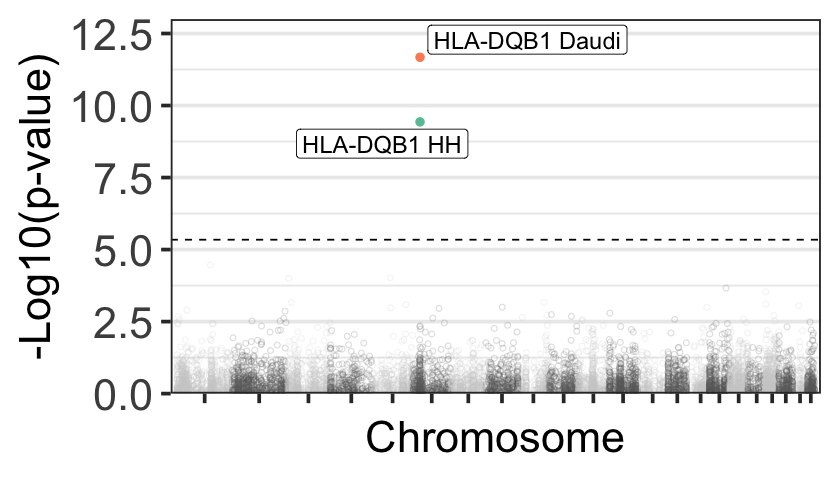

In [800]:
#define colors
colors = rep(c("grey80", "grey40"), 11 )
names(colors) = as.character(1:22)

fig.size(4,7)
g <- don %>% mutate(Gene = paste(Gene, CellType)) %>% 
{
ggplot(., aes(x=BPcum, y=-log10(pval))) +
    
    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.2, size=1.3, shape = 1) +
    scale_color_manual(values = c(colors, 
                                    "HH" = "#66C2A5", 
                                    "Daudi" = "#FC8D62"))+
    
    # custom X axis:
    scale_x_continuous(expand = c(0.01,0.01),label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(NA, -log10(10^-13))) +     # remove space between plot area and x axis
  
    # Custom the theme:
    theme_gy() +
    theme(axis.text.x =element_text(size =0, vjust = 0.5, angle = -90),
      legend.position="none",
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) + 
    geom_label_repel(data = filter(., pval < 0.05/6136), 
                     aes(label = Gene), size=5) + 

    geom_point(data = filter(., pval < 0.05/6136), 
                     aes(color = CellType), size=2, ) +
geom_hline(yintercept = -log10(0.05/11000), linetype = 2)+
xlab("Chromosome") + 
ylab("-Log10(p-value)")
    }
plot(g)
suppressWarnings({ggsave(g, filename = "Man.png", device="png", width = 10, height = 4) })

`geom_smooth()` using formula = 'y ~ x'


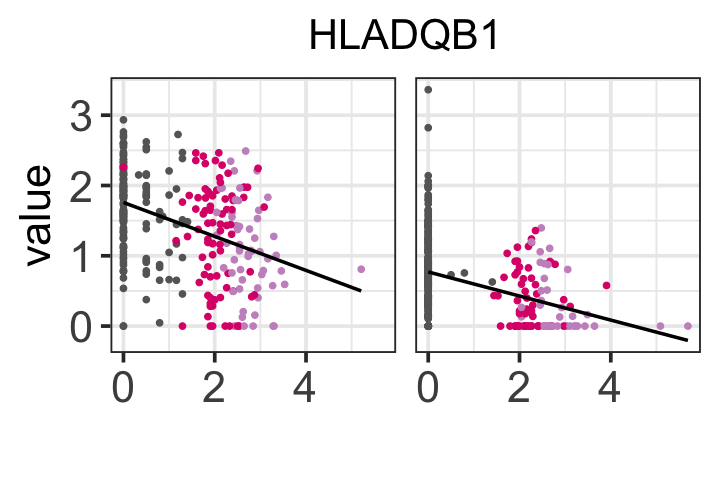

In [266]:
fig.size(4, 6)

norm_exprs["HLA-DQB1",] %>% 
as_tibble(rownames = "cell") %>% inner_join(DQB1plots_updated, by ="cell") %>%  {

ggplot(., aes(x = DQB1deletion_Mean, y = value)) +  
    
geom_point(data = ., aes(color = as.factor(KClust)))  +

theme_gy()+
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "CRISPR" = "#FDBF6E",
          "1" = "#DD1C77", 
          "3" = "#C994C7",
          "2" = "grey40"))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank()) + 
    geom_smooth(method = "lm", color = "black", se =F)
             } + 
ggtitle("HLADQB1")
    